In [1]:
# %matplotlib inline
%matplotlib agg
%matplotlib agg
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import pickle as pkl
import sys
import os
import torch
import numpy as np
import torch_scatter
import torchgraphs as tg
import yaml
import pandas as pd
from rdkit import Chem
from pathlib import Path
from munch import munchify
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display, HTML, SVG, Markdown,Image
import solubility.dataset
#from solubility.dataset import SolubilityDataset, smiles_to_graph
#from solubility.networks import SolubilityGN
from polymer_unit.dataset import SolubilityDataset, smiles_to_graph,get_pu_dist
from polymer_unit.networks import SolubilityGN
from utils import import_
from PURS import get_pu,get_pu_dict
import relevance

C:\py\Anaconda3\envs\gne\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import PURS as pu

In [3]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
label='PCE_max'
data_path='data/OPV_test.csv'
model_path='model/layers3_lr.01_biasyes_size64_wd.0001_drno_e100_sum_ZPKGHY'
picture_path='data/polymer/'#在此路径下放置需要分析的csv数据，格式同输入数据一样

In [5]:
def label_bin(label):
    return '$+$' if bool(label>0) else '$-$'

def label_cat(label):
        return '$+$' if bool(label>0) else '$\cdot$'

In [6]:
def mol_to_networkx(m):
    g = nx.Graph()
    for a in m.GetAtoms():
        g.add_node(a.GetIdx(), symbol=a.GetSymbol())
    for b in m.GetBonds():
        g.add_edge(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), bond=str(b.GetBondType()))
    return g

def autocrop(im, bgcolor='white'):
    if im.mode != "RGB":
        im = im.convert("RGB")
    bg = Image.new("RGB", im.size, bgcolor)
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    return None # no contents

In [7]:
#from PIL import Image, ImageChops
from PIL import ImageChops
from io import BytesIO

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

def moltosvg(mol,node_colors={}, edge_colors={}, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .1
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: .5 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    # svg = svg.replace('svg:','')
    return svg

In [8]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

def moltopng(path,name,mol,node_colors, edge_colors, molSize=(900,300),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    #修改字体大小
    drawer.drawOptions().maxFontSize=60
    drawer.drawOptions().minFontSize=30
    #drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: 1.2 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    drawer.WriteDrawingText(path+'{}.png'.format(name))
    
    #return drawer.GetDrawingText()


In [9]:
ds = SolubilityDataset(data_path)
display(ds.df.sort_values(label).head())
display(ds.df.sort_values(label).tail())

C:\Users\20599\ANACONDA-FILE\opv\pu-gn-exp\PURS.py:1397: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  nozero=torch.nonzero(i)


Compound ID                                             smiles Nickname  \
24           25  CC1=CC(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C2=C3C=CC(...      PCz   
81           82  CC(S1)=CC2=C1C(OCCCCCCCCCCCC)=C(C=C(C3=C4C(N=C...       H9   
37           38  CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...       P2   
82           83  CC(S1)=CC2=C1C(OCCCCCCCCCCCC)=C(C=C(C3=CC=C(C)...      H11   
28           29  C/C=C/C1=CC(N(C2=CC=C(OCCCCCCCC)C=C2)C3=C4C=CC...  PCVTTTT   

   Ref. No  PCE_max  PCE_ave  Voc (V)  Jsc (mA/cm2)    FF  Mw (kg/mol)  ...  \
24     S15     0.07     0.07     0.71          0.26  0.37         75.5  ...   
81     S37     0.11     0.11     0.22          1.41  0.35         76.1  ...   
37     S19     0.13     0.13     0.66          0.55  0.35          8.9  ...   
82     S37     0.18     0.18     0.55          1.05  0.32         35.5  ...   
28     S16     0.20     0.20     0.50          0.76  0.43          8.2  ...   

    linear  linear_Categ2  branch  sum  branch_Categ2  linear_Categ  \
24       0              1       1    1              0             1   
81       2              0       0    2              1             2   
37       0              1       1    1              0             1   
82       2              0       0    2              1             2   
28       3              0       0    3              1             2   

    branch_Categ  max_linear  branch_linear  branch_linear_34  
24             1           0              1                 1  
81             1          26              1                 1  
37             1           0              1                 1  
82             1          26              1                 1  
28             1          25              1                 0  

[5 rows x 1563 columns]

Compound ID                                             smiles  \
83           84  CC(S1)=CC2=C1C(C3=CC(CCCCCC)=C(CC(CC)CCCC)S3)=...   
7             8  CC1=C(C[C@@H](CCCCCCCC)CCCCCCCCCC)C=C(C2=CC(C3...   
10           11  CC1=CC=C(C2=C(CC(CCCCCCCCCC)CCCCCCCCCCCC)C=C(C...   
4             5  CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...   
3             4  CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...   

       Nickname Ref. No  PCE_max  PCE_ave  Voc (V)  Jsc (mA/cm2)    FF  \
83      PBDT-BT     S38      9.4     9.15     0.92          15.4  0.64   
7    PNTz4T-2OD      S4     10.1     9.70     0.76          19.8  0.68   
10       PNTz4T      S7     10.1     9.77     0.71          19.4  0.73   
4   PffBT4T-2OD      S4     10.4    10.00     0.77          18.2  0.74   
3   PffBT4T-2OD      S4     10.5    10.20     0.77          18.4  0.74   

    Mw (kg/mol)  ...  linear  linear_Categ2  branch  sum  branch_Categ2  \
83        468.0  ...       2              0       2    4              0   
7          49.9  ...       0              1       2    2              0   
10        126.2  ...       0              1       2    2              0   
4          52.9  ...       0              1       2    2              0   
3          93.7  ...       0              1       2    2              0   

    linear_Categ  branch_Categ  max_linear  branch_linear  branch_linear_34  
83             2             1          12              0                 0  
7              1             1           0              1                 1  
10             1             1           0              1                 1  
4              1             1           0              1                 1  
3              1             1           0              1                 1  

[5 rows x 1563 columns]

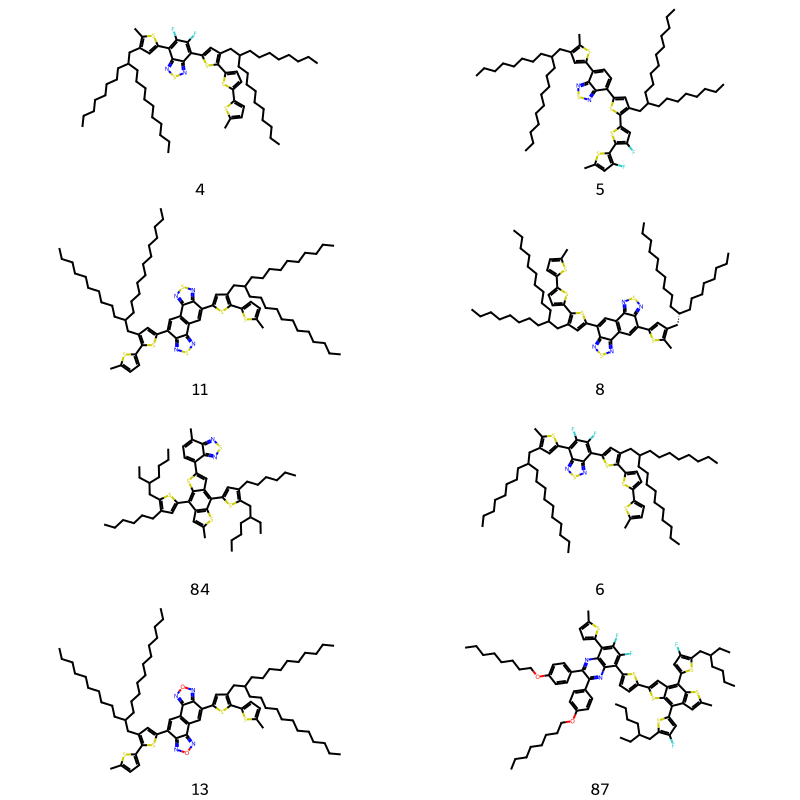

In [10]:
mols = [Chem.MolFromSmiles(s) for s in ds.df.sort_values(label, ascending=False).head(8).smiles]
names = ds.df.sort_values(label, ascending=False).head(8)['Compound ID']
legends=[str(i) for i in list(names)]
svg = Draw.MolsToGridImage(mols, molsPerRow=2, useSVG=True, subImgSize=(400, 200), legends=legends)
svg

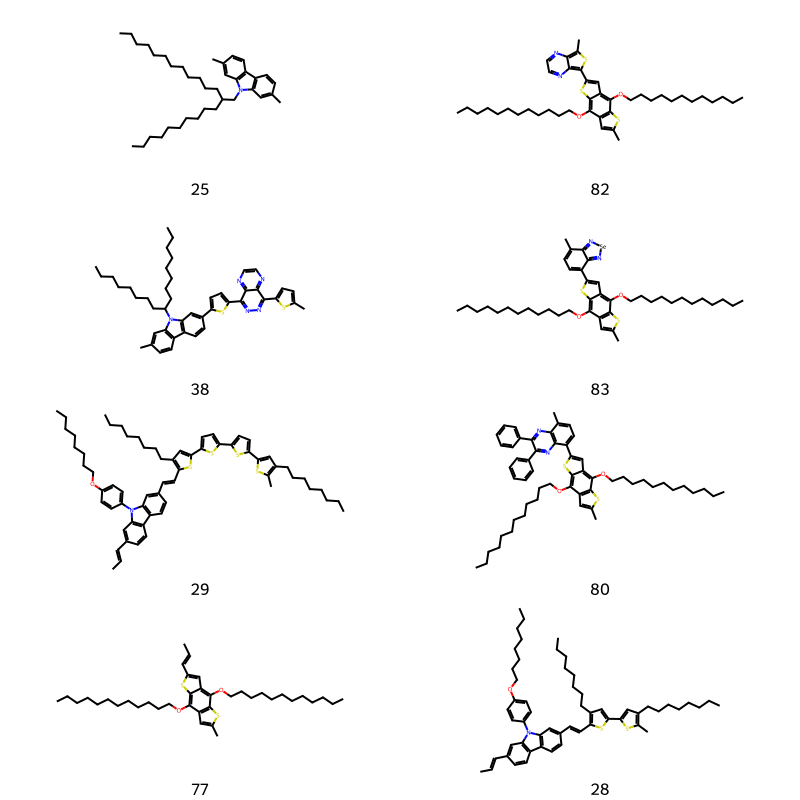

In [11]:
mols = [Chem.MolFromSmiles(s) for s in ds.df.sort_values(label, ascending=True).head(8).smiles]
names = ds.df.sort_values(label, ascending=True).head(8)['Compound ID']
legends=[str(i) for i in list(names)]
svg = Draw.MolsToGridImage(mols, molsPerRow=2, useSVG=True, subImgSize=(400, 200), legends=legends)
svg

In [12]:
experiment = Path(model_path) 

with experiment.joinpath('experiment.latest.yaml').open('r') as f:
    model = munchify(yaml.safe_load(f)['model'])
model.state_dict = experiment / 'model.latest.pt'

if 'aggregation' not in model.kwargs:
    model.kwargs['aggregation'] = 'mean'

net = SolubilityGN(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))
net.eval();

In [13]:
class SolubilityRelevance(SolubilityGN):
    def __init__(self, num_layers, hidden_bias, hidden_node, dropout, aggregation):
        super(SolubilityGN, self).__init__()

        hidden_edge = hidden_node // 4
        hidden_global = hidden_node // 8
        
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=8),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(hidden_node, node_features=167),
            'node_relu': relevance.NodeReLURelevance(),
            'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node,
                                      edge_features=hidden_edge, aggregation=aggregation),
            'global_relu': relevance.GlobalReLURelevance(),
        }))
        if dropout:
            self.hidden = torch.nn.Sequential(OrderedDict({
                f'hidden_{i}': torch.nn.Sequential(OrderedDict({
                    'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=hidden_edge,
                                          sender_features=hidden_node, bias=hidden_bias),
                    'edge_relu': relevance.EdgeReLURelevance(),
                    'edge_dropout': tg.EdgeDropout(),
                    'node': relevance.NodeLinearRelevance(hidden_node, node_features=hidden_node, incoming_features=hidden_edge,
                                          aggregation=aggregation, bias=hidden_bias),
                    'node_relu': relevance.NodeReLURelevance(),
                    'node_dropout': tg.EdgeDropout(),
                    'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node, edge_features=hidden_edge,
                                              global_features=hidden_global, aggregation=aggregation, bias=hidden_bias),
                    'global_relu': relevance.GlobalReLURelevance(),
                    'global_dropout': tg.EdgeDropout(),
                }))
                for i in range(num_layers)
            }))
        else:
            self.hidden = torch.nn.Sequential(OrderedDict({
                f'hidden_{i}': torch.nn.Sequential(OrderedDict({
                    'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=hidden_edge,
                                          sender_features=hidden_node, bias=hidden_bias),
                    'edge_relu': relevance.EdgeReLURelevance(),
                    'node': relevance.NodeLinearRelevance(hidden_node, node_features=hidden_node, incoming_features=hidden_edge,
                                          aggregation=aggregation, bias=hidden_bias),
                    'node_relu': relevance.NodeReLURelevance(),
                    'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node, edge_features=hidden_edge,
                                              global_features=hidden_global, aggregation=aggregation, bias=hidden_bias),
                    'global_relu': relevance.GlobalReLURelevance(),
                }))
                for i in range(num_layers)
            }))
        self.readout_globals = relevance.GlobalLinearRelevance(4, global_features=hidden_global, bias=True)

net_rel = SolubilityRelevance(*model.args, **model.kwargs)
net_rel.load_state_dict(torch.load(model.state_dict, map_location='cpu'))
net_rel.eval();

In [14]:
batch, _ = tg.GraphBatch.collate(list(ds))

solubility_out = net(batch).global_features.squeeze()

In [15]:
pred = torch.tensor(solubility_out.detach().numpy())
pred = torch.argmax(pred,1,keepdim=True).squeeze()

In [16]:
solubility_out = pd.Series(pred.numpy(), name='MyPrediction', index=ds.df.index)

In [17]:
df_out = pd.merge(solubility_out, ds.df, left_index=True, right_index=True, sort=False)
df_out['mse_loss'] = (df_out[label] - df_out.MyPrediction) ** 2

display(df_out.sort_values('mse_loss').head())
display(df_out.sort_values('mse_loss').tail())

print(df_out.mse_loss.mean())

C:\Users\20599\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


MyPrediction  Compound ID  \
40             1           41   
24             0           25   
80             1           81   
41             1           42   
32             1           33   

                                               smiles Nickname Ref. No  \
40  CC1=CC(N(C(CCCCCCCCCC)CCCCCCCCCC)C2=C3C=CC(C4=...      TP3     S20   
24  CC1=CC(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C2=C3C=CC(...      PCz     S15   
80  CC(S1)=CC2=C1C(OCCCCCCCCCCCC)=C(C=C(C3=CC=C(C)...       H7     S37   
41  CC1=CC(N(C(CCCCCCCCCC)CCCCCCCCCC)C2=C3C=CC(C4=...      TP4     S20   
32  CC1=CC(N(C(CCCCCCCC)CCCCCCCC)C2=C3C=CC(C4=CC=C...  PCDTTPP     S18   

    PCE_max  PCE_ave  Voc (V)  Jsc (mA/cm2)    FF  ...  linear_Categ2  branch  \
40     1.02     1.02     0.56          4.41  0.41  ...              1       1   
24     0.07     0.07     0.71          0.26  0.37  ...              1       1   
80     0.90     0.90     0.68          2.97  0.44  ...              0       0   
41     0.90     0.90     0.62          3.94  0.37  ...              1       1   
32     1.10     1.10     0.90          2.60  0.44  ...              1       1   

    sum  branch_Categ2  linear_Categ  branch_Categ  max_linear  branch_linear  \
40    1              0             1             1           0              1   
24    1              0             1             1           0              1   
80    2              1             2             1          26              1   
41    1              0             1             1           0              1   
32    1              0             1             1           0              1   

    branch_linear_34  mse_loss  
40                 1    0.0004  
24                 1    0.0049  
80                 1    0.0100  
41                 1    0.0100  
32                 1    0.0100  

[5 rows x 1565 columns]

MyPrediction  Compound ID  \
83             1           84   
7              1            8   
10             1           11   
4              1            5   
3              1            4   

                                               smiles     Nickname Ref. No  \
83  CC(S1)=CC2=C1C(C3=CC(CCCCCC)=C(CC(CC)CCCC)S3)=...      PBDT-BT     S38   
7   CC1=C(C[C@@H](CCCCCCCC)CCCCCCCCCC)C=C(C2=CC(C3...   PNTz4T-2OD      S4   
10  CC1=CC=C(C2=C(CC(CCCCCCCCCC)CCCCCCCCCCCC)C=C(C...       PNTz4T      S7   
4   CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=CC=C(C3=CC...  PffBT4T-2OD      S4   
3   CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C...  PffBT4T-2OD      S4   

    PCE_max  PCE_ave  Voc (V)  Jsc (mA/cm2)    FF  ...  linear_Categ2  branch  \
83      9.4     9.15     0.92          15.4  0.64  ...              0       2   
7      10.1     9.70     0.76          19.8  0.68  ...              1       2   
10     10.1     9.77     0.71          19.4  0.73  ...              1       2   
4      10.4    10.00     0.77          18.2  0.74  ...              1       2   
3      10.5    10.20     0.77          18.4  0.74  ...              1       2   

    sum  branch_Categ2  linear_Categ  branch_Categ  max_linear  branch_linear  \
83    4              0             2             1          12              0   
7     2              0             1             1           0              1   
10    2              0             1             1           0              1   
4     2              0             1             1           0              1   
3     2              0             1             1           0              1   

    branch_linear_34  mse_loss  
83                 0     70.56  
7                  1     82.81  
10                 1     82.81  
4                  1     88.36  
3                  1     90.25  

[5 rows x 1565 columns]

15.977542574257429


In [18]:
from IPython.display import Image
import csv

In [19]:
def process_smiles(file_name):
    
    file=open(file_name)
    fileReader=csv.reader(file)
    filedata=list(fileReader)

    smi_list=[]
    name_list0=[]#重名未做处理的名称列表
    name_list=[]#做了重名处理的名称列表
    mol_list = []
    num_list = []
    label_list1 = []
    label_list2 = []
    for i in filedata:
        #Rdkit识别不出顺反，要把'/'与'\'去掉
        if '/'in i[1]:
            i[1]=i[1].replace('/','')
        if '\\'in i[1]:
            i[1]=i[1].replace('\\','')
        mol=Chem.MolFromSmiles(i[1])
        if mol:
            smi=Chem.MolToSmiles(mol)
            num = mol.GetNumAtoms()
            num_list.append(num)
            smi_list.append(smi)
            AllChem.EmbedMolecule(mol)
            mol_list.append(mol)
            adj = Chem.GetAdjacencyMatrix(mol)
            label_list1.append(i[4])#填写第一个标签的列索引编号
            label_list2.append(i[5])#填写第二个标签的列索引编号，只有一个标签就同上
        
        #重名的数据会在后面加上重复的个数
            if i[0] in name_list0:
                num = name_list.count(i[0])
                name = i[0]+'-'+str(num)
                name_list.append(name)
            else:
                name_list.append(i[0])
            name_list0.append(i[0])
            
    return smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2

In [20]:
smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2 = process_smiles(data_path)
total_bratch_dist = pu.get_bratch_dist2(smi_list,name_list)
ring_total_list0,total_neighbor_data0,total_inner_dist0,_=pu.get_pu(smi_list,name_list)
total_neighbor_data,total_inner_dist,ring_total_list = pu.update_bratch(name_list,smi_list,total_neighbor_data0,total_inner_dist0,total_bratch_dist)
total_neighbor_data,total_inner_dist,ring_total_list = pu.get_new_neighbor_data(total_neighbor_data,total_inner_dist,name_list,smi_list)

In [21]:
def get_analysis_picture(path,filename,s):
    #filename填入需要分析的结构文件名
    #s是纯文件名，比如“data/polymer.csv”填写“polymer_”,填写文件名方便归纳整理图片
    smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2= process_smiles(filename)
    name_list2 = []
    for idx,i in enumerate(name_list):
        label1 = label_list1[idx]
        label2 = label_list2[idx]
        name = 'name_'+ str(i)+'_'+'label1_'+str(label1)+'_'+'label2_'+str(label2)
        name_list2.append(name)
    total_bratch_dist = pu.get_bratch_dist2(smi_list,name_list)
    ring_total_list0,total_neighbor_data0,total_inner_dist0,_=pu.get_pu(smi_list,name_list)
    total_neighbor_data,total_inner_dist,ring_total_list = pu.update_bratch(name_list,smi_list,total_neighbor_data0,total_inner_dist0,total_bratch_dist)
    total_neighbor_data,total_inner_dist,ring_total_list = pu.get_new_neighbor_data(total_neighbor_data,total_inner_dist,name_list,smi_list)
    inner_dist={}
    for key,values in total_inner_dist.items():
        inner_list = []
        for k,v in values.items():
            inner_list.append(v)
        inner_dist[key]=inner_list
    pu_dist = get_pu_dist(filename)
    
    for idx,sm in enumerate(smi_list):    
        name = name_list[idx]
        solubility_target = np.nan
        mol = Chem.MolFromSmiles(sm)
        graph_in = smiles_to_graph(pu_dist,name)
        batch = tg.GraphBatch.from_graphs([graph_in]).requires_grad_().zero_grad_()
        out = net_rel(batch).global_features
        #display(Markdown(f'### {name}'))
        #display(Markdown(f'{np.round(solubility_target, 2)}\t{round(out.item(), 2)}'))
        out.backward(out)
        node_rel = batch.node_features.grad.sum(dim=1)
        atom_rel = torch.zeros([mol.GetNumAtoms(),1])
        inner = inner_dist[name]
        for Idx,I in enumerate(inner):
            rel = node_rel[Idx]
            for j in I:
                atom_rel[j]=rel
        atom_rel = atom_rel.view([1,mol.GetNumAtoms()])
        atom_rel = atom_rel[0]
        vmax = max(atom_rel.abs().max(), 1e-16)
        vmin = -vmax
        file_name = s+name_list2[idx]
        #clist=['cyan','mediumturquoise','paleturquoise','lightcyan','azure','aliceblue','whitesmoke','lavenderblush','mistyrose','peachpuff','lightsalmon','salmon','tomato']
        clist=['cyan','mediumturquoise','paleturquoise','lightcyan','whitesmoke','peachpuff','lightsalmon','salmon','tomato']
        newcmp = LinearSegmentedColormap.from_list('chaos',clist)
        node_colors = newcmp((atom_rel - vmin) / (vmax - vmin) )[:,:3]
        #node_colors = cm.get_cmap('coolwarm')((atom_rel - vmin) / (vmax - vmin) )[:,:3]
        node_colors[0]=node_colors[1]
        moltopng(path,file_name,mol, node_colors=node_colors, edge_colors={}, molSize=(900,900))
        display(Image(filename = path+'{}.png'.format(file_name), width=1000))


In [22]:
print(torch_scatter.__file__)

C:\py\Anaconda3\envs\gne\lib\site-packages\torch_scatter\__init__.py


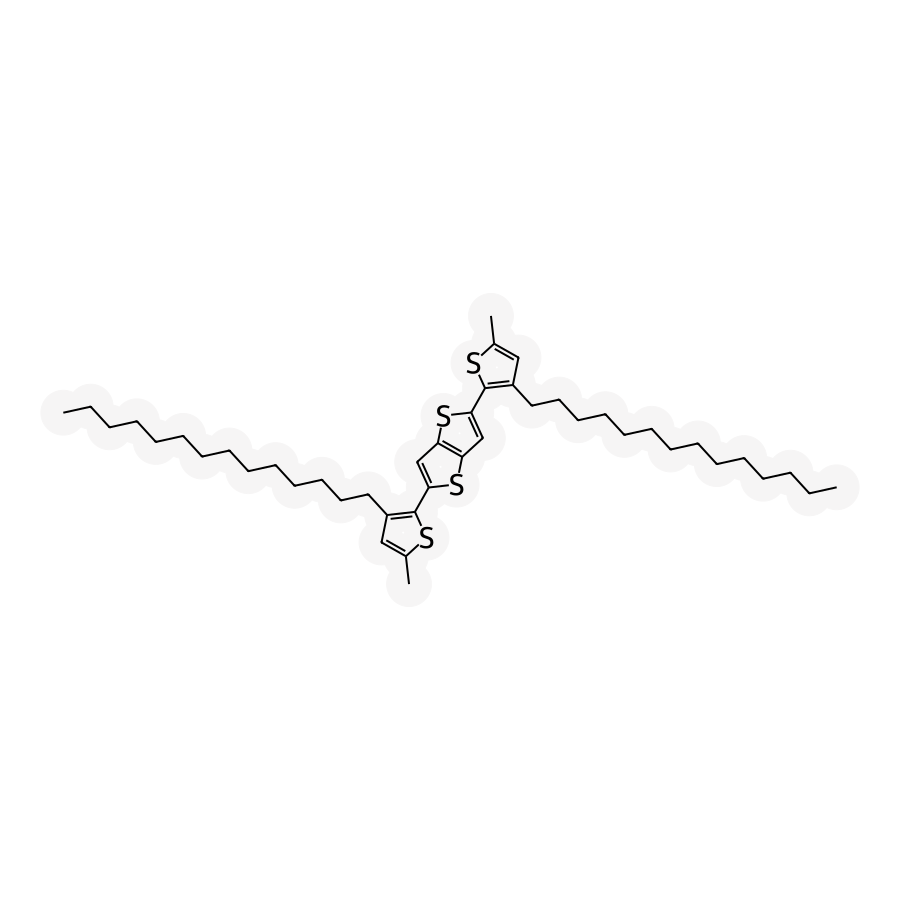

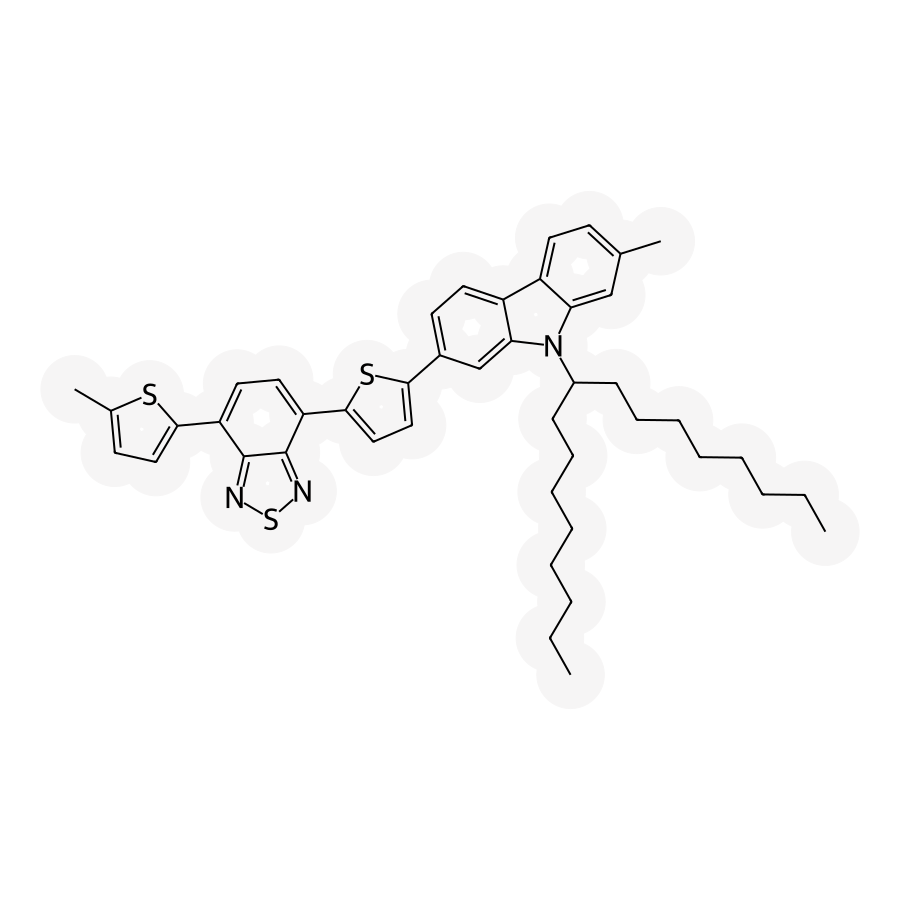

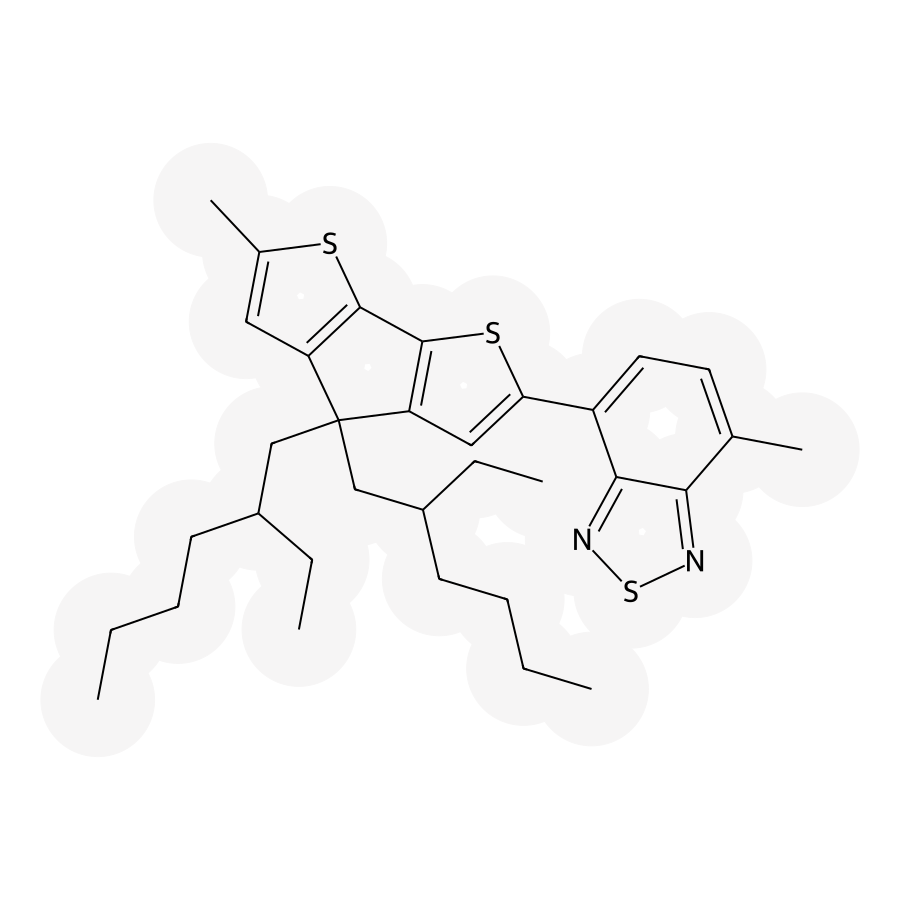

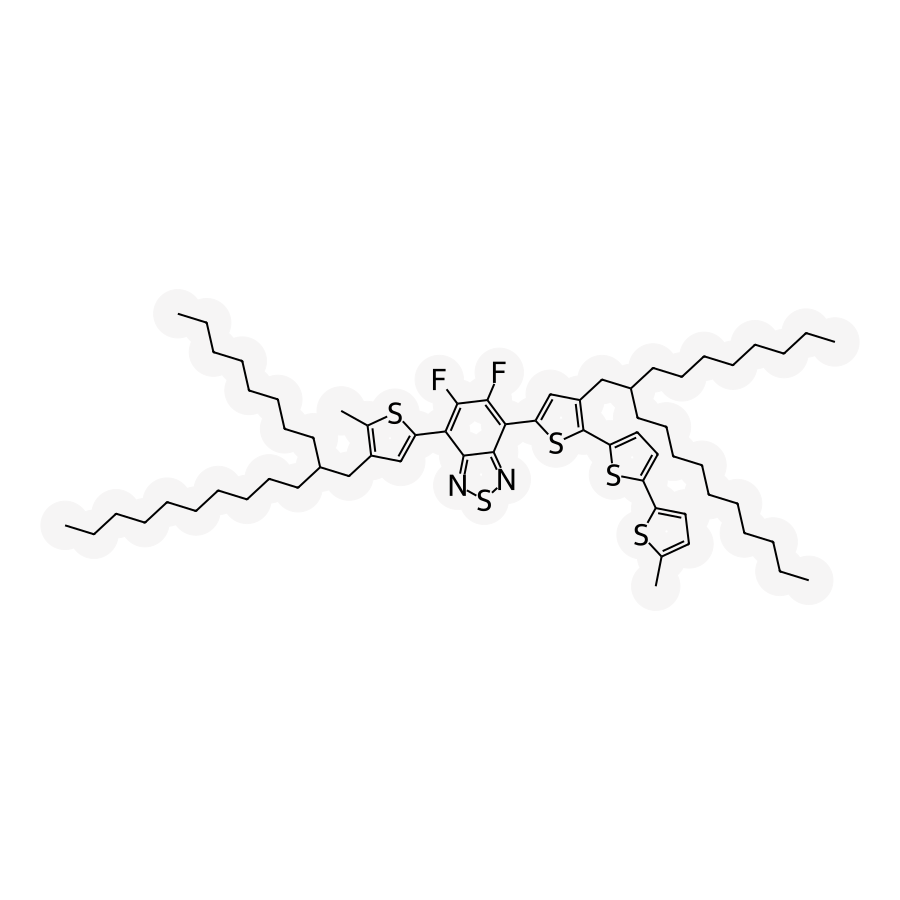

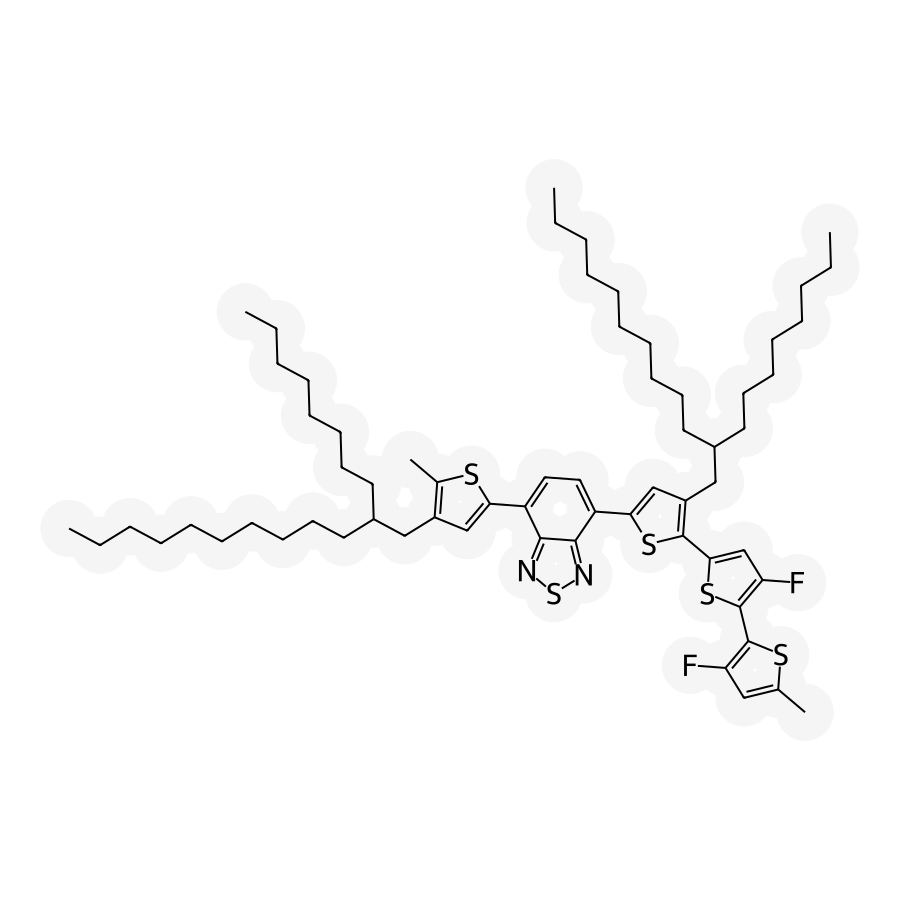

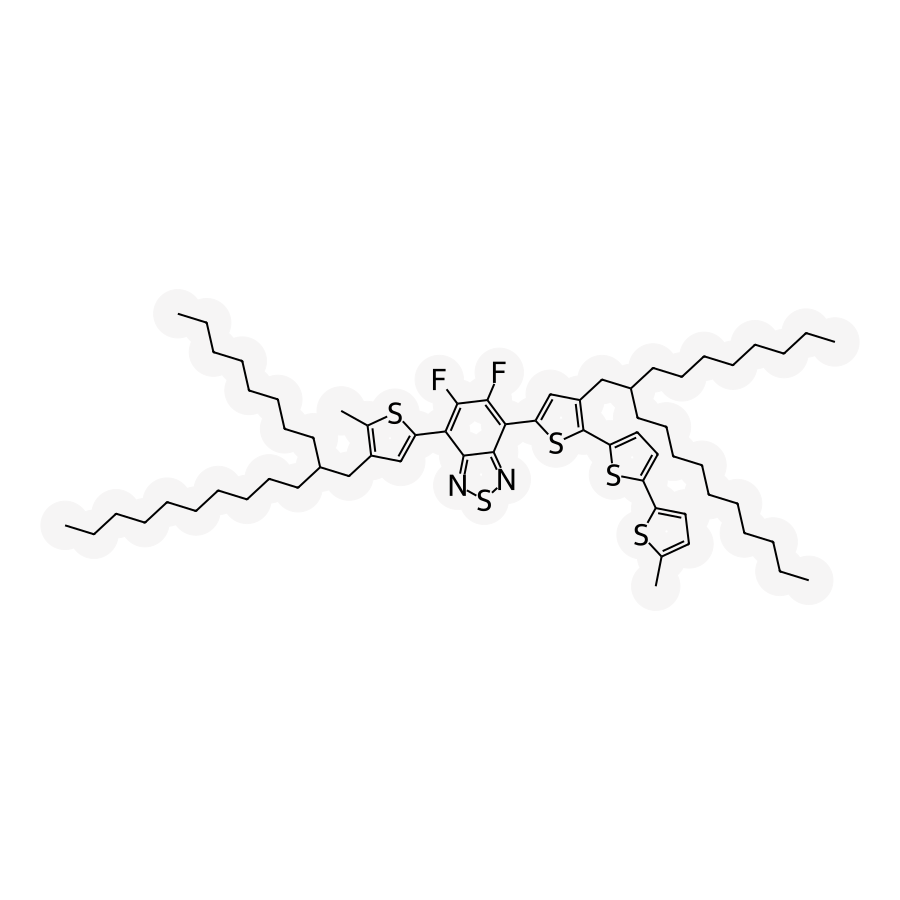

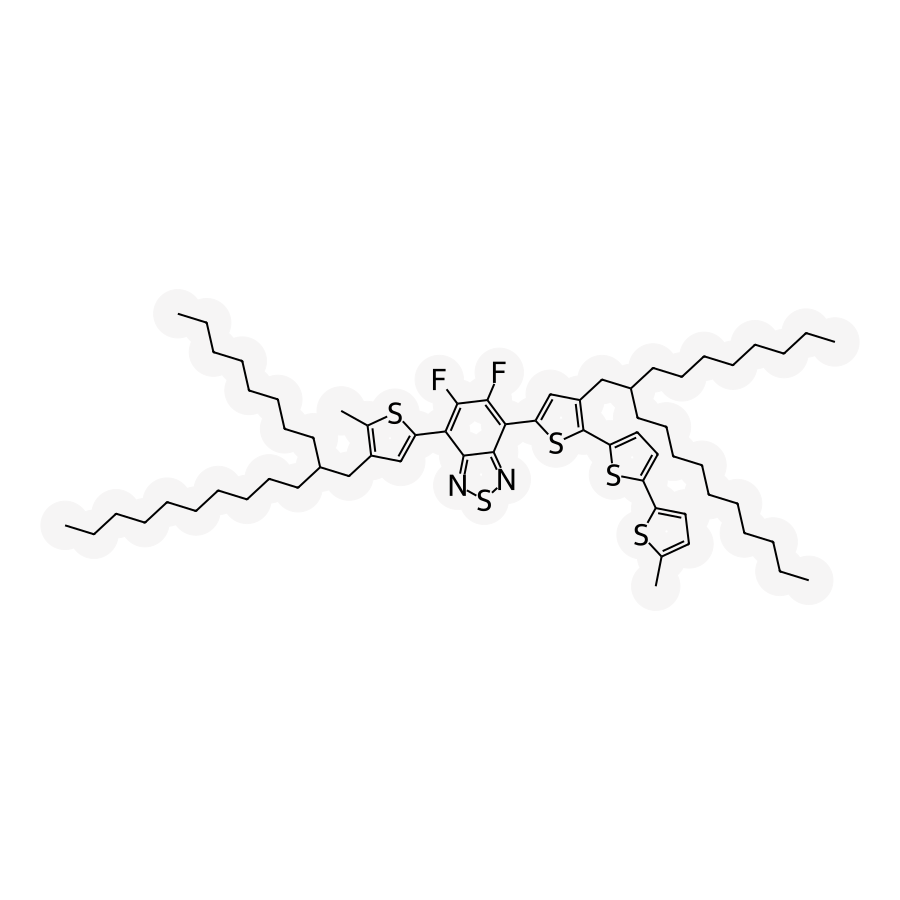

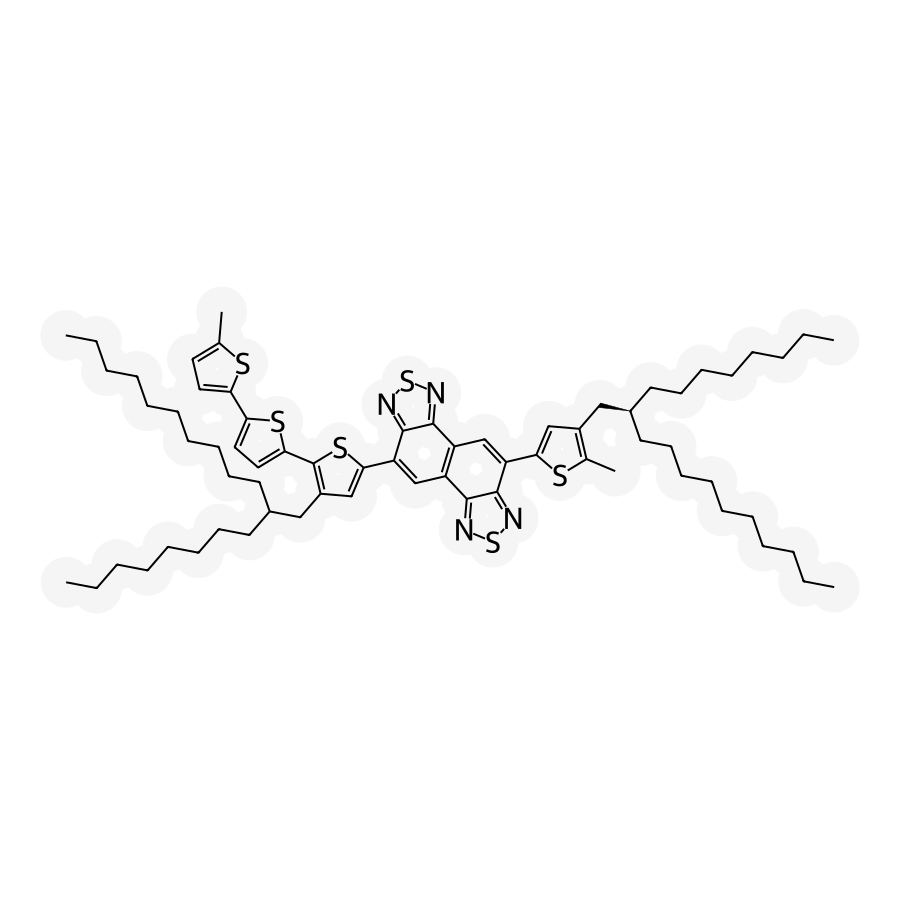

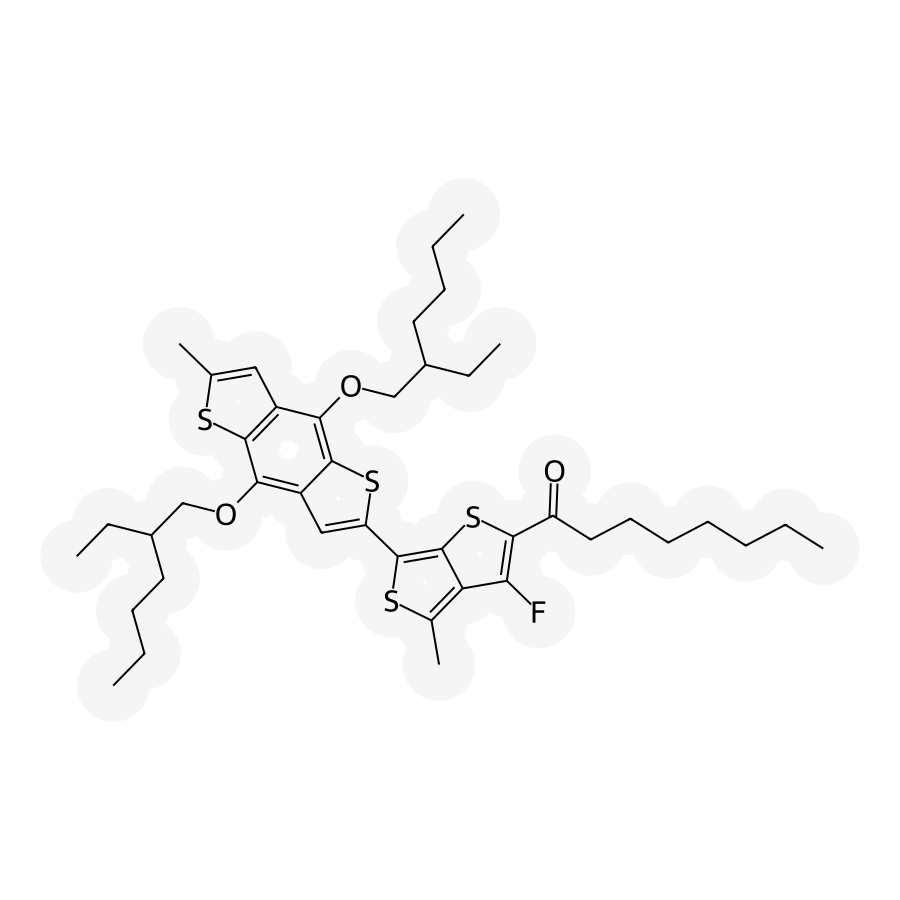

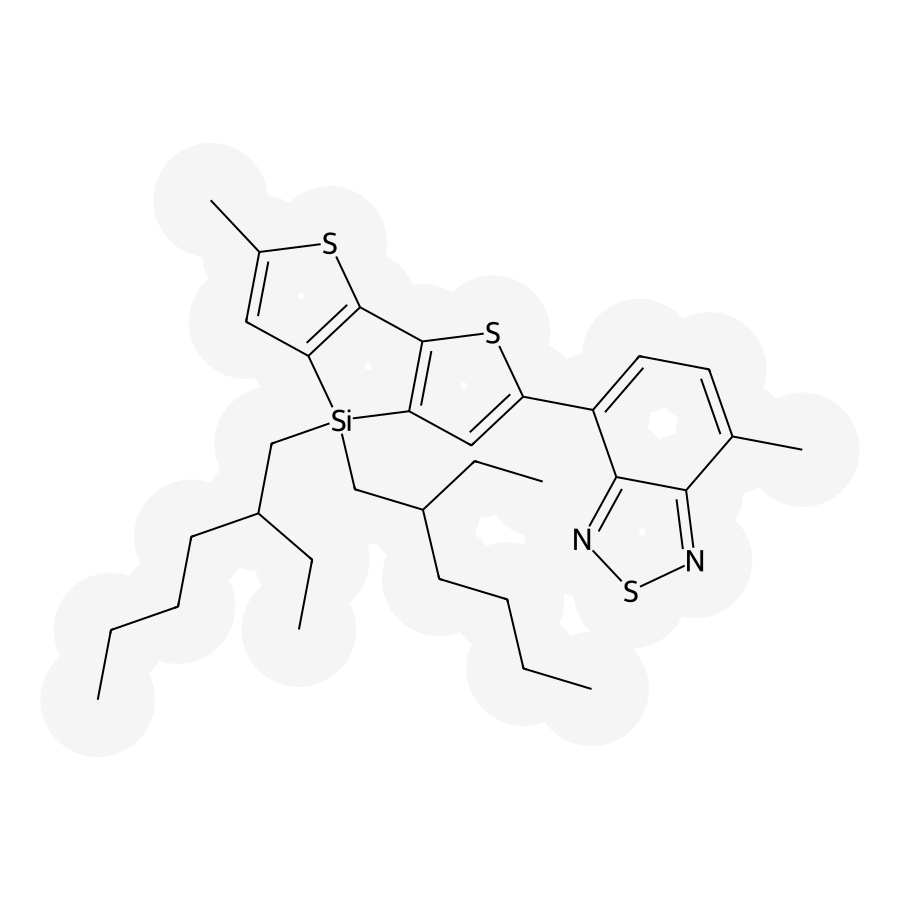

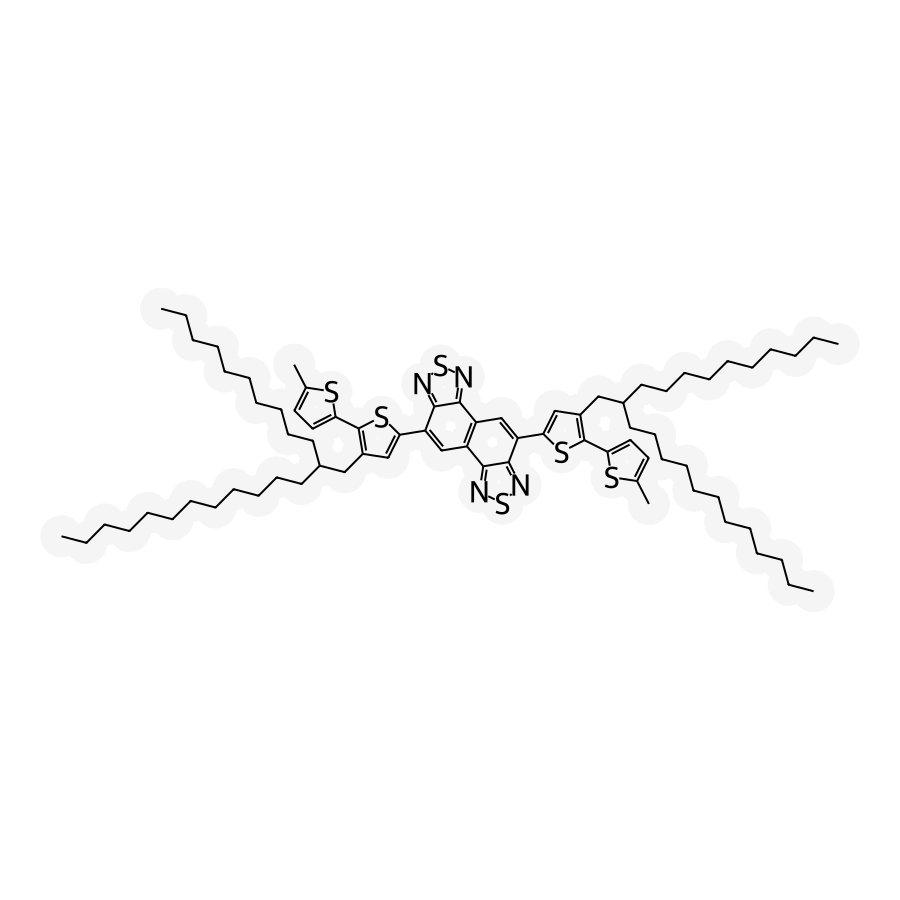

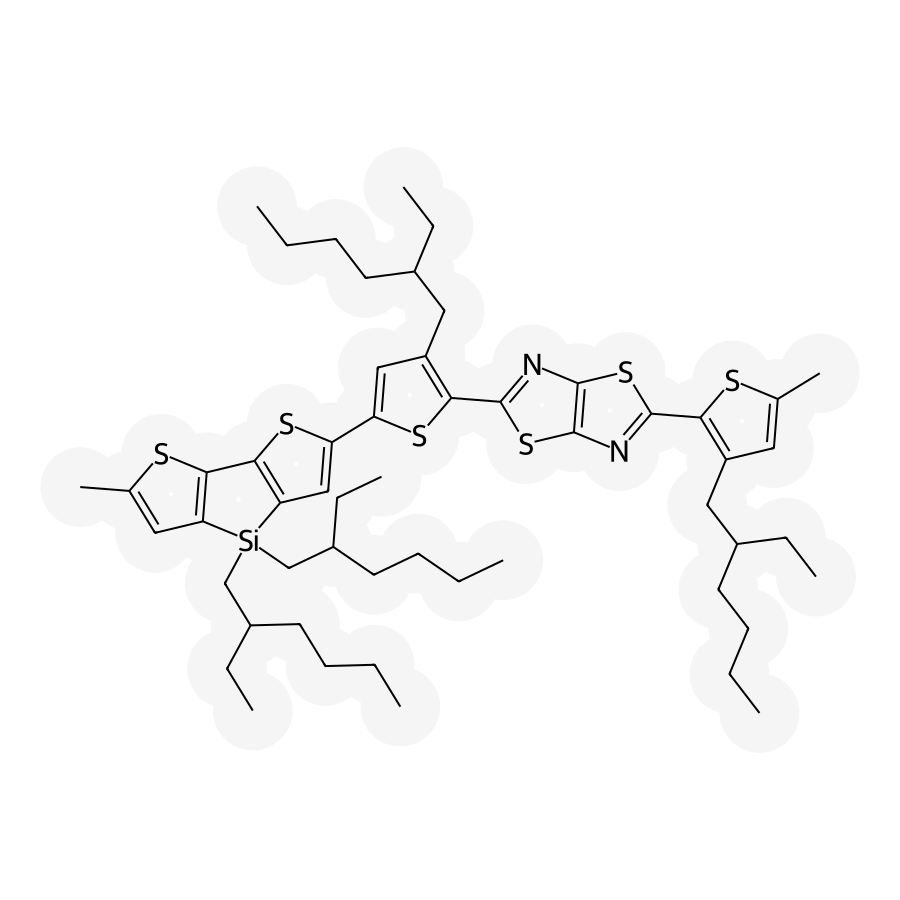

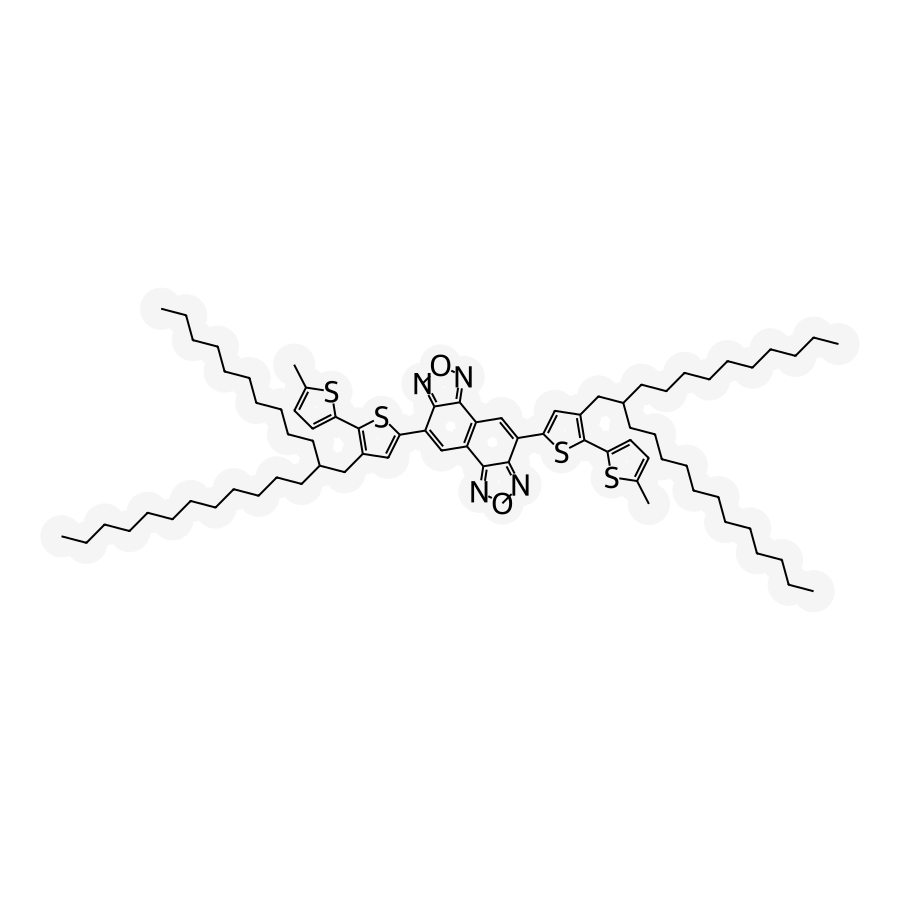

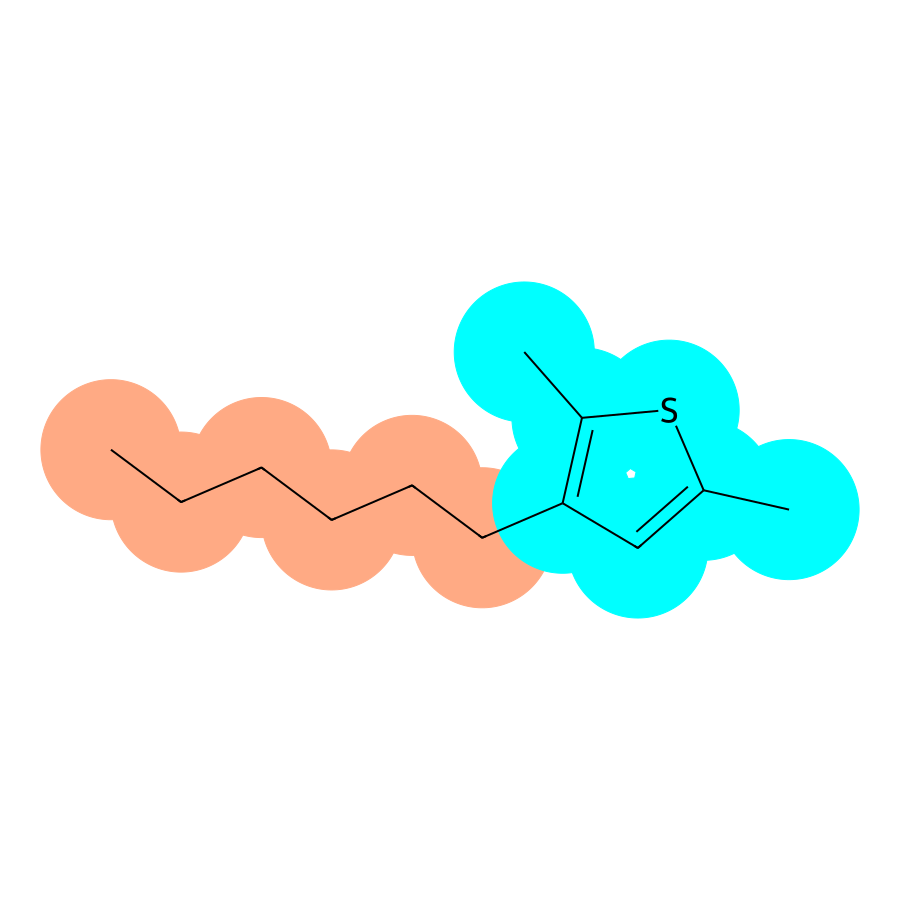

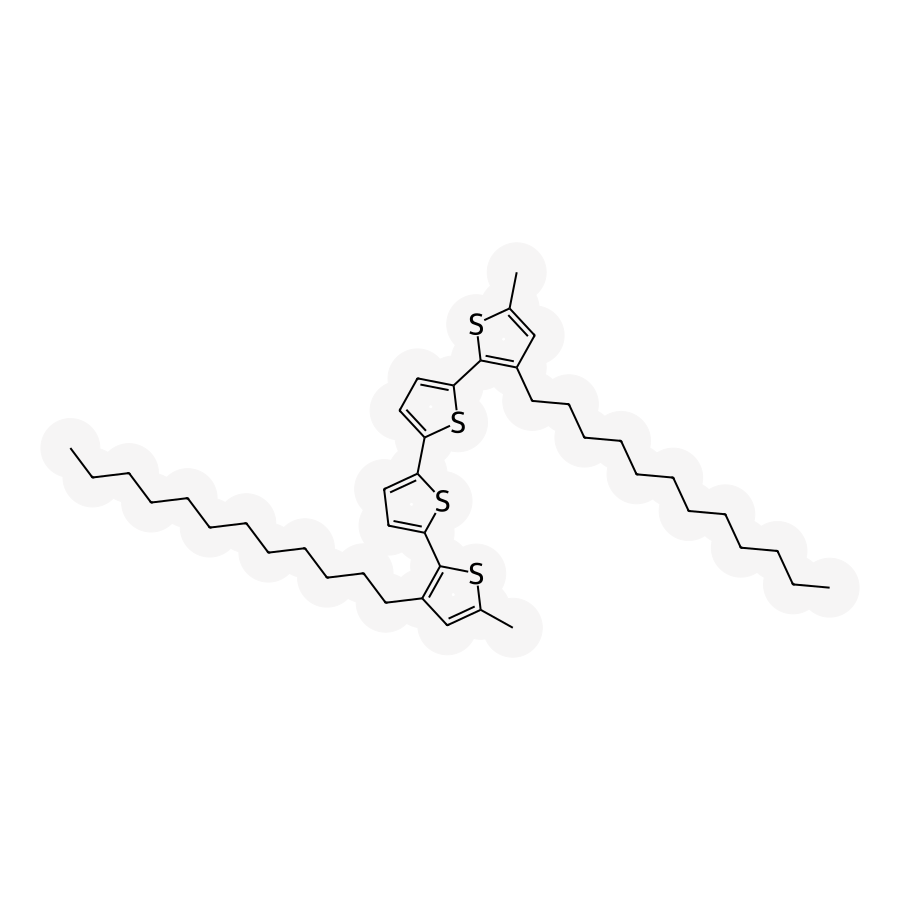

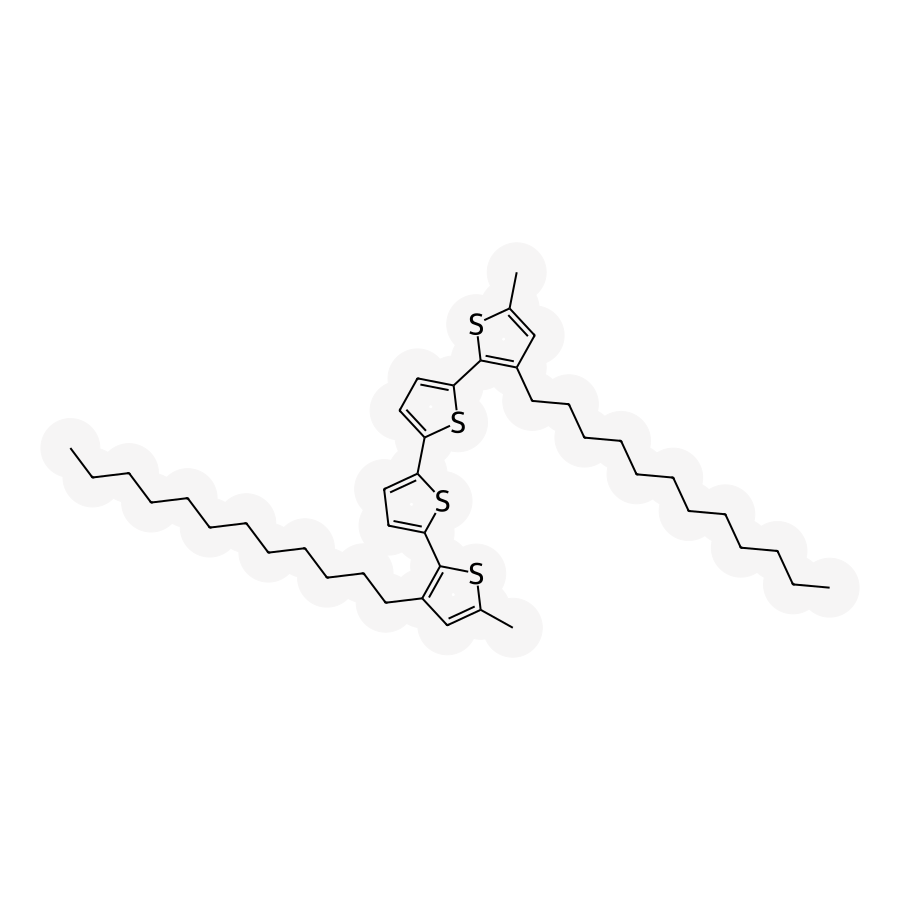

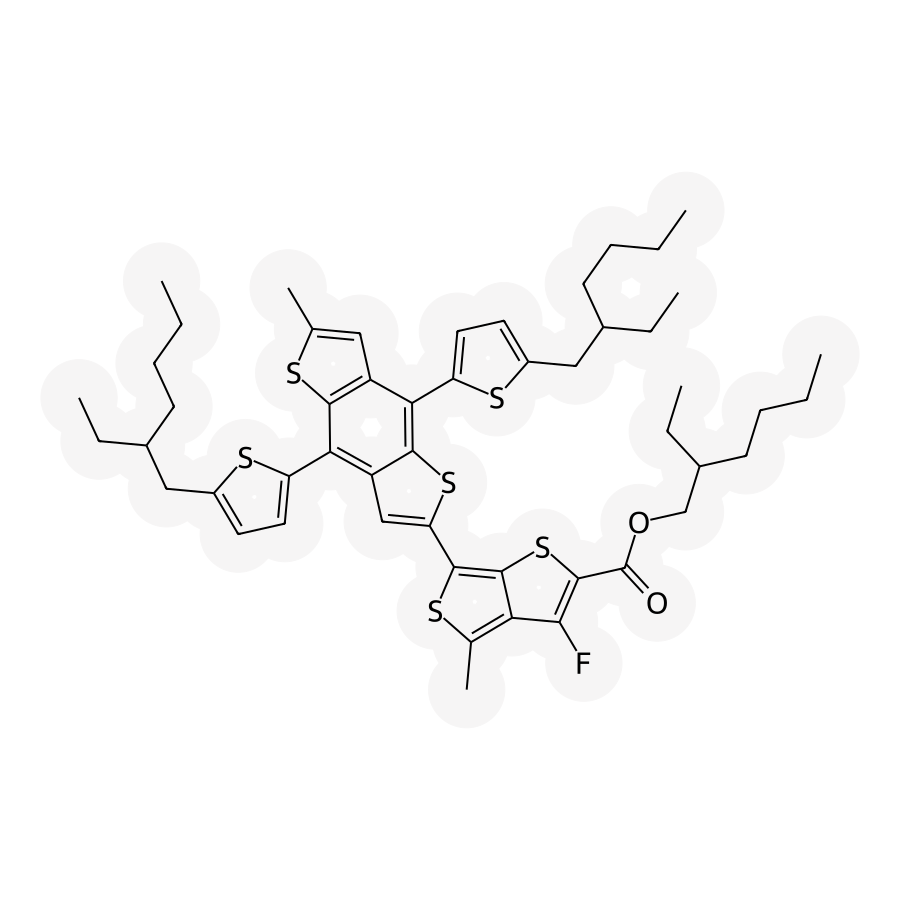

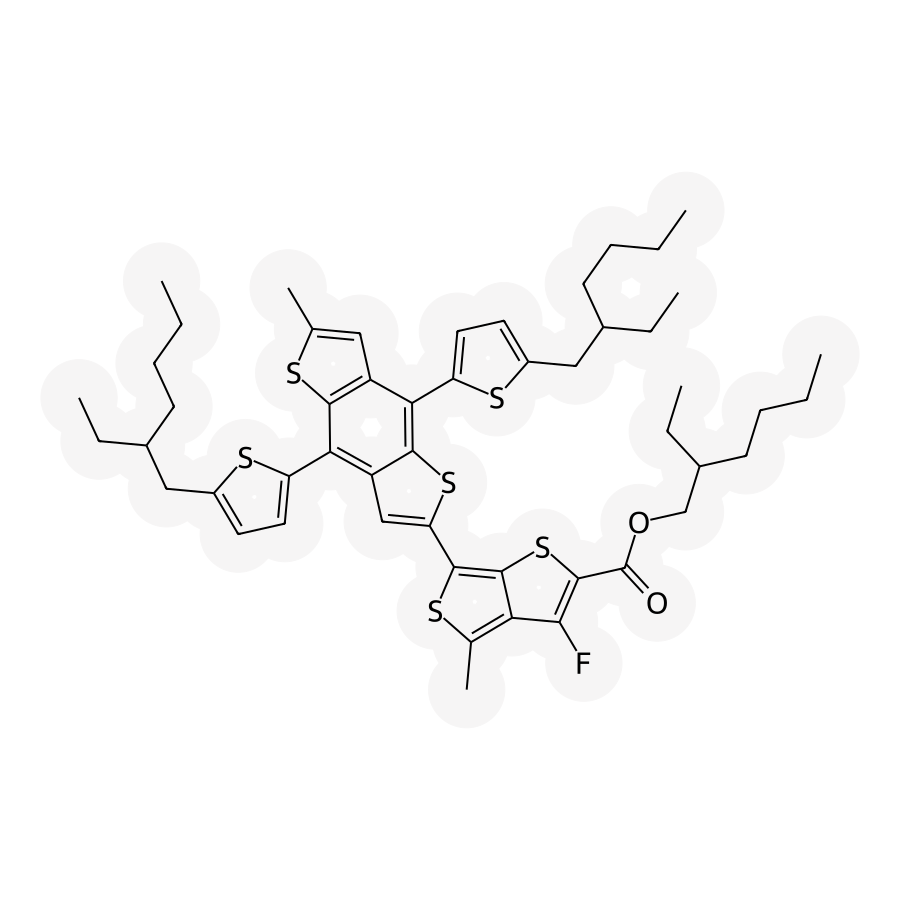

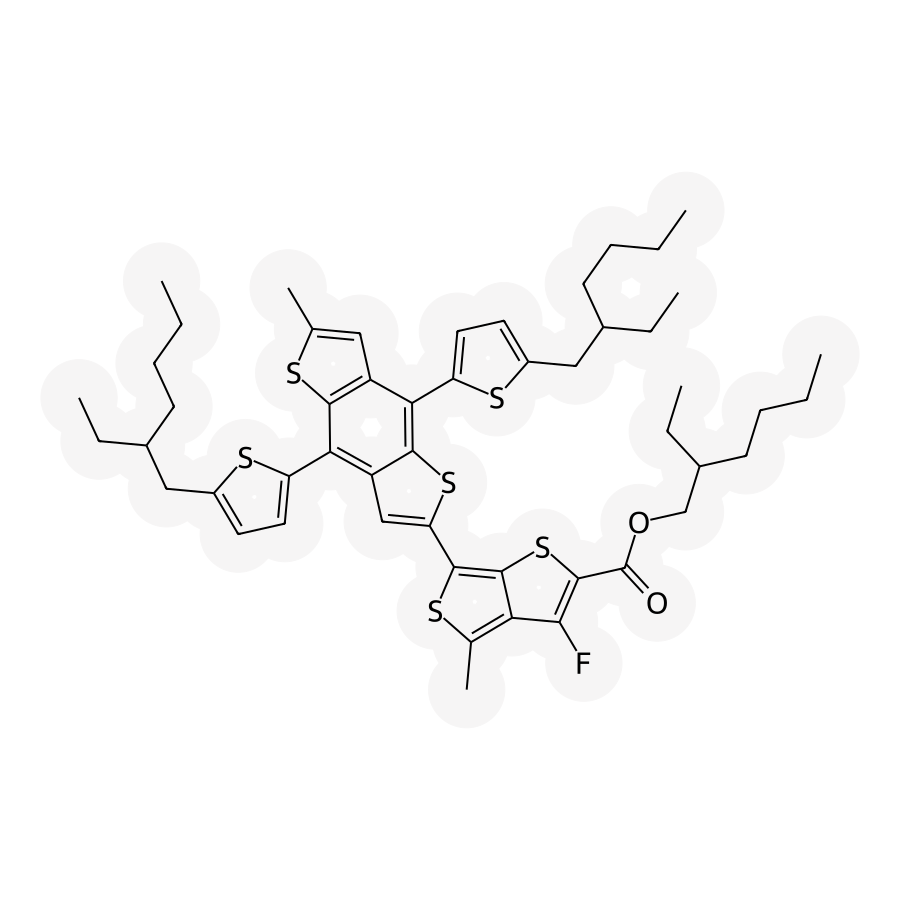

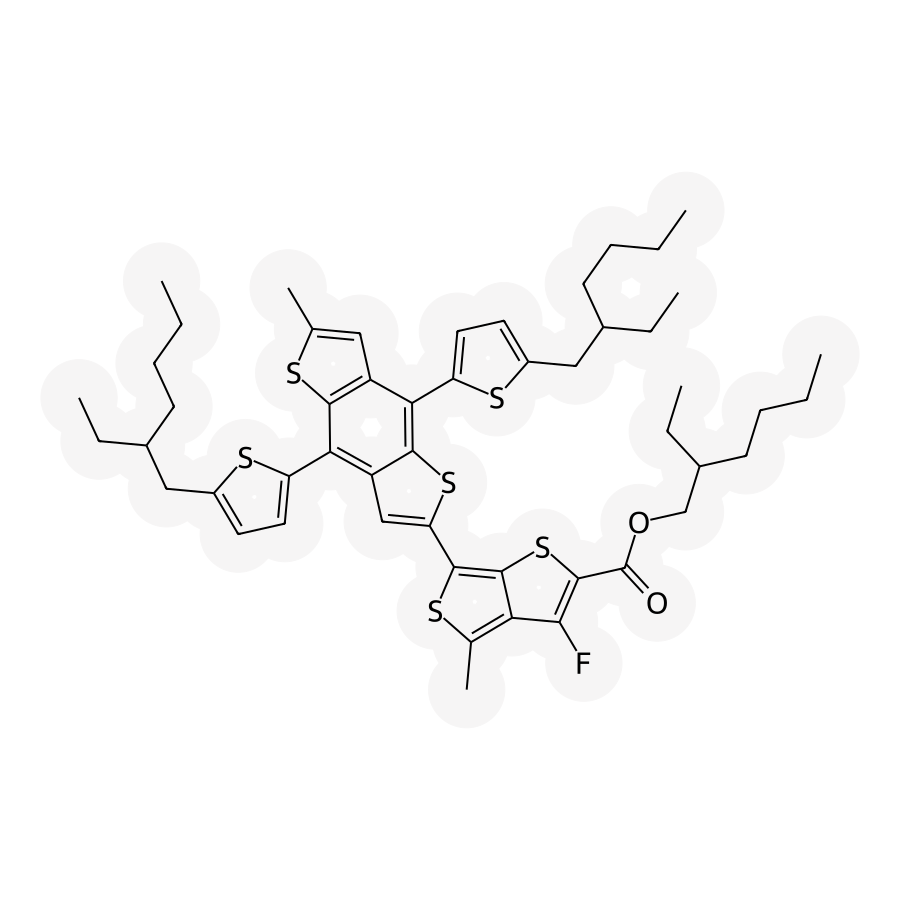

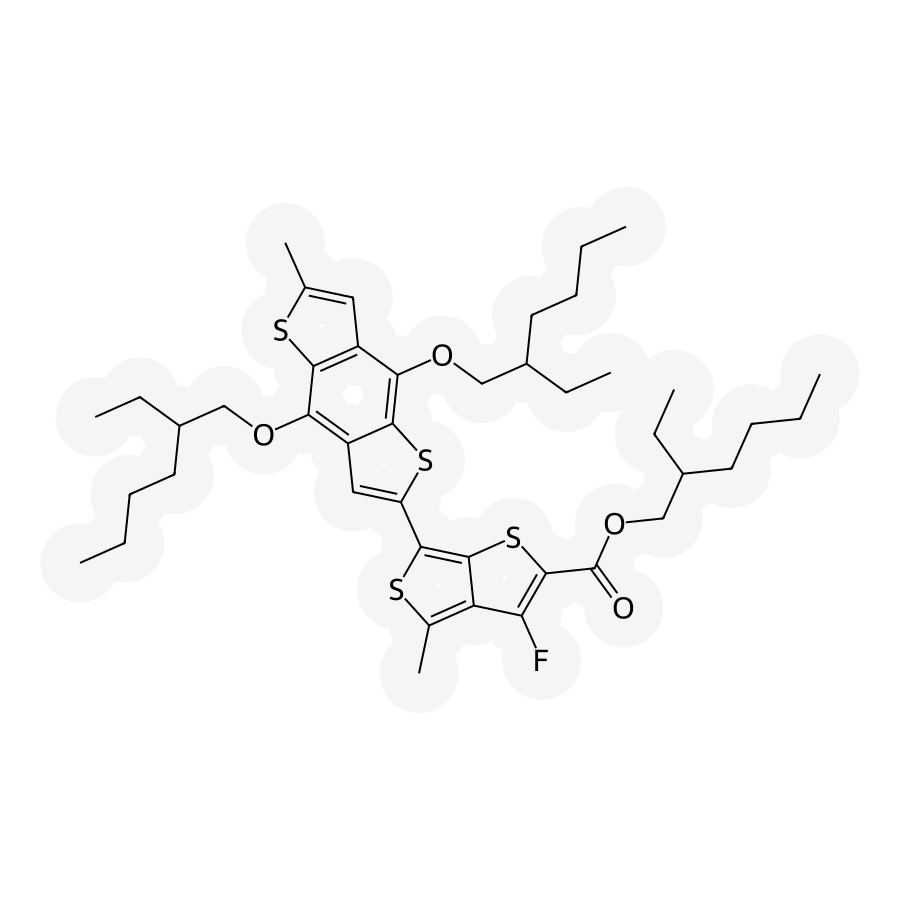

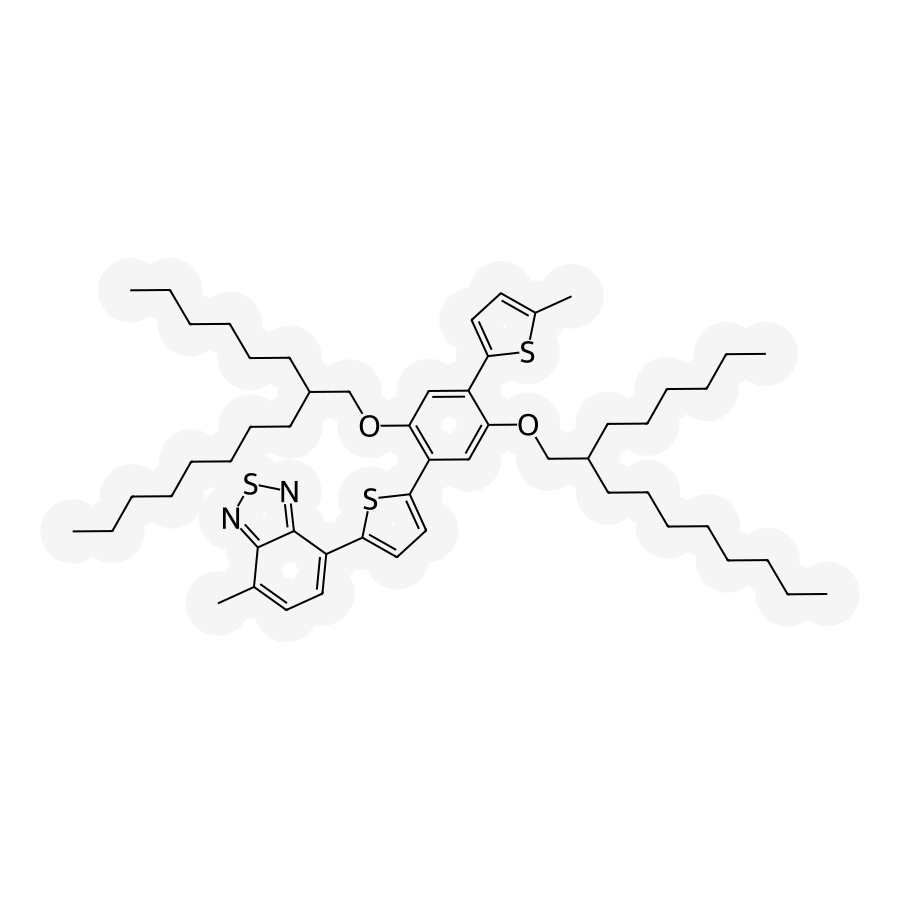

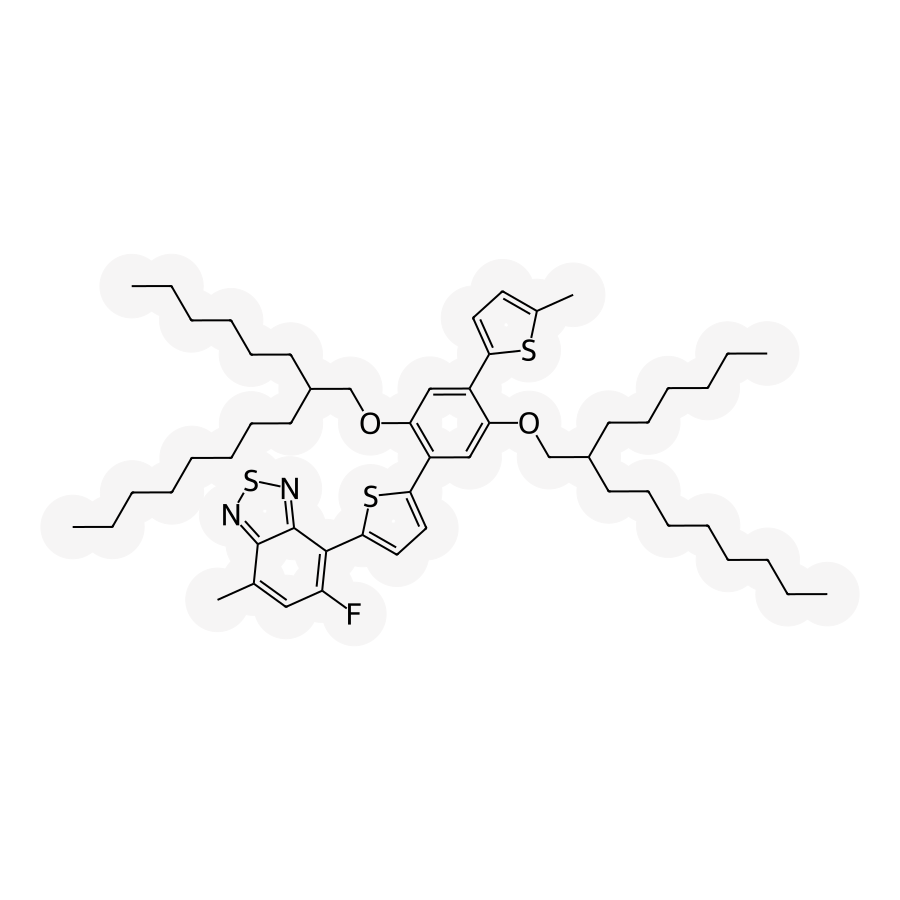

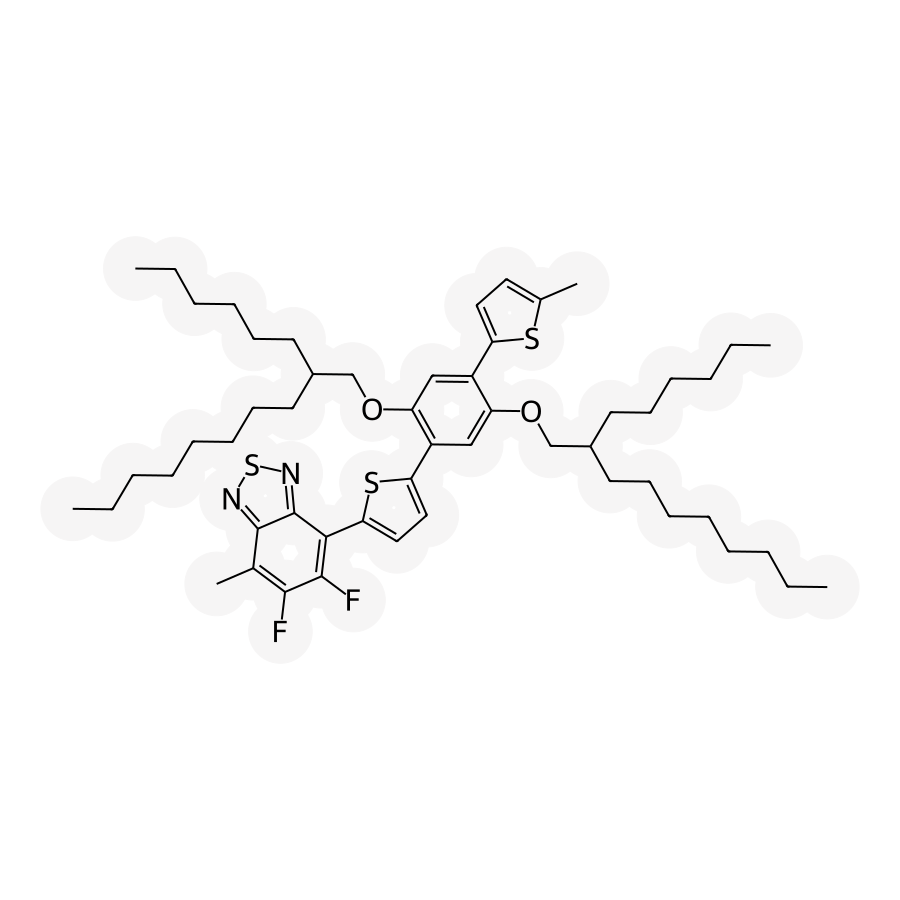

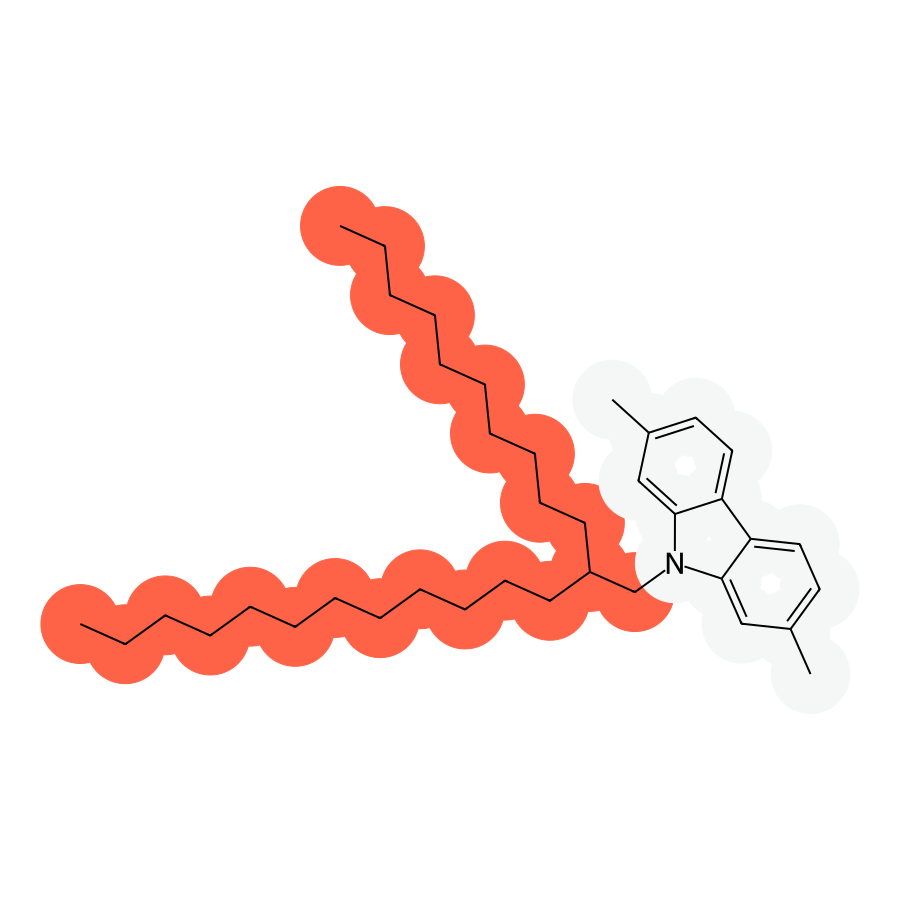

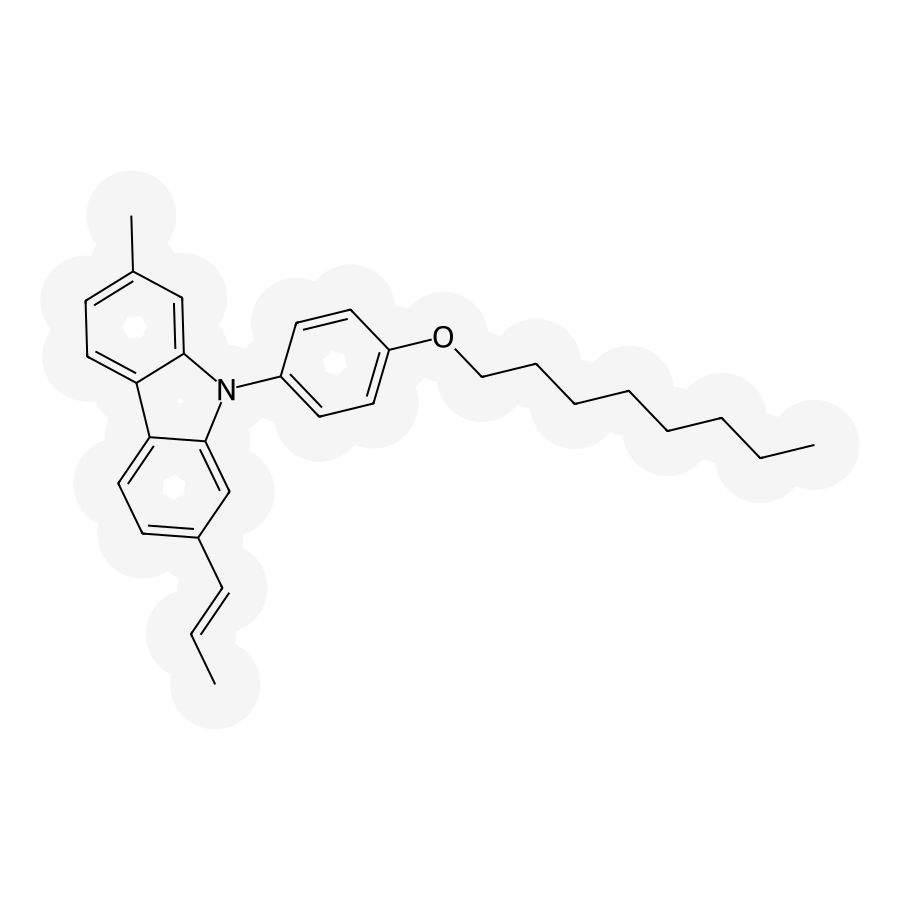

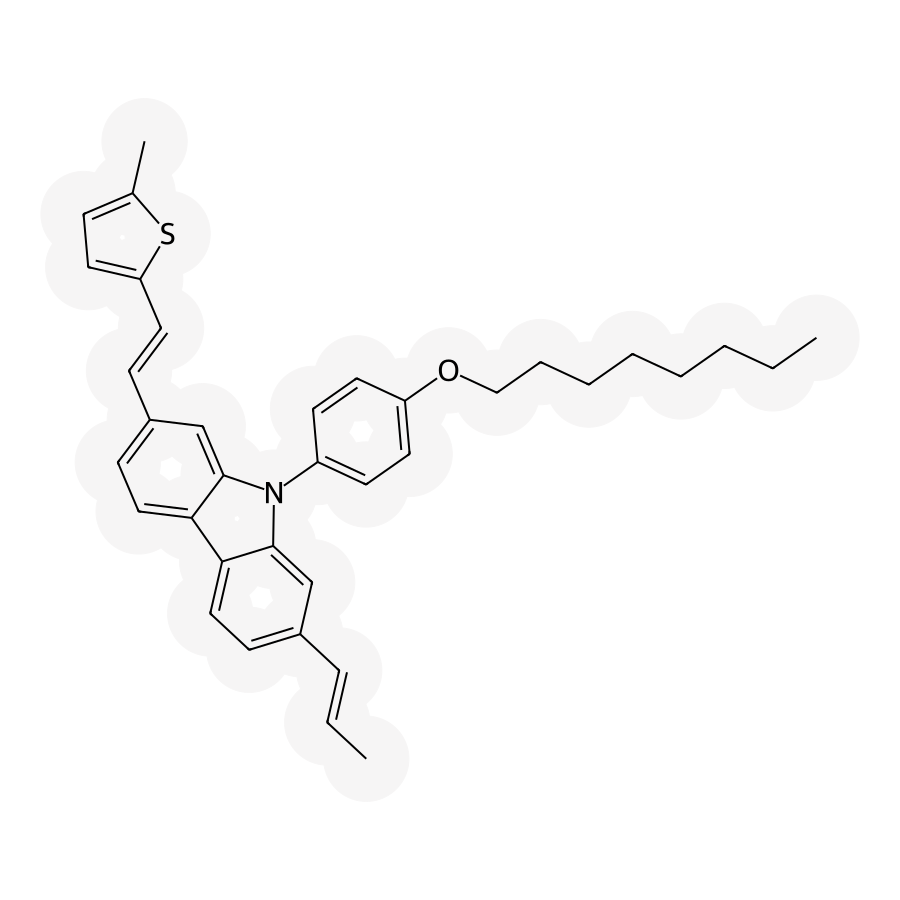

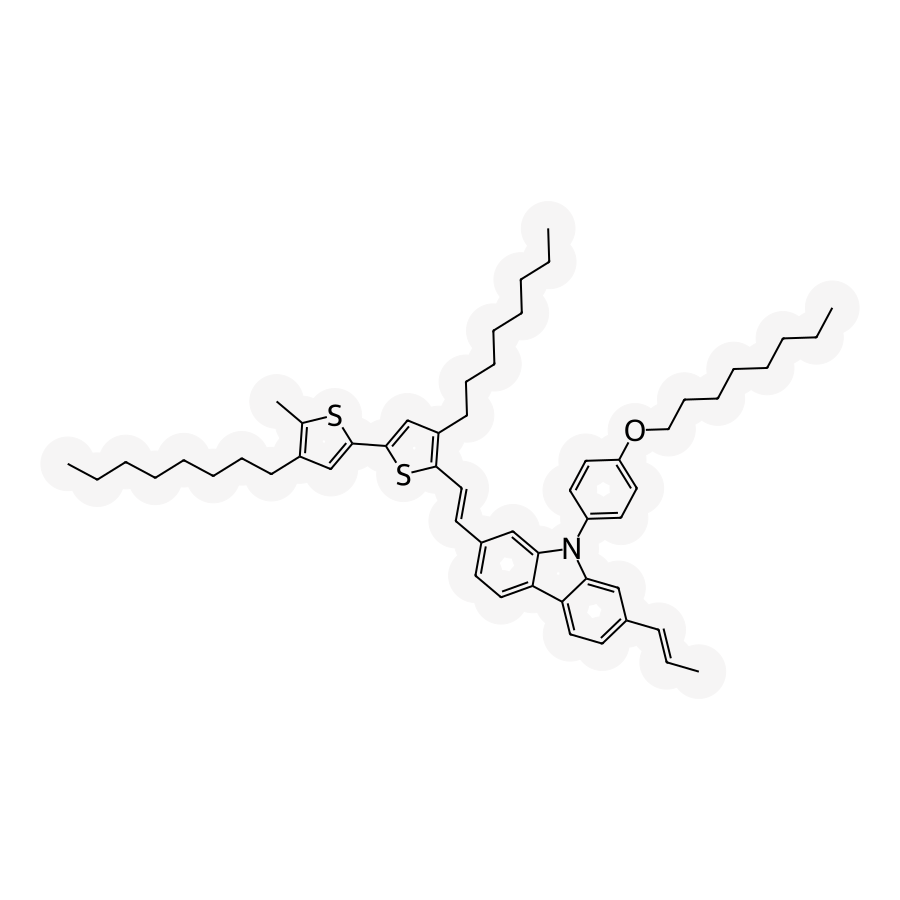

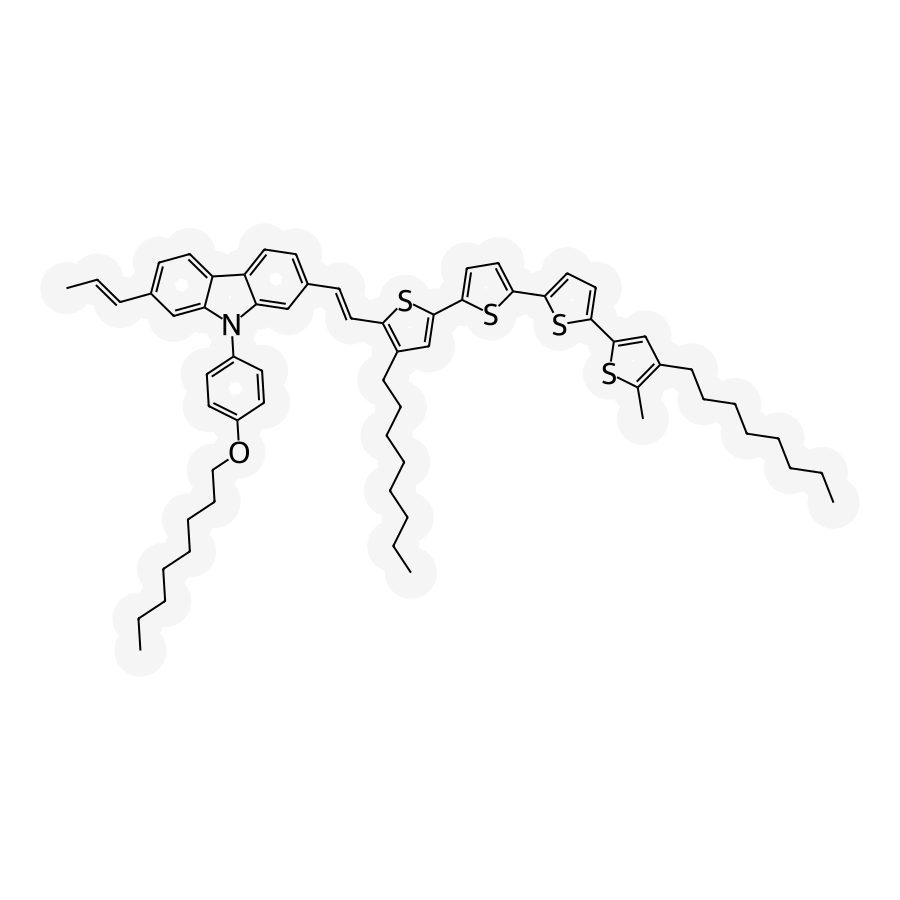

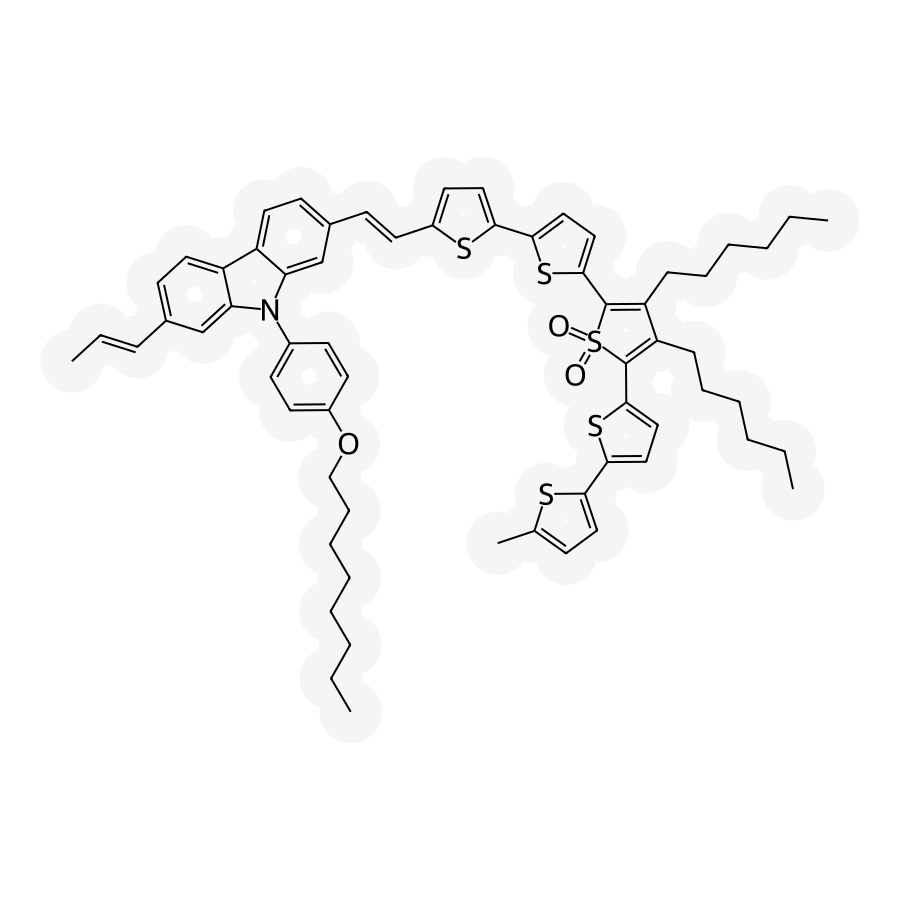

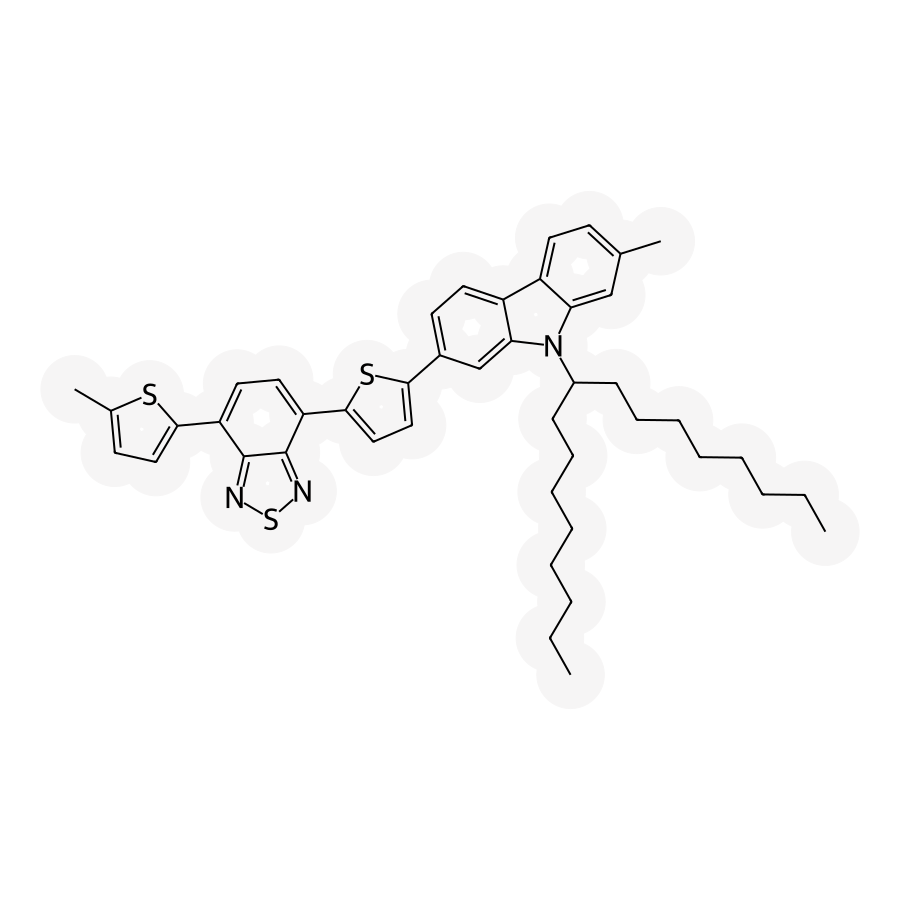

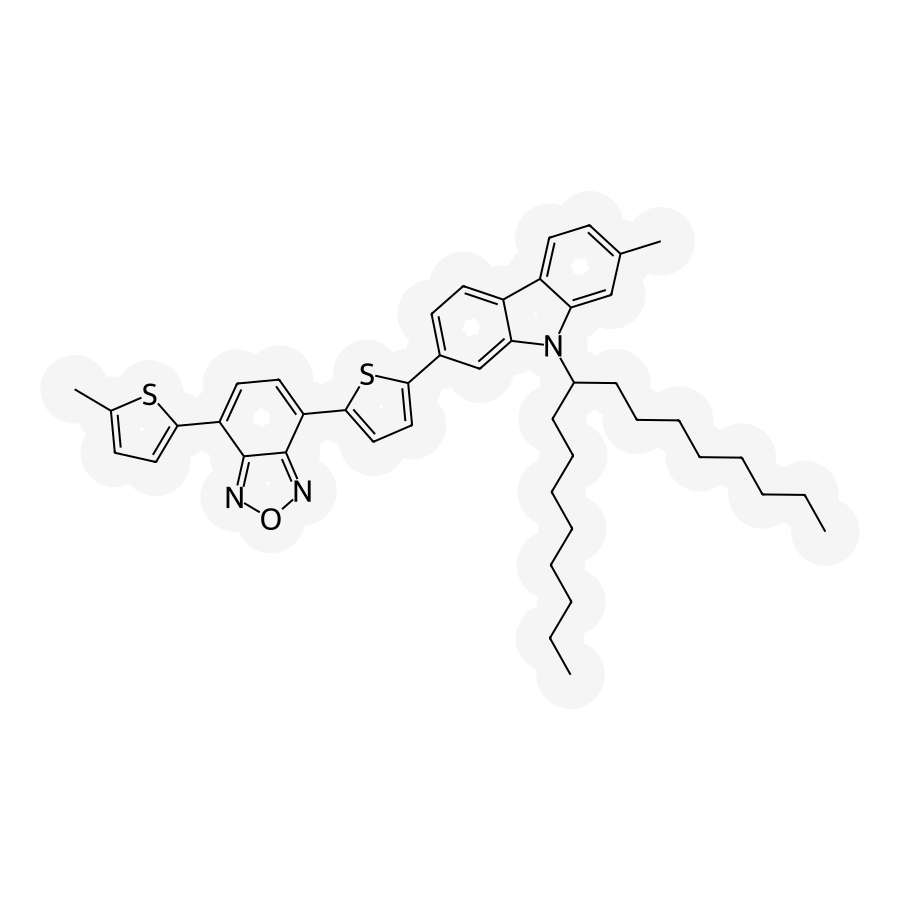

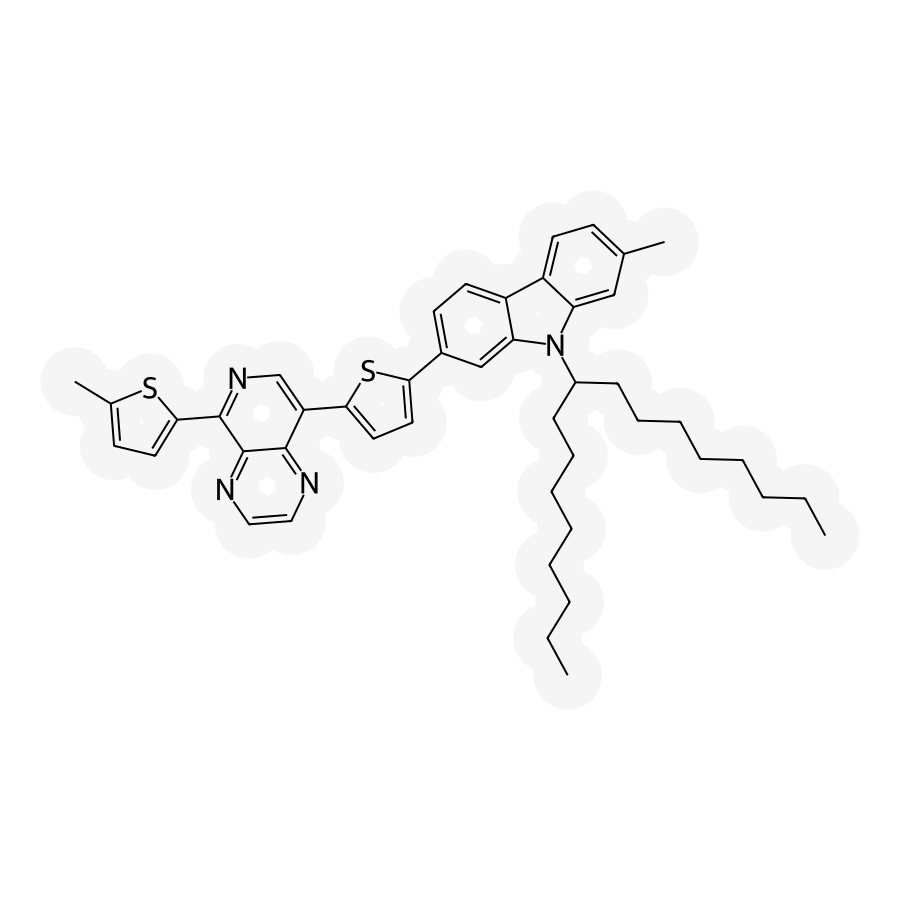

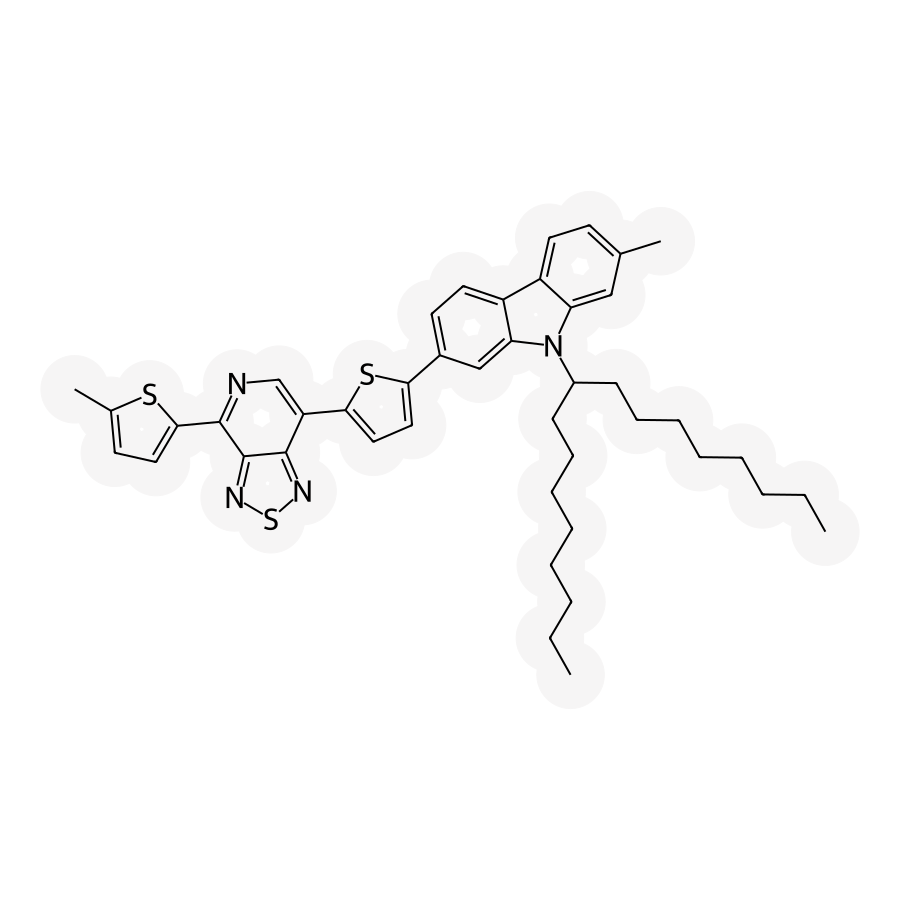

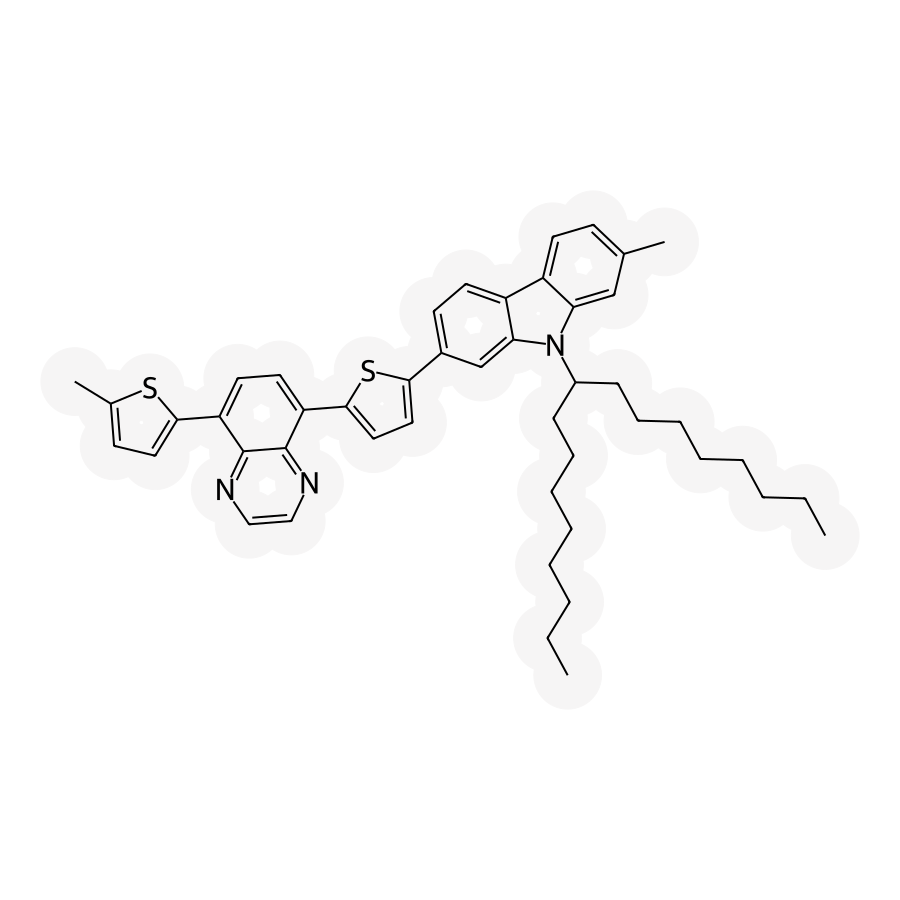

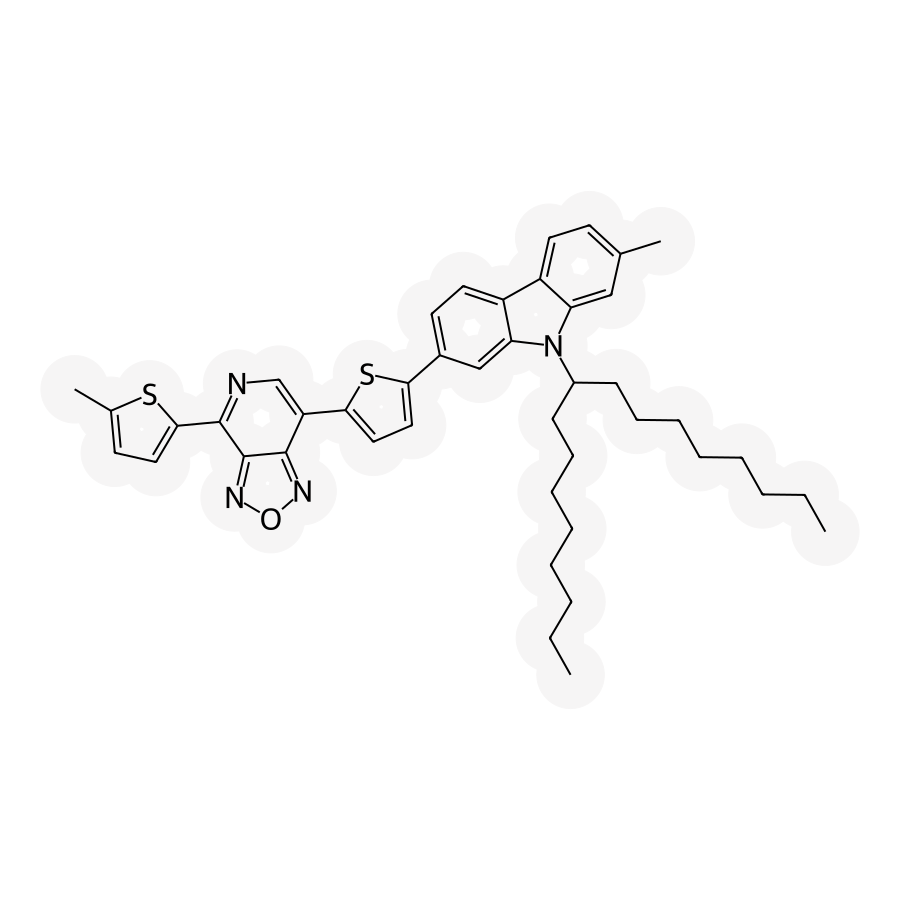

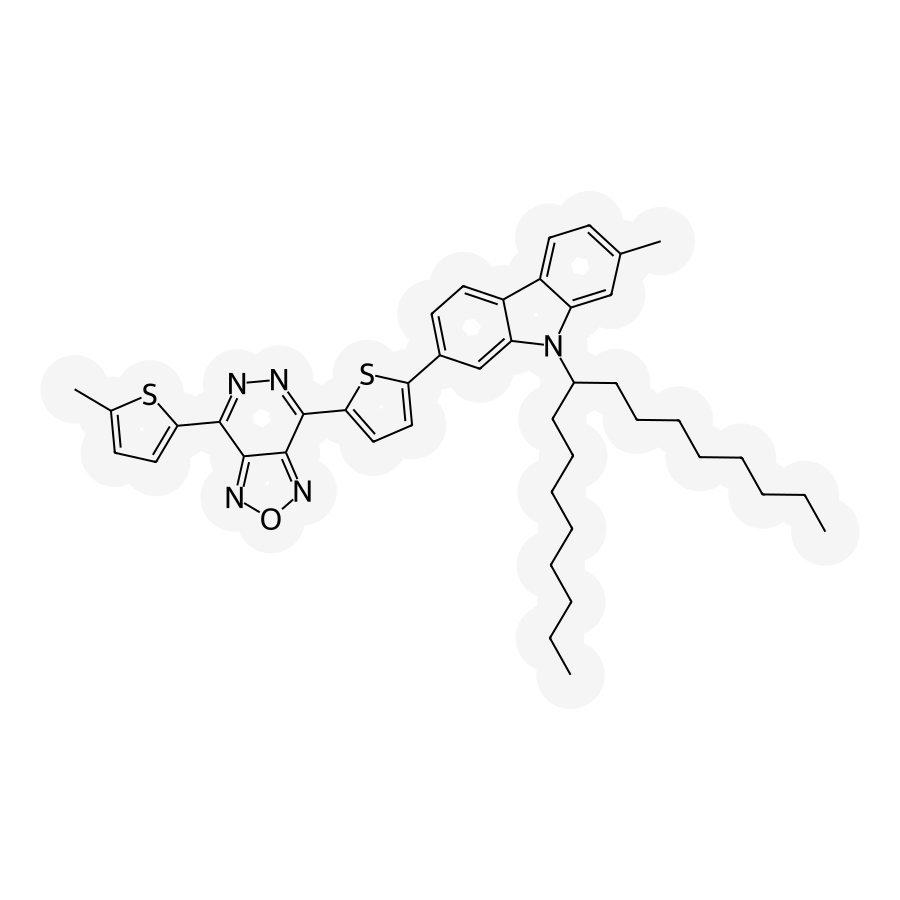

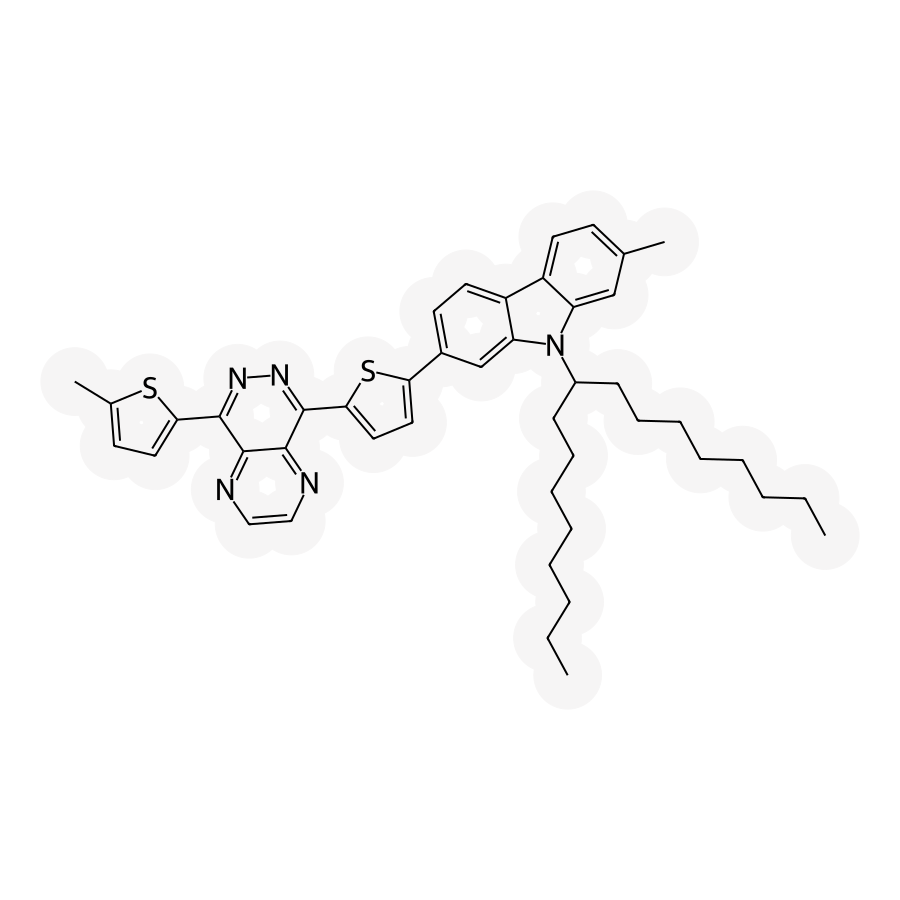

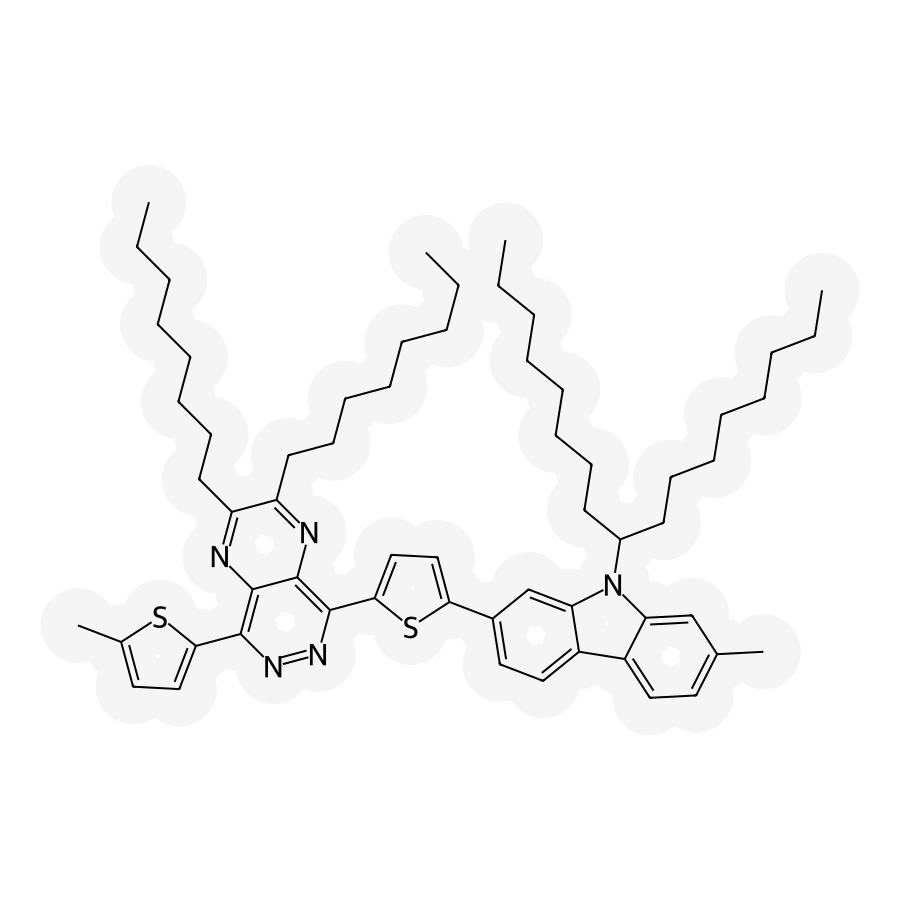

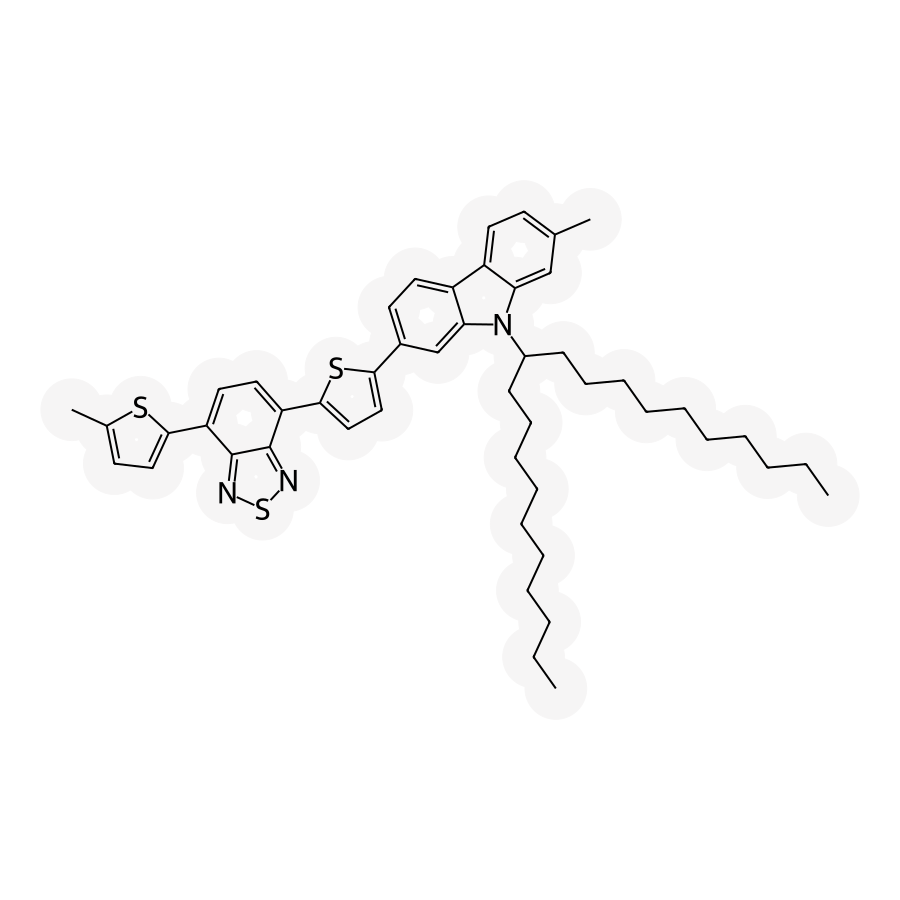

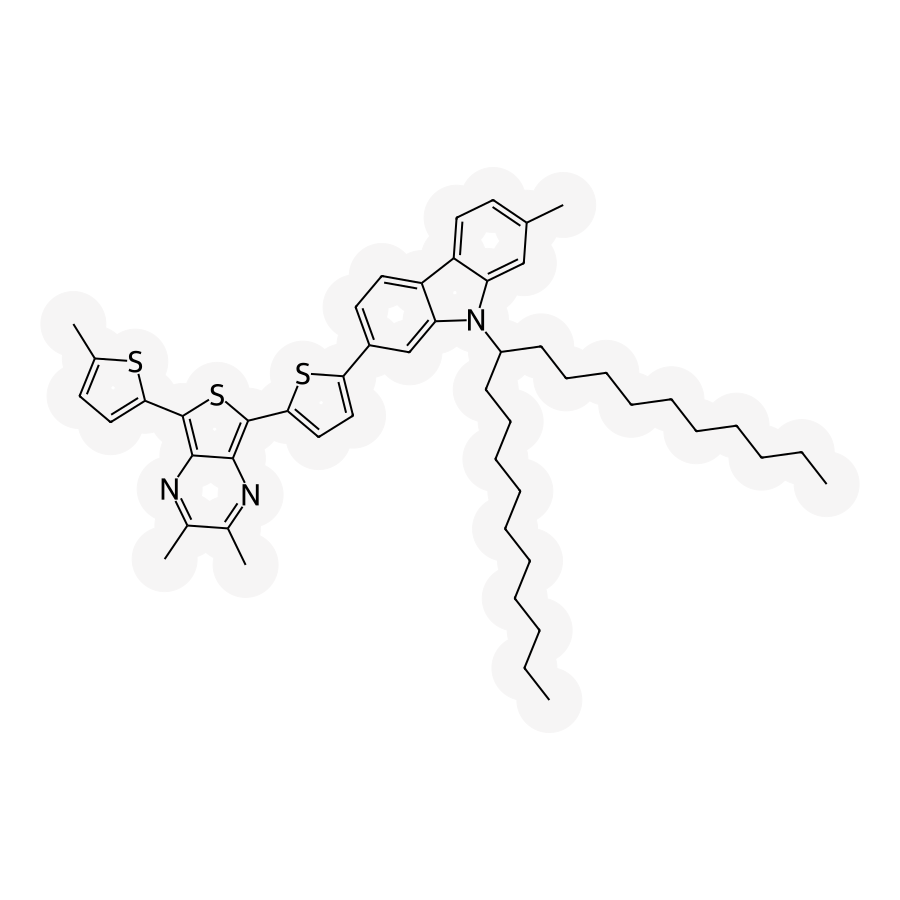

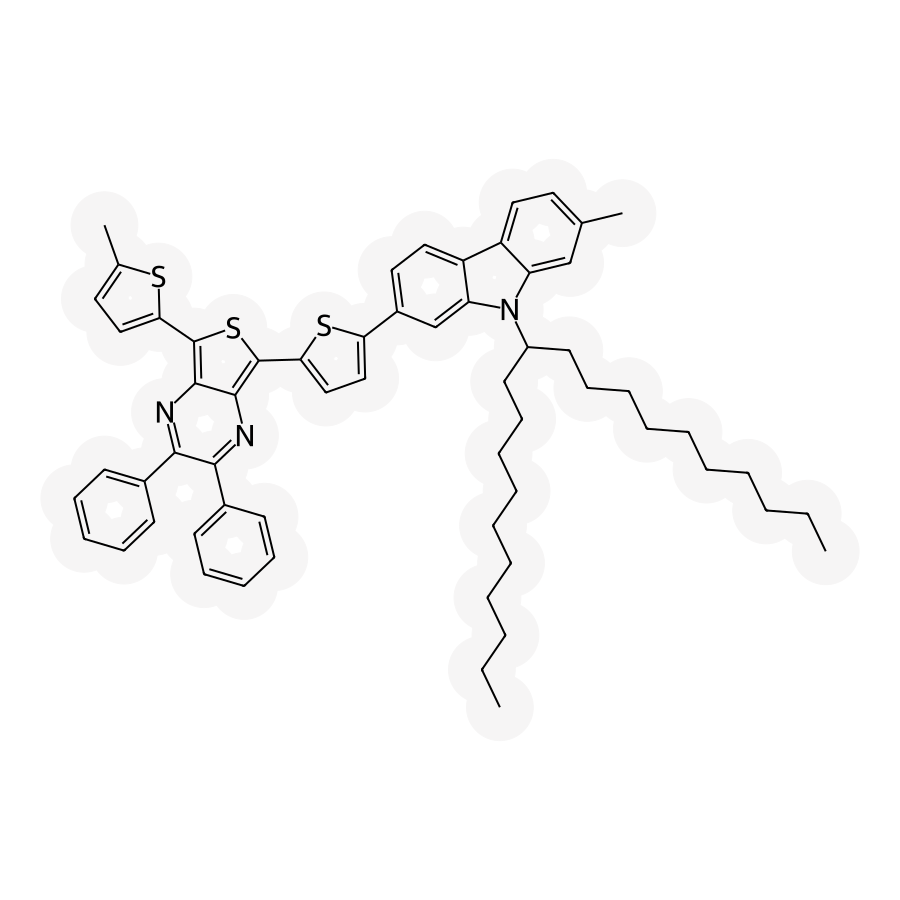

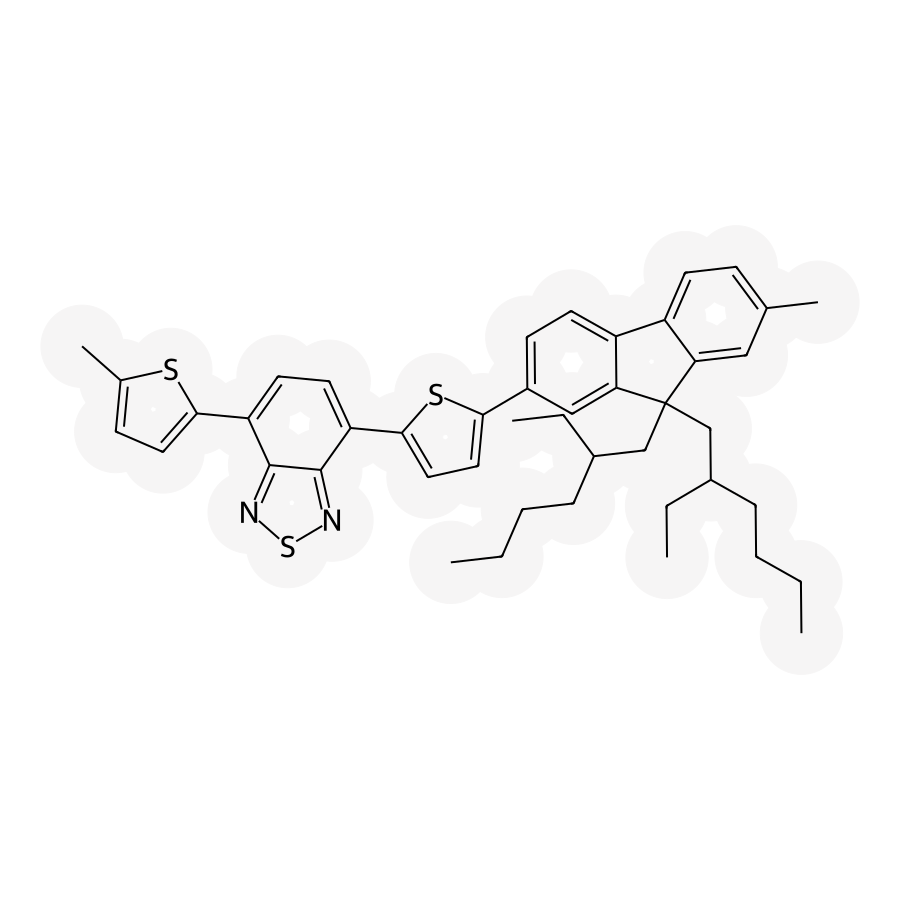

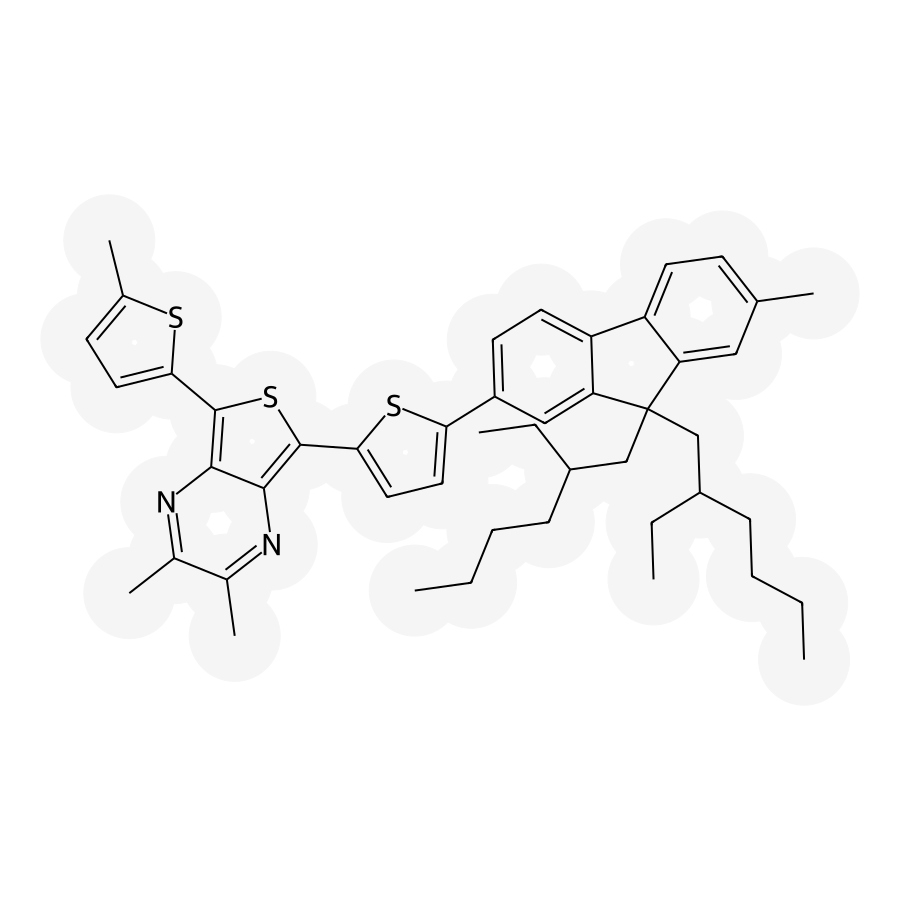

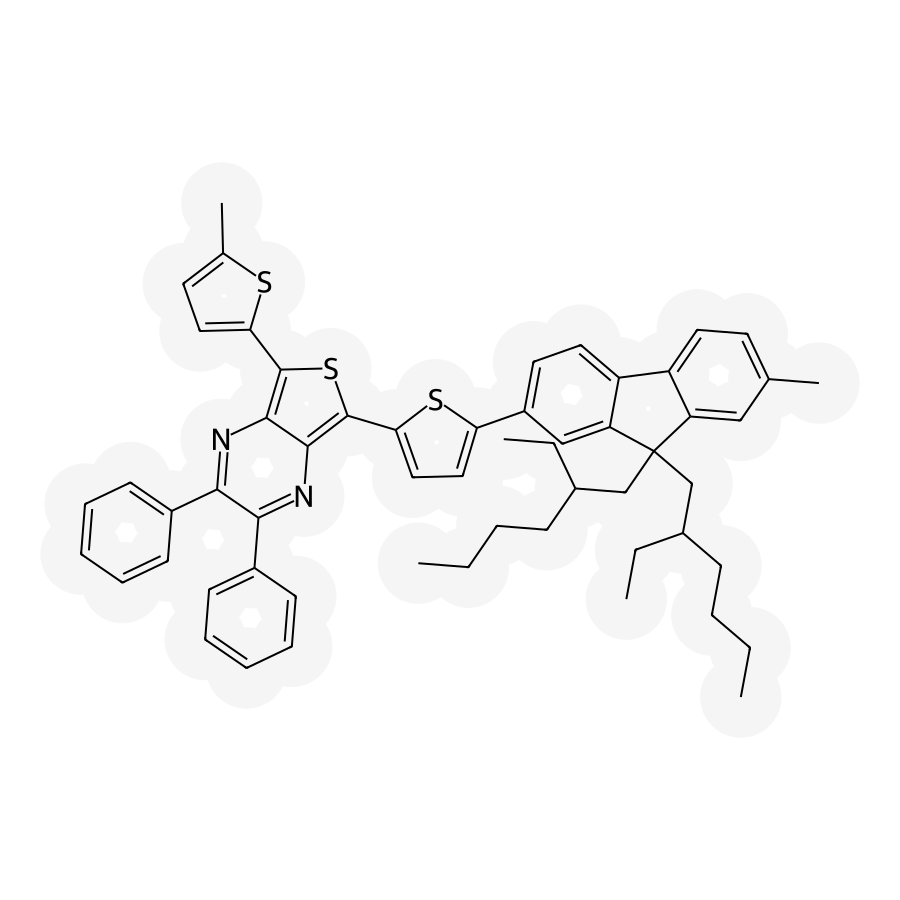

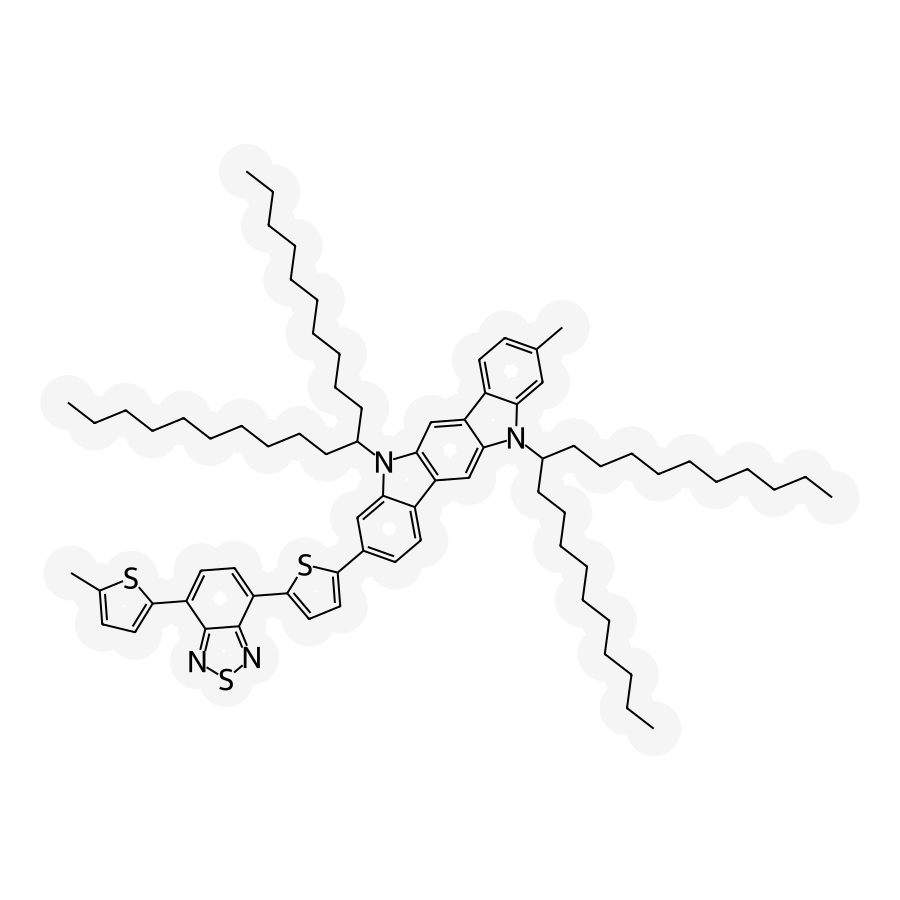

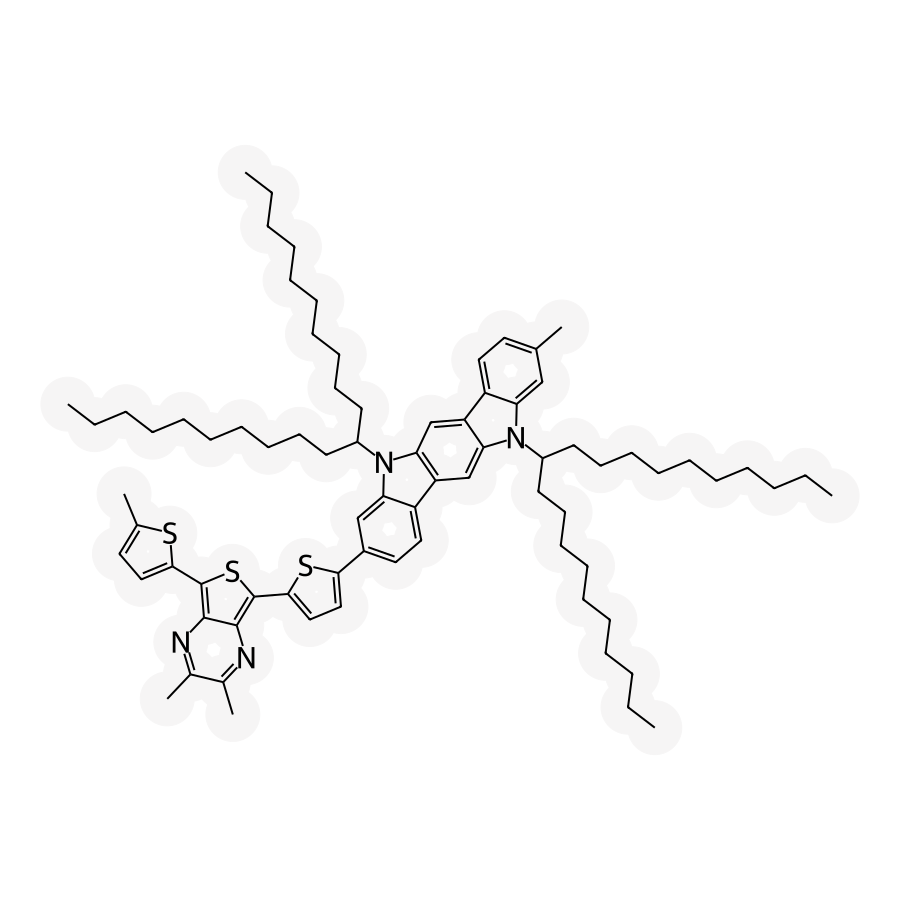

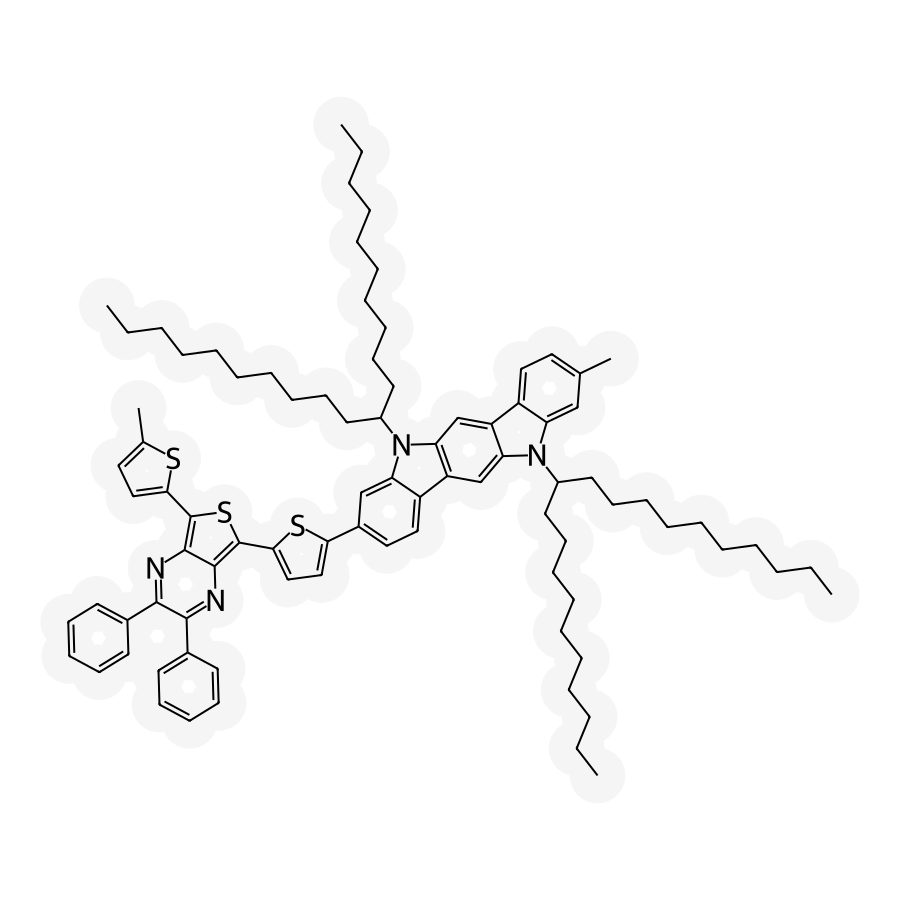

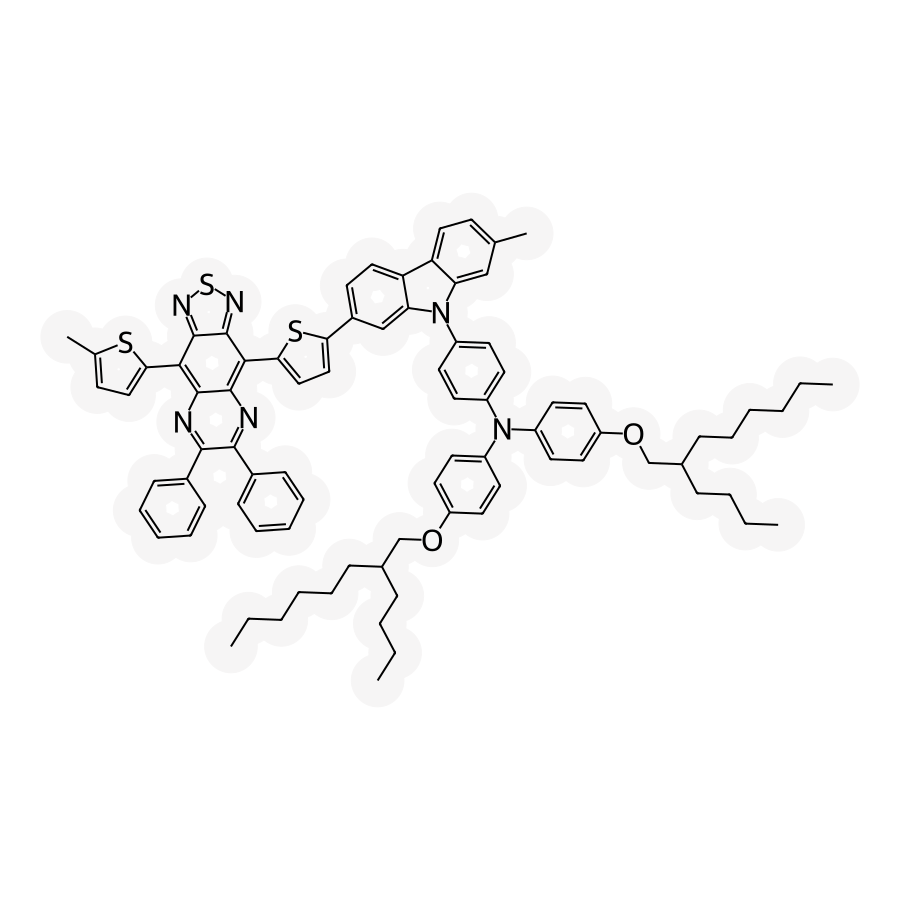

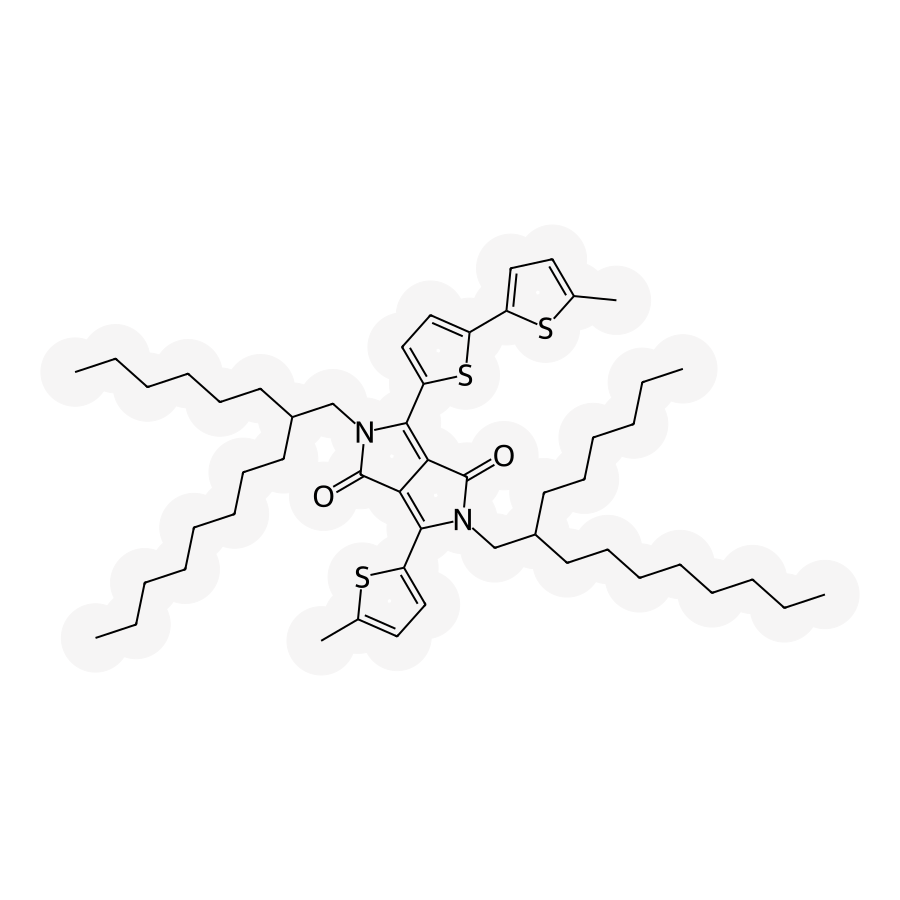

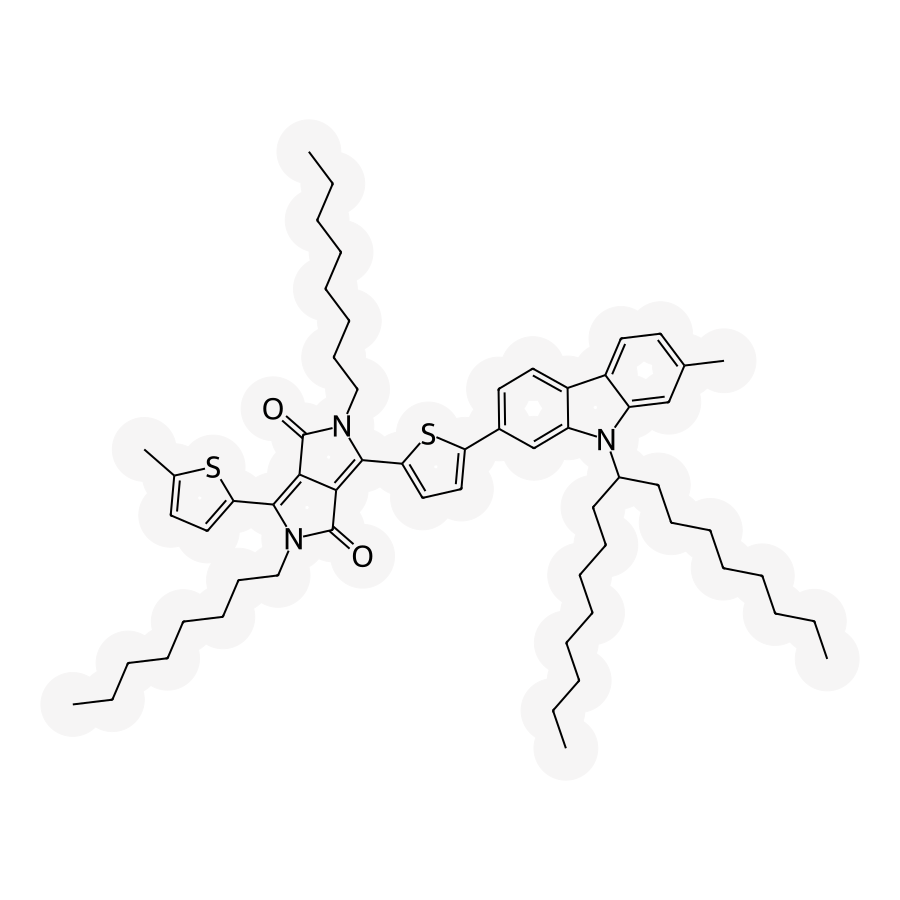

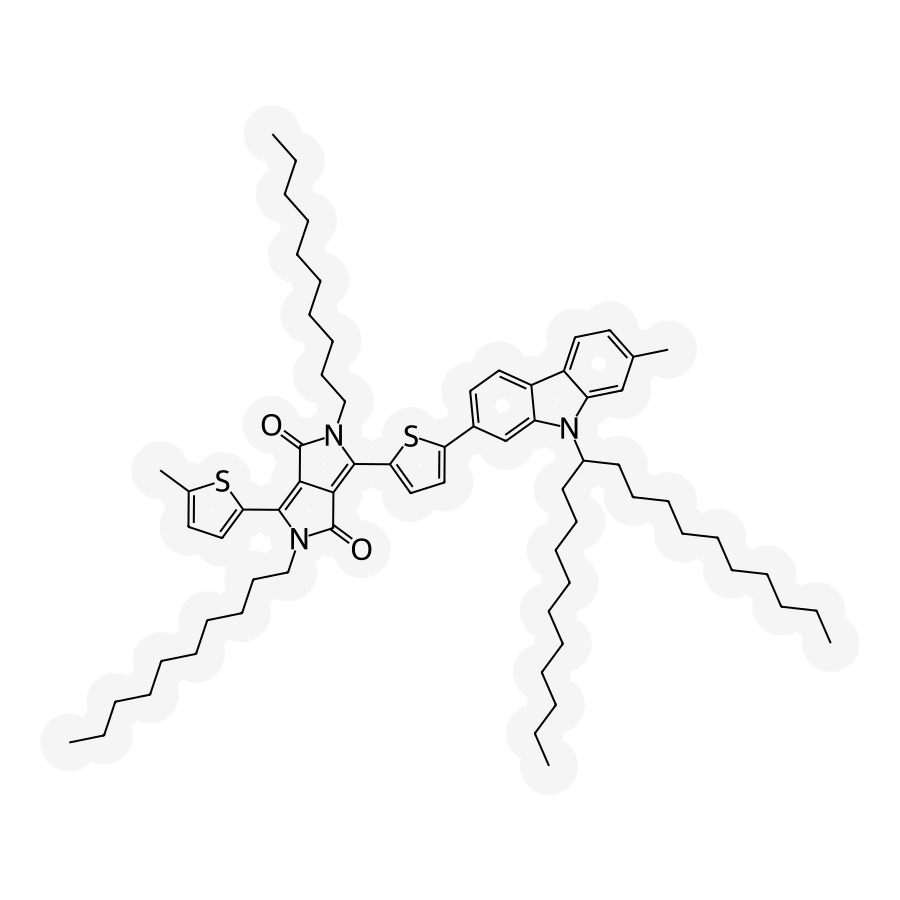

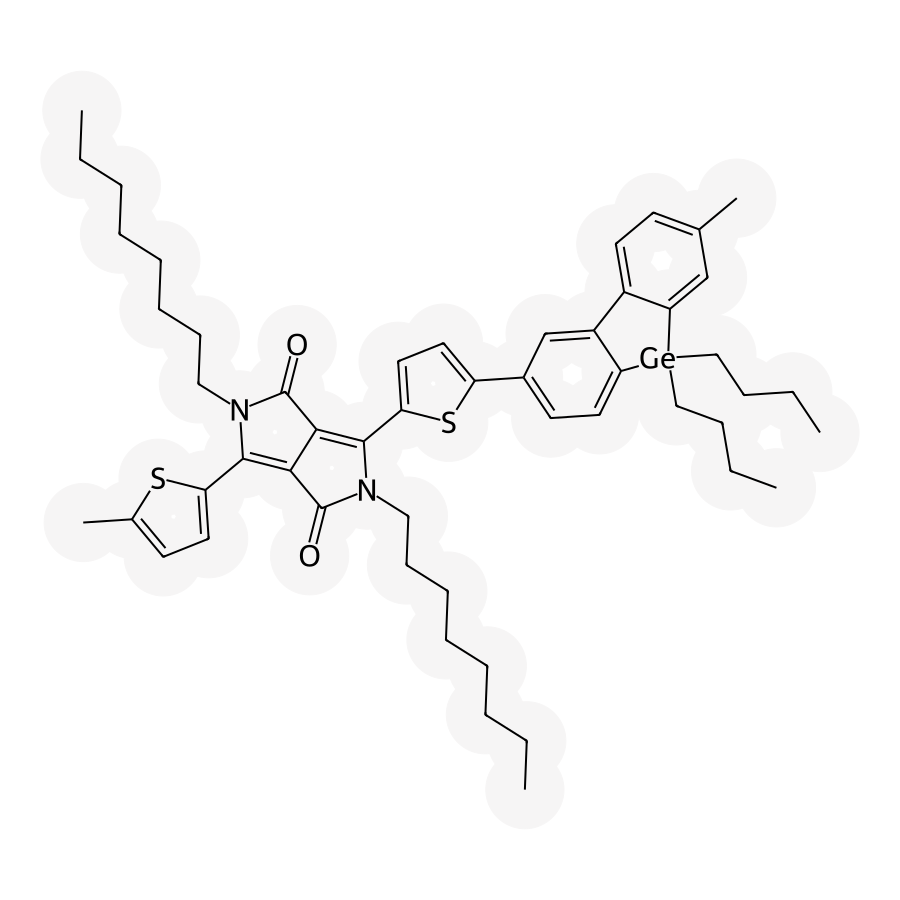

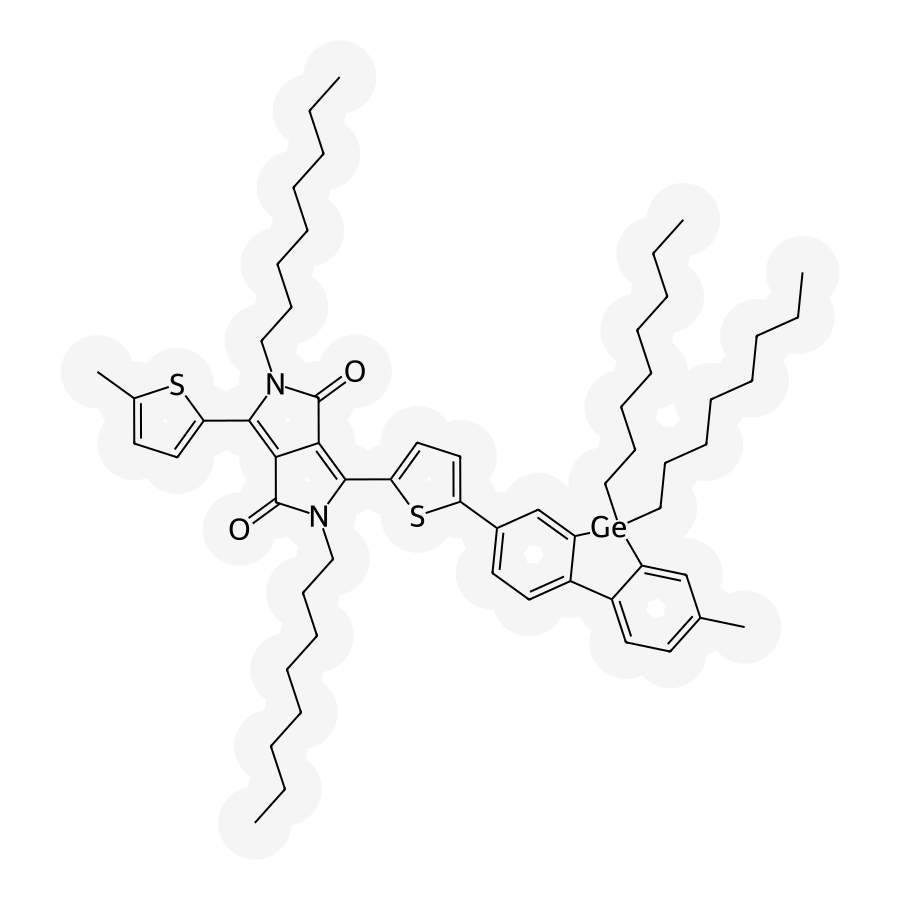

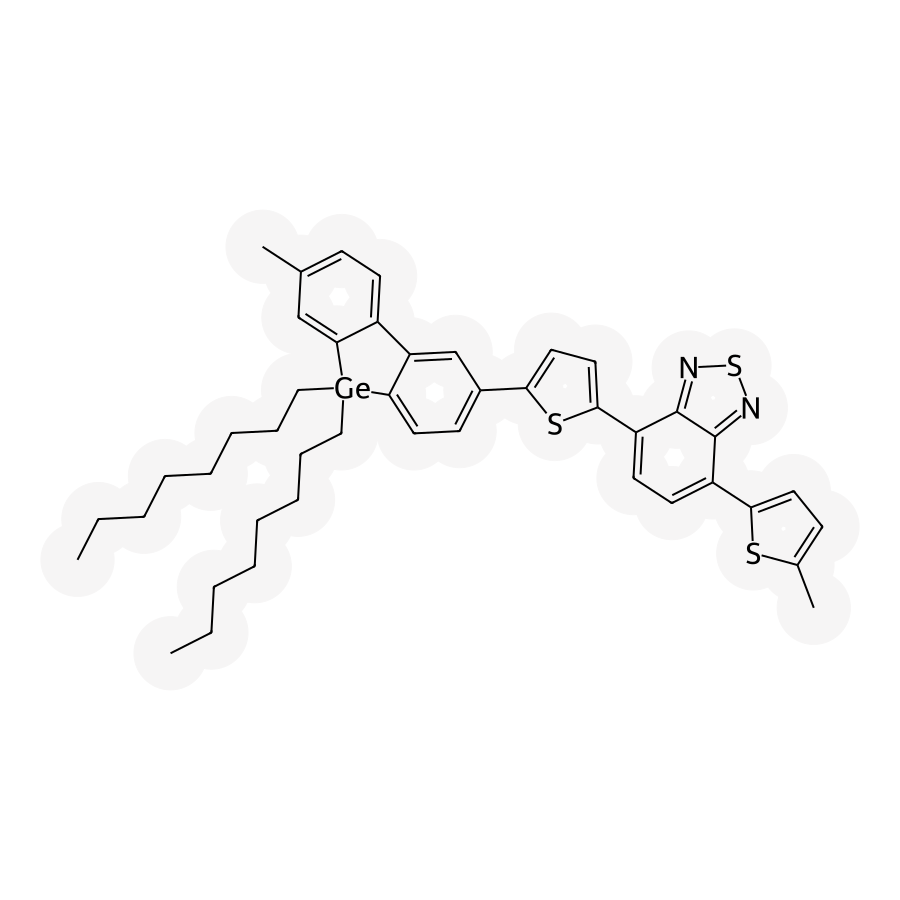

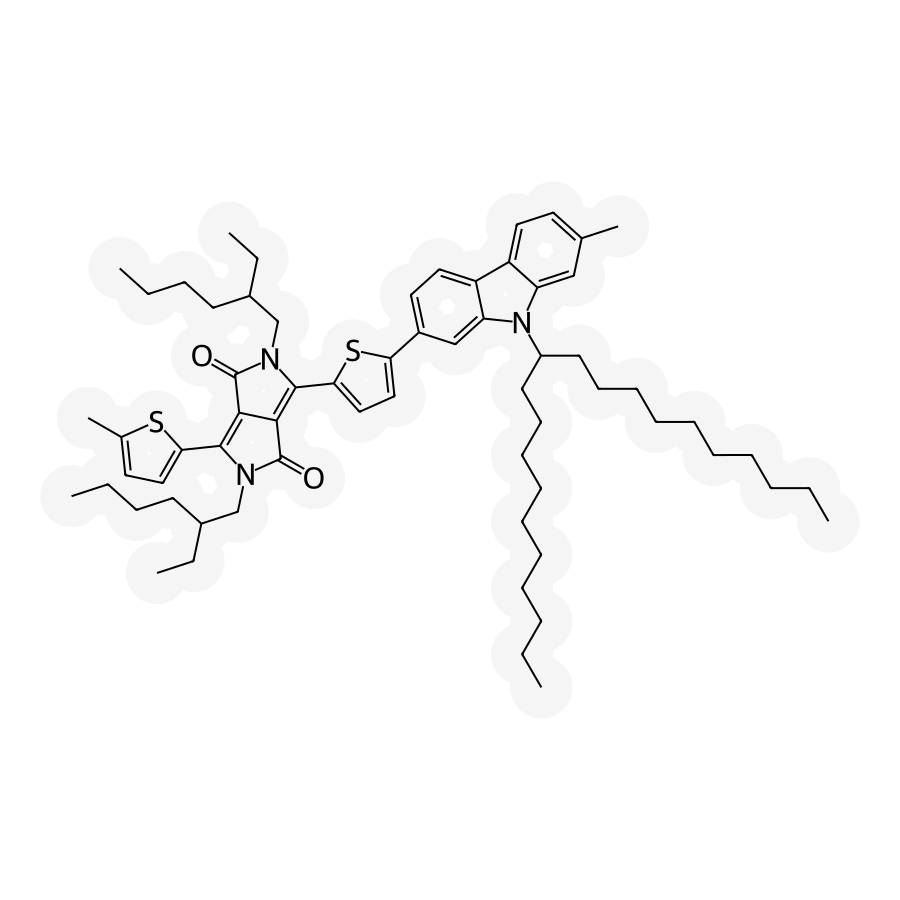

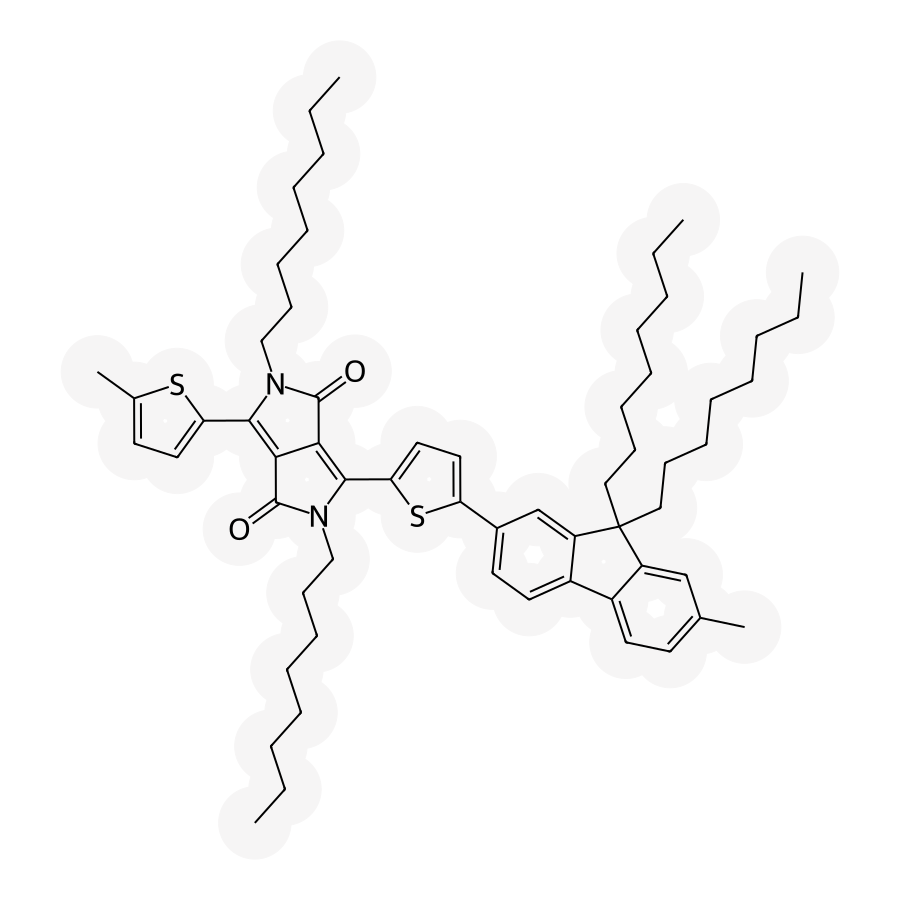

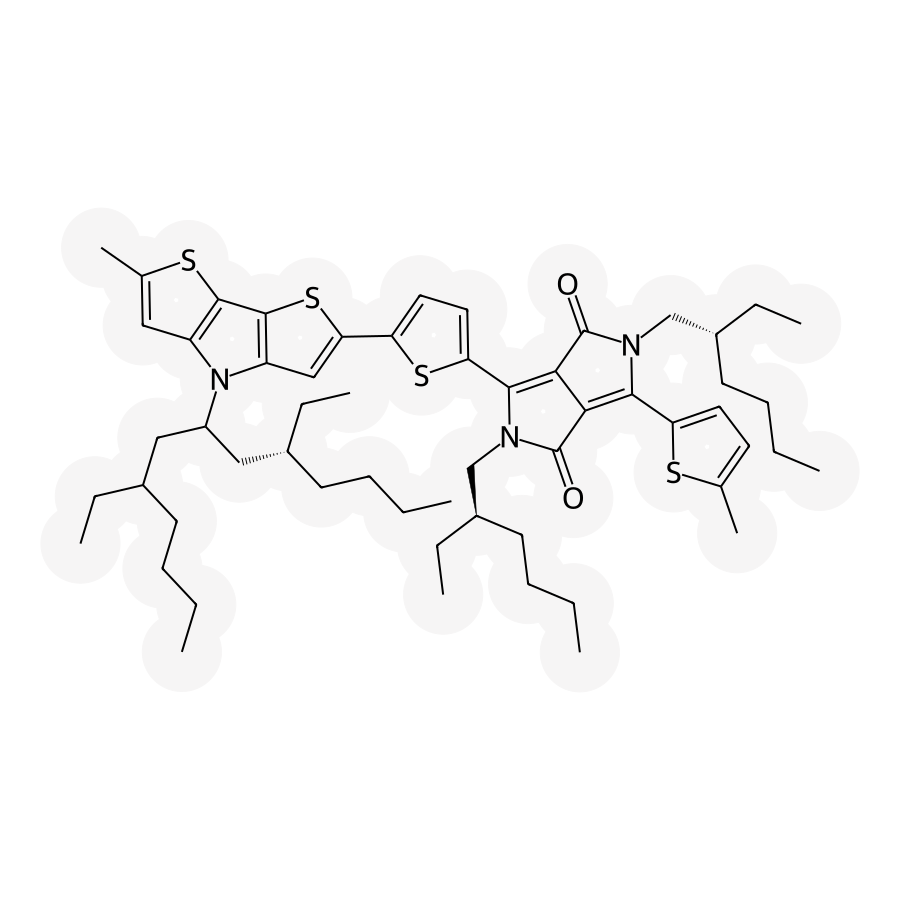

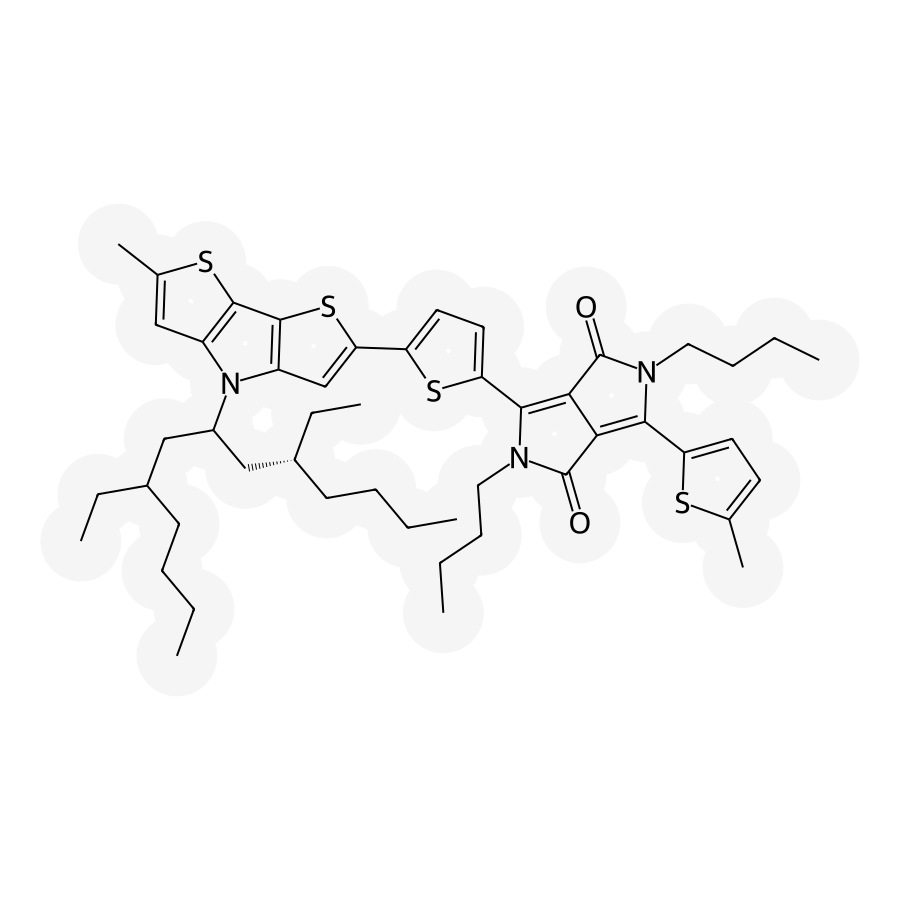

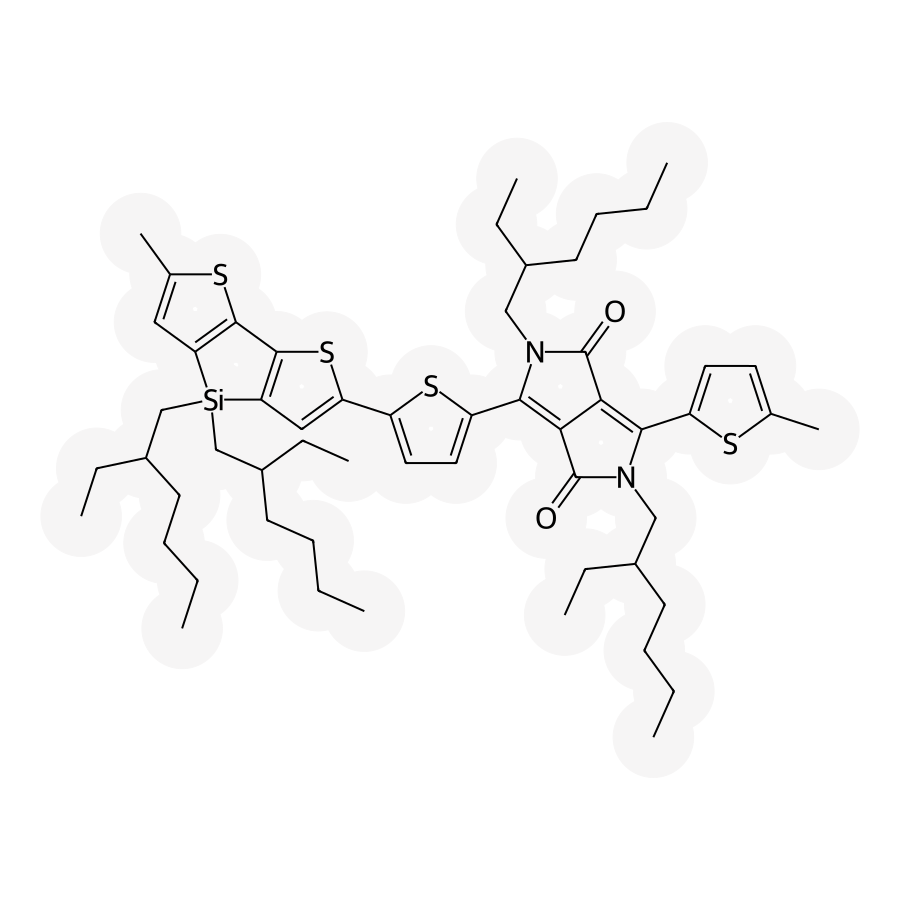

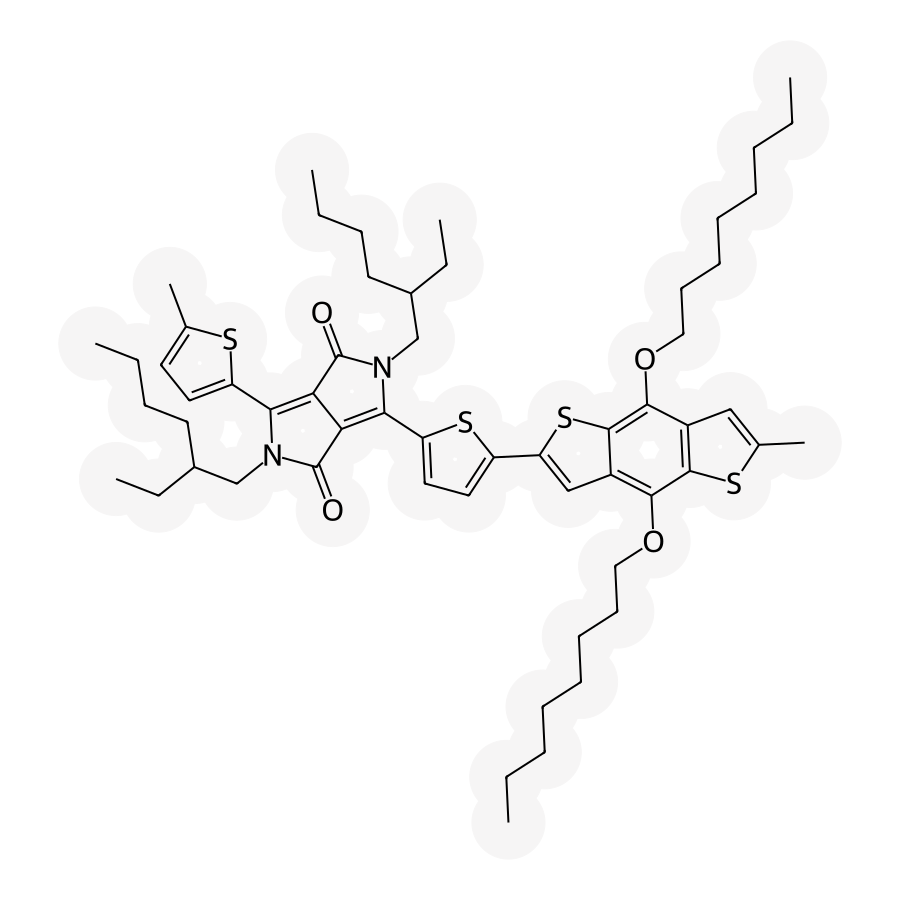

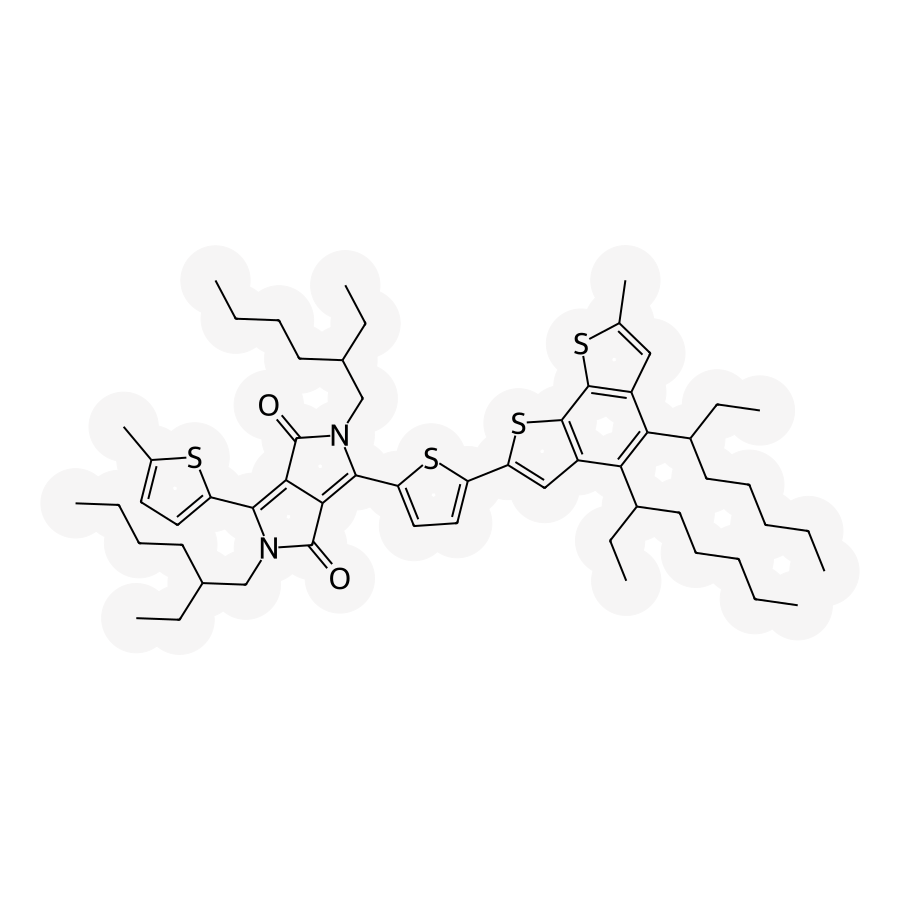

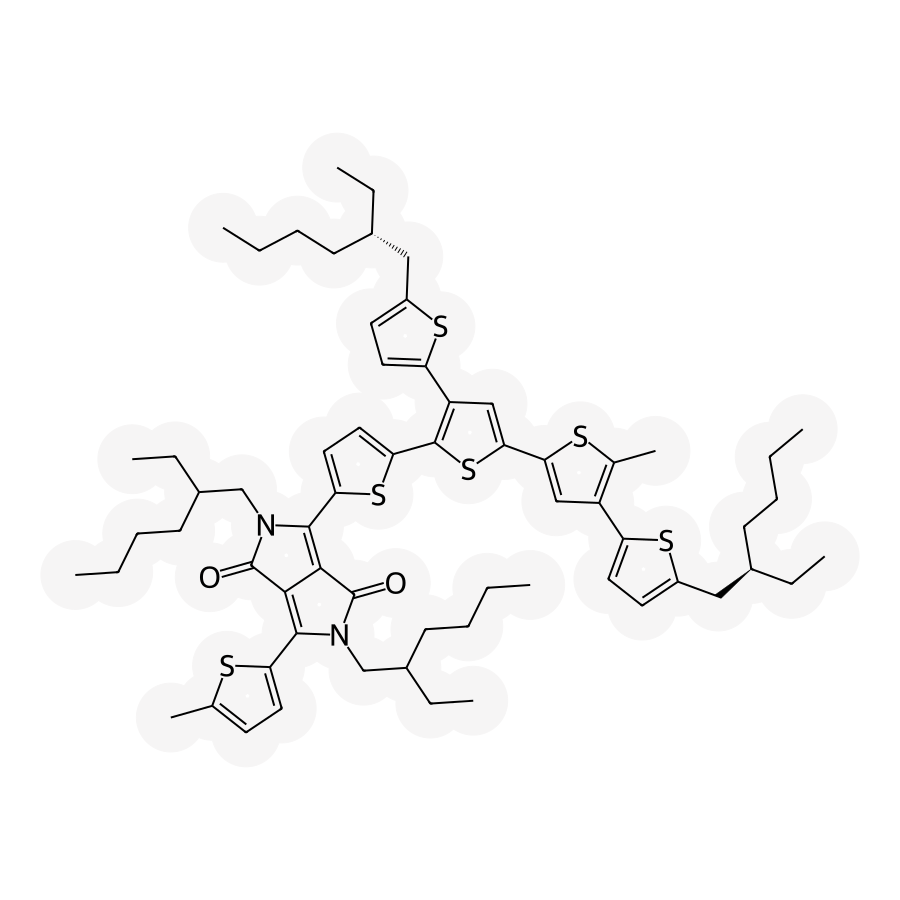

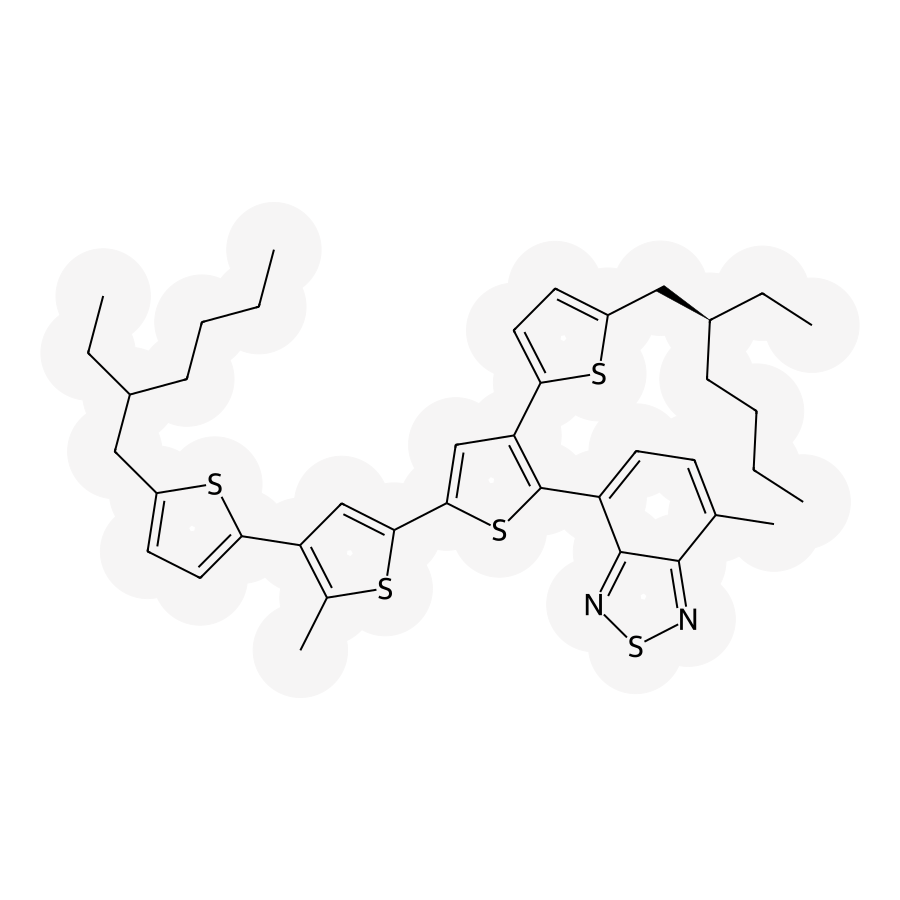

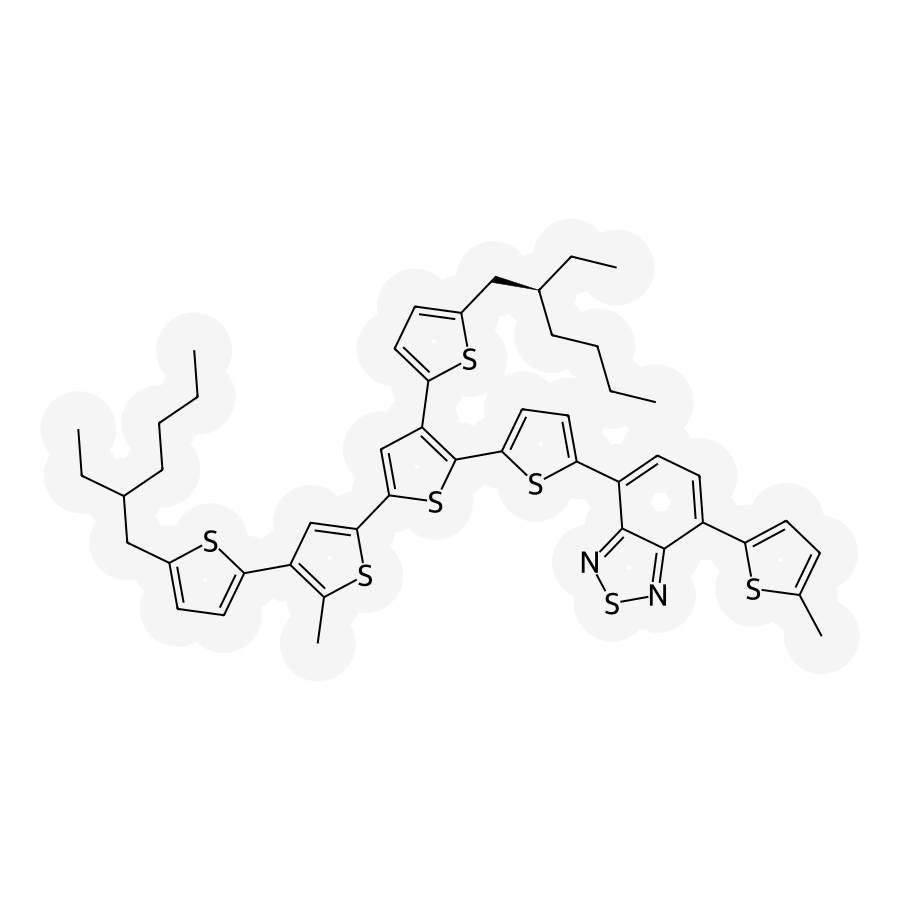

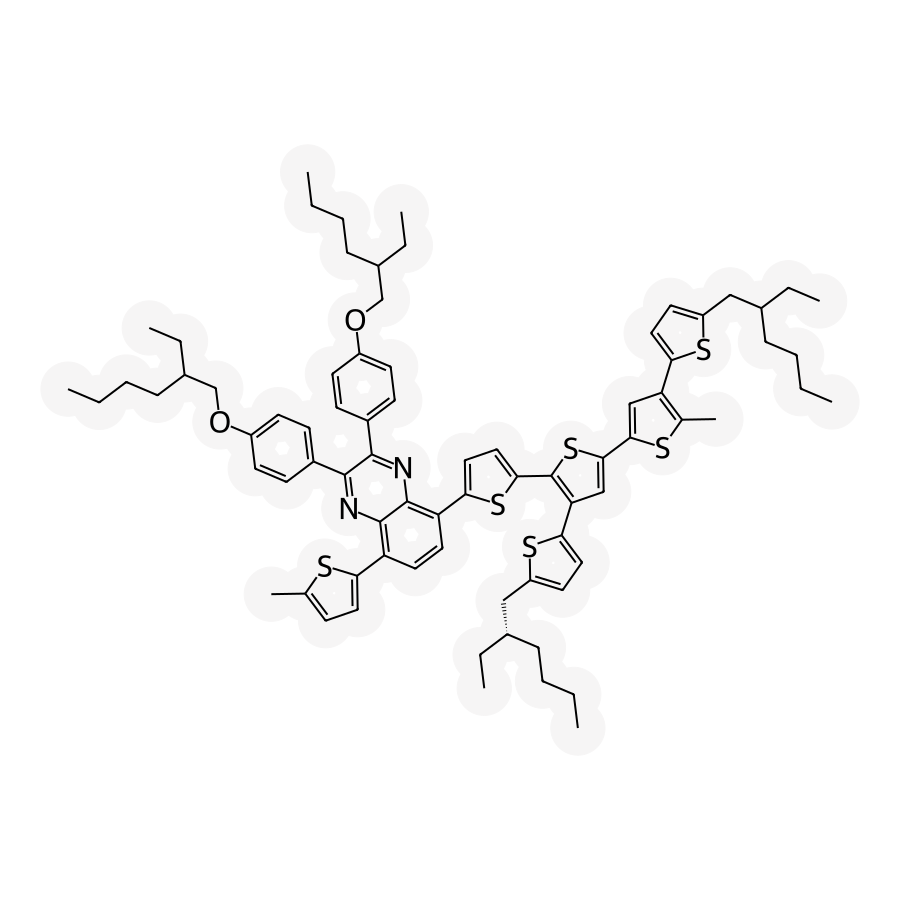

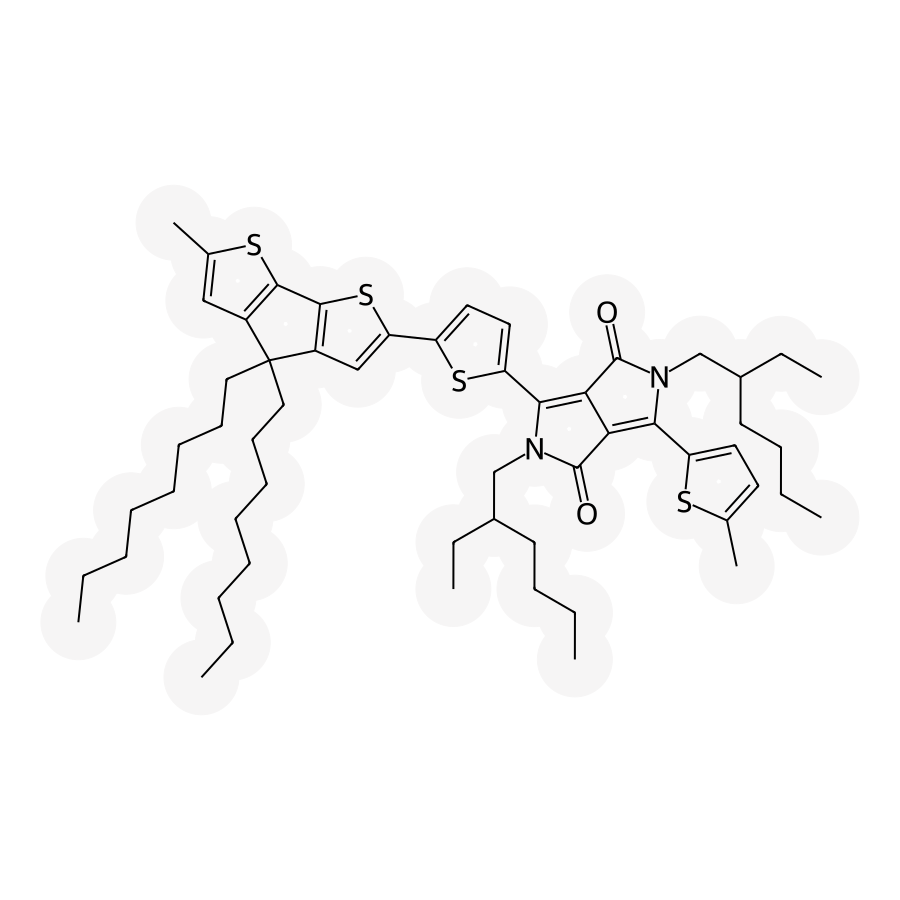

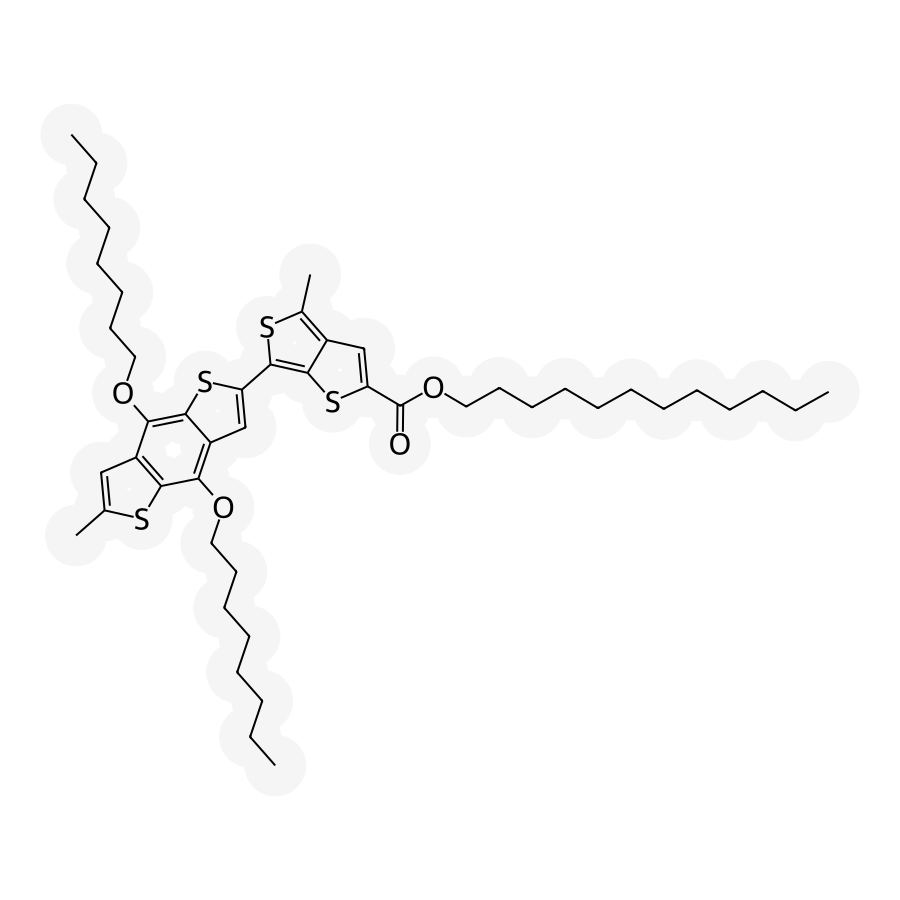

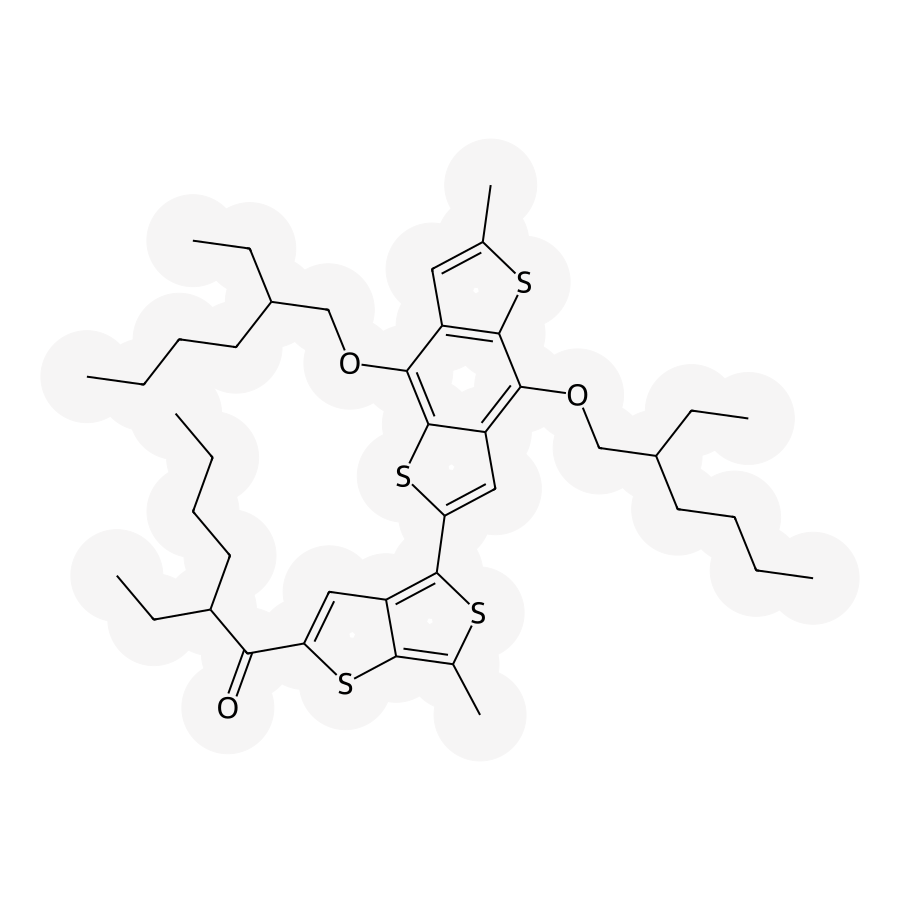

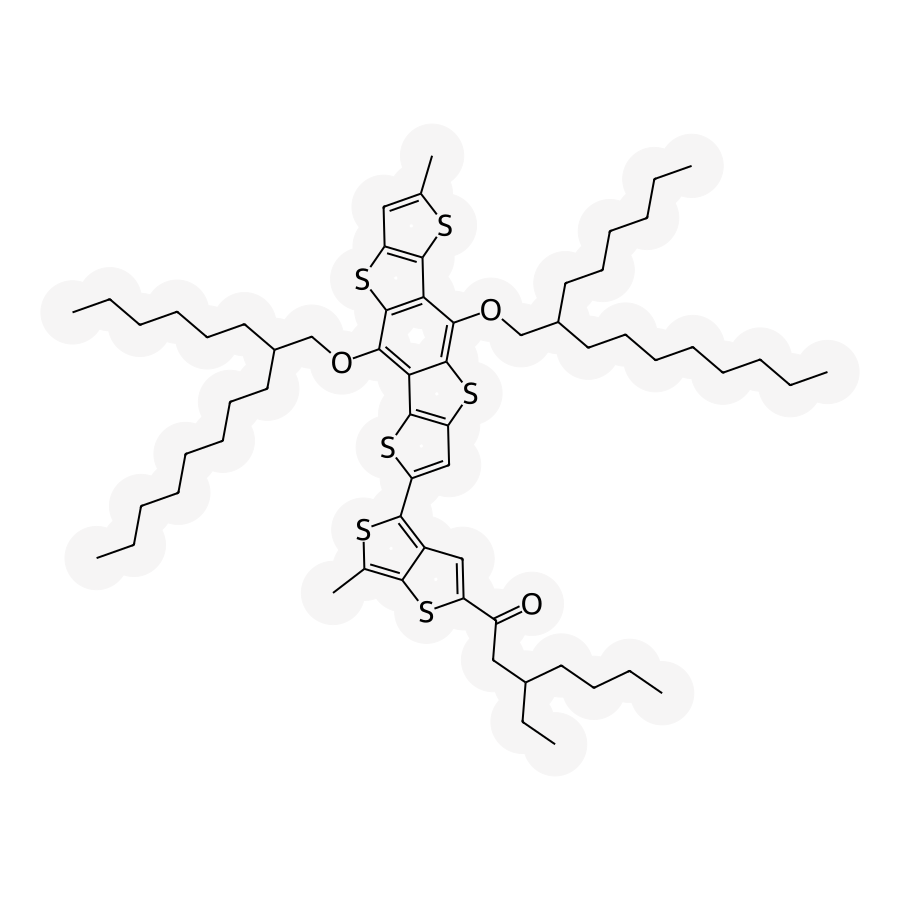

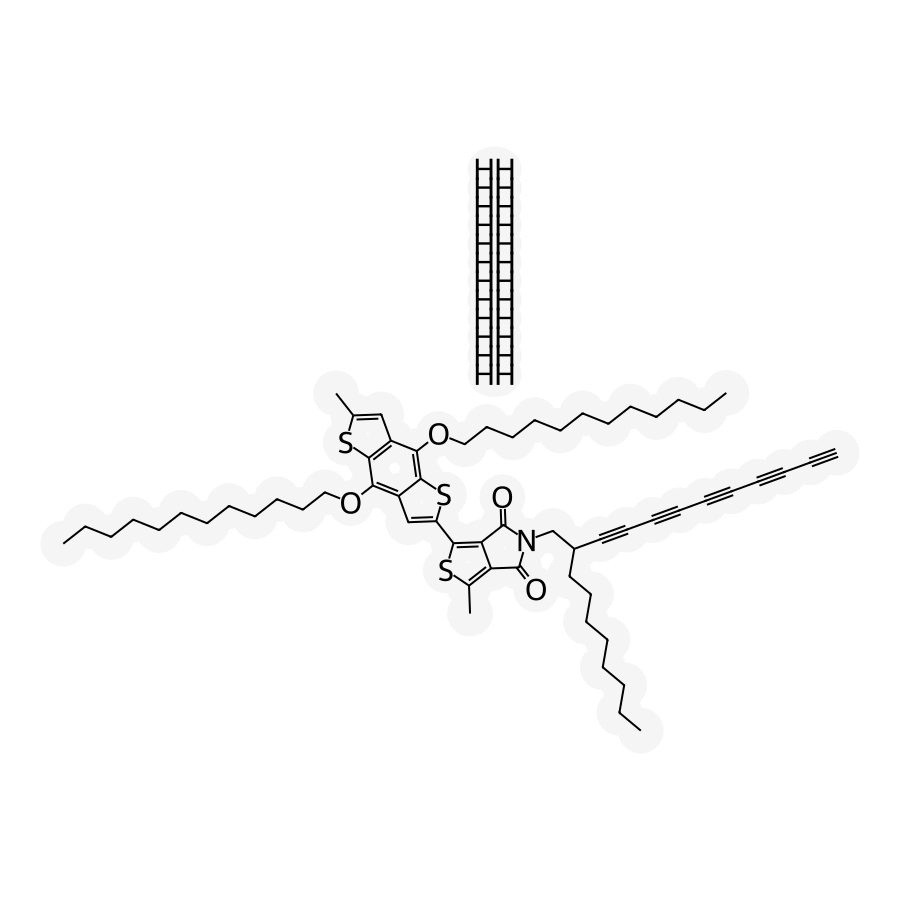

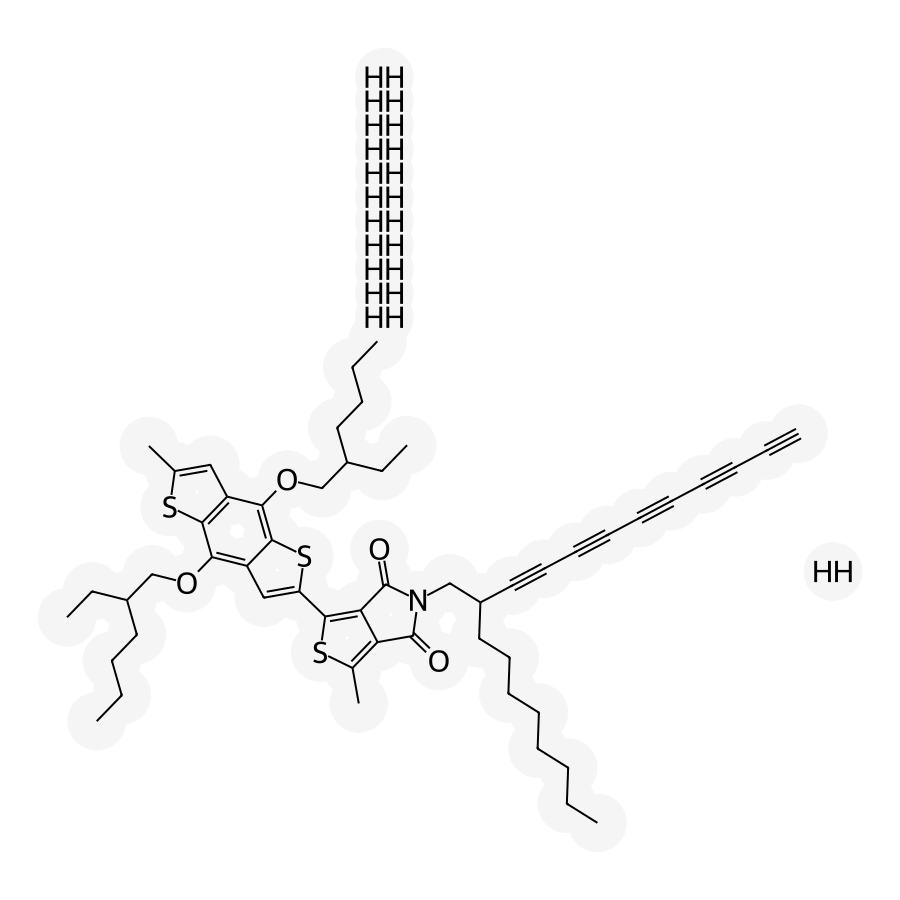

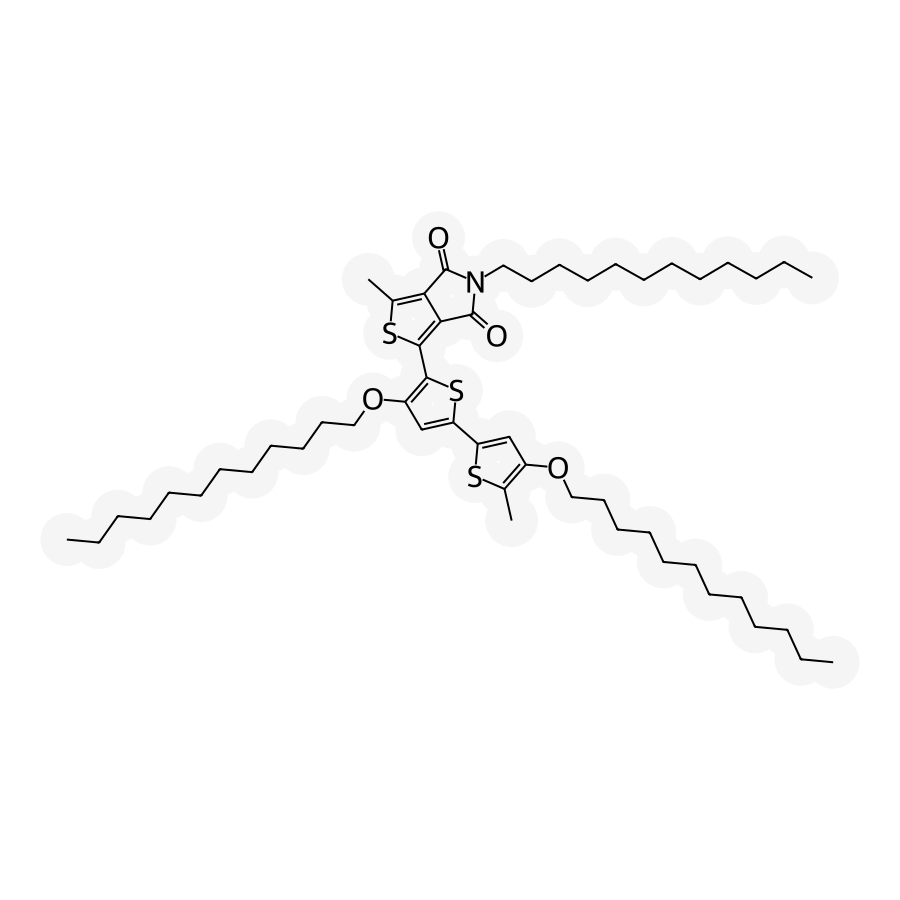

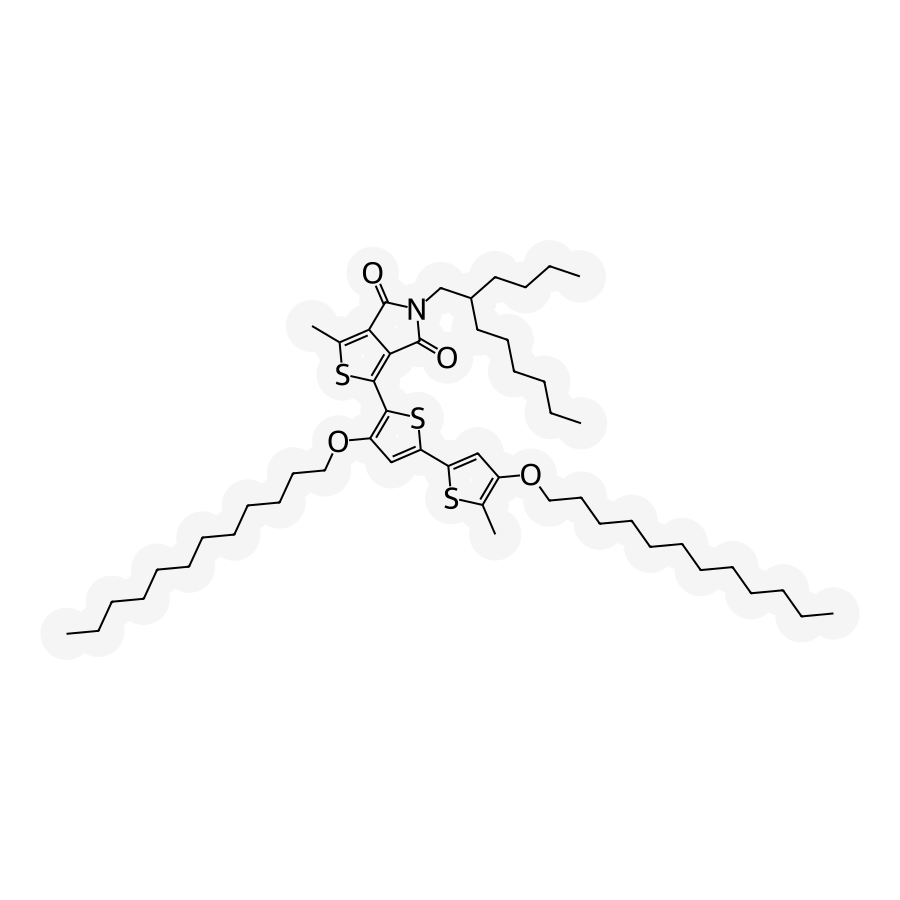

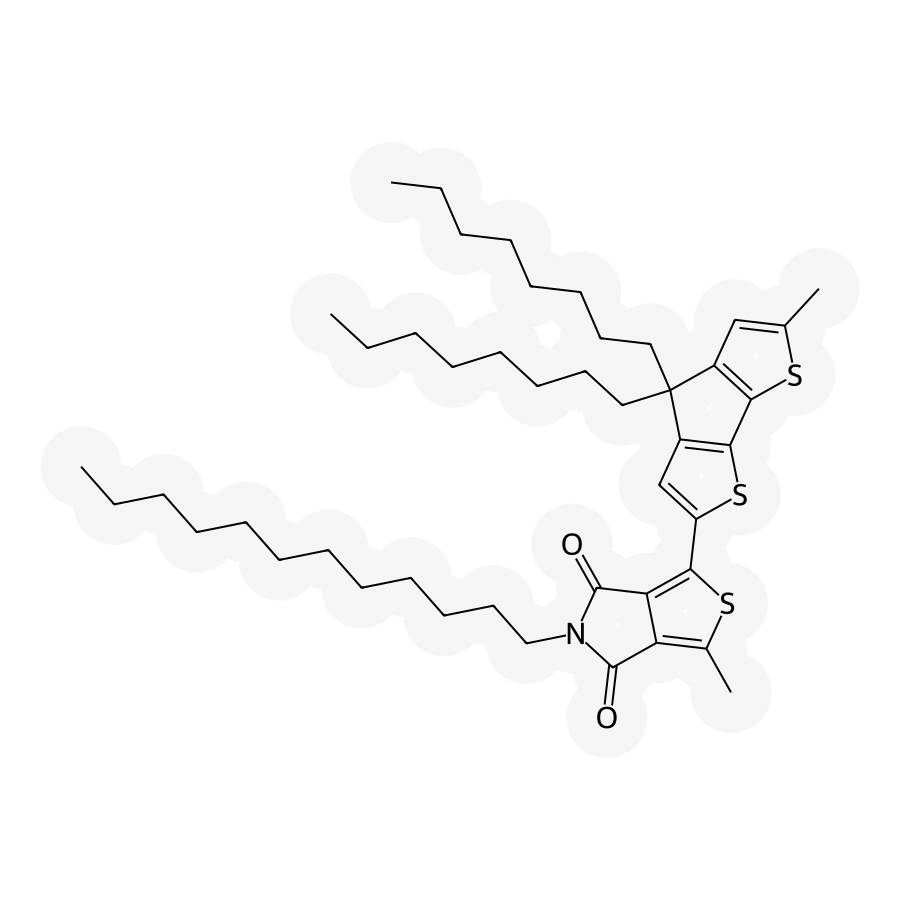

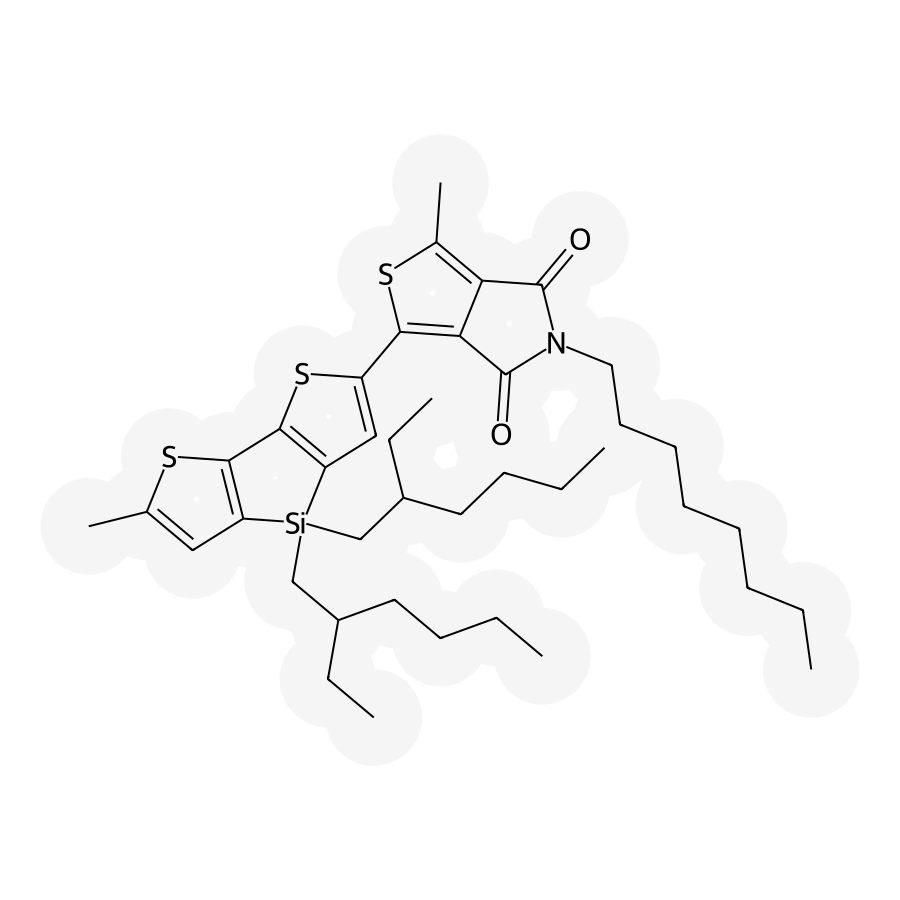

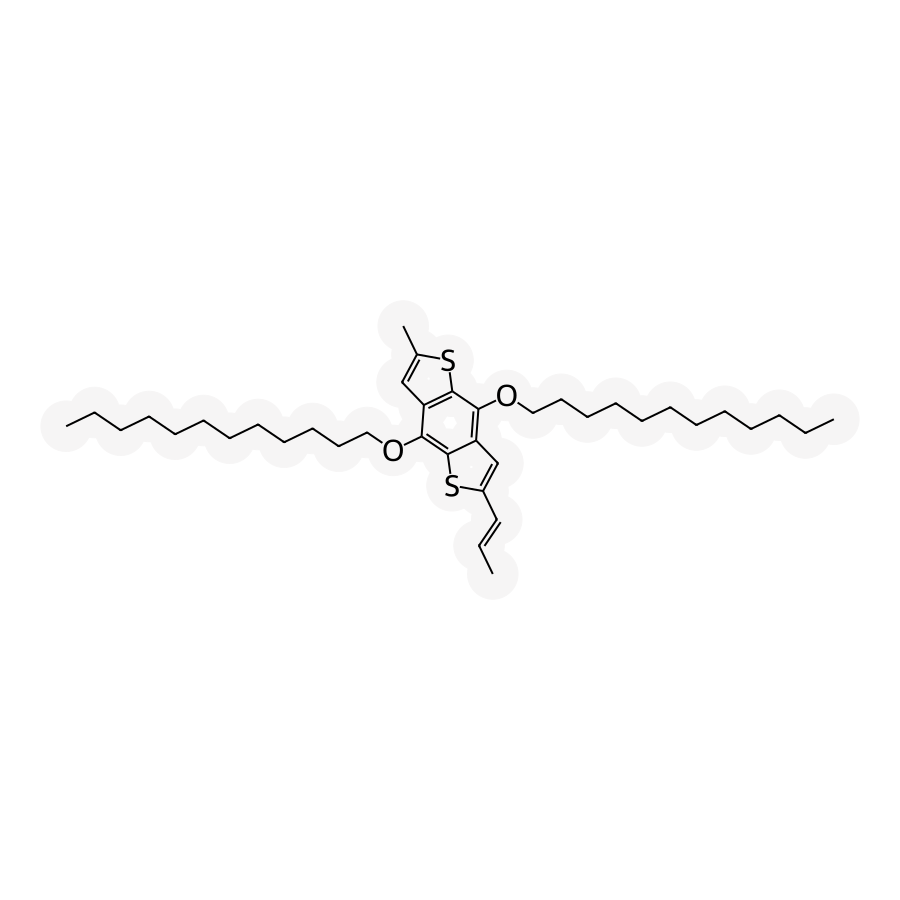

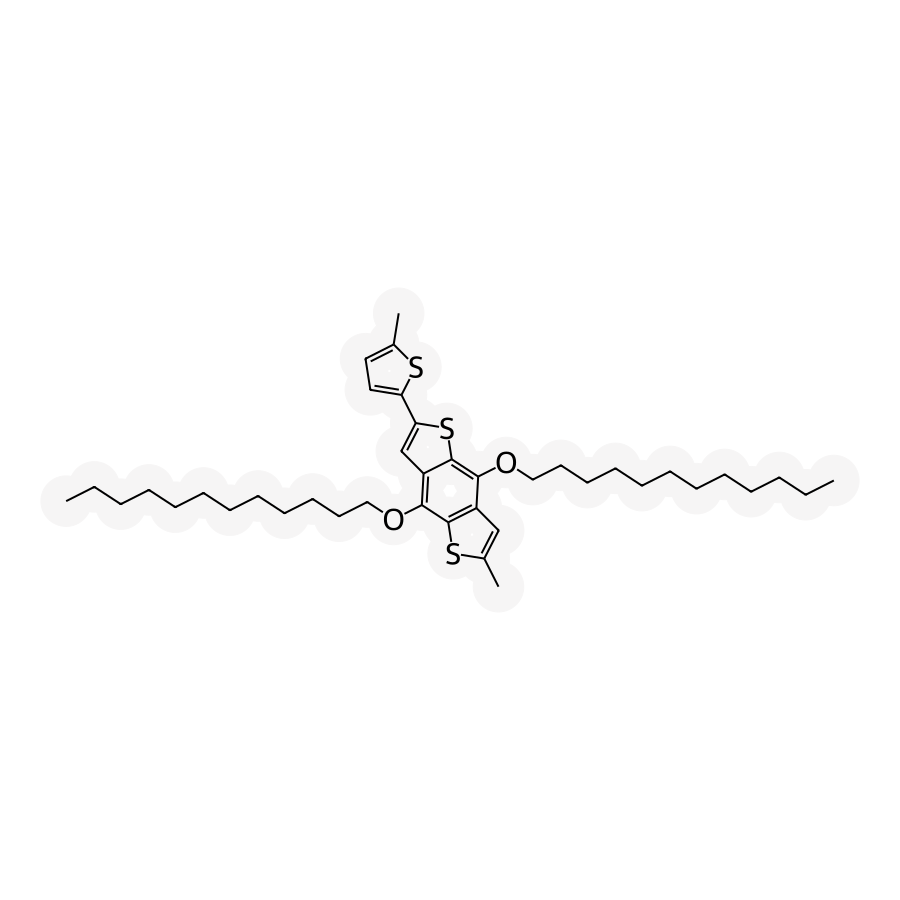

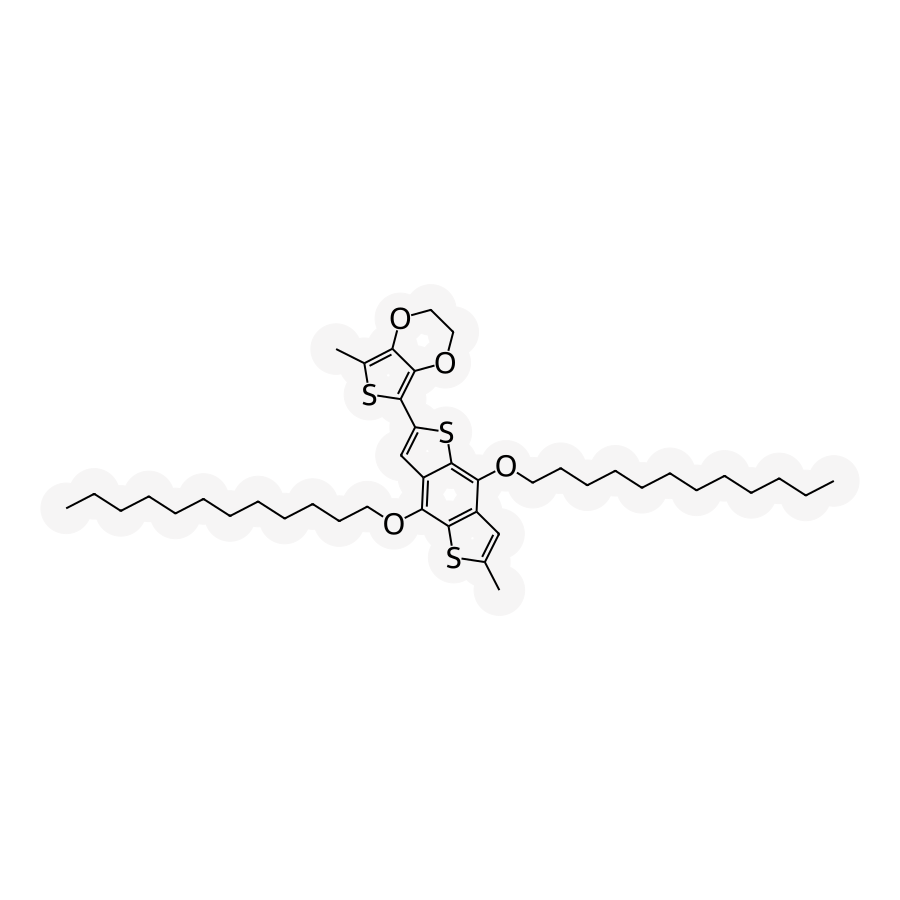

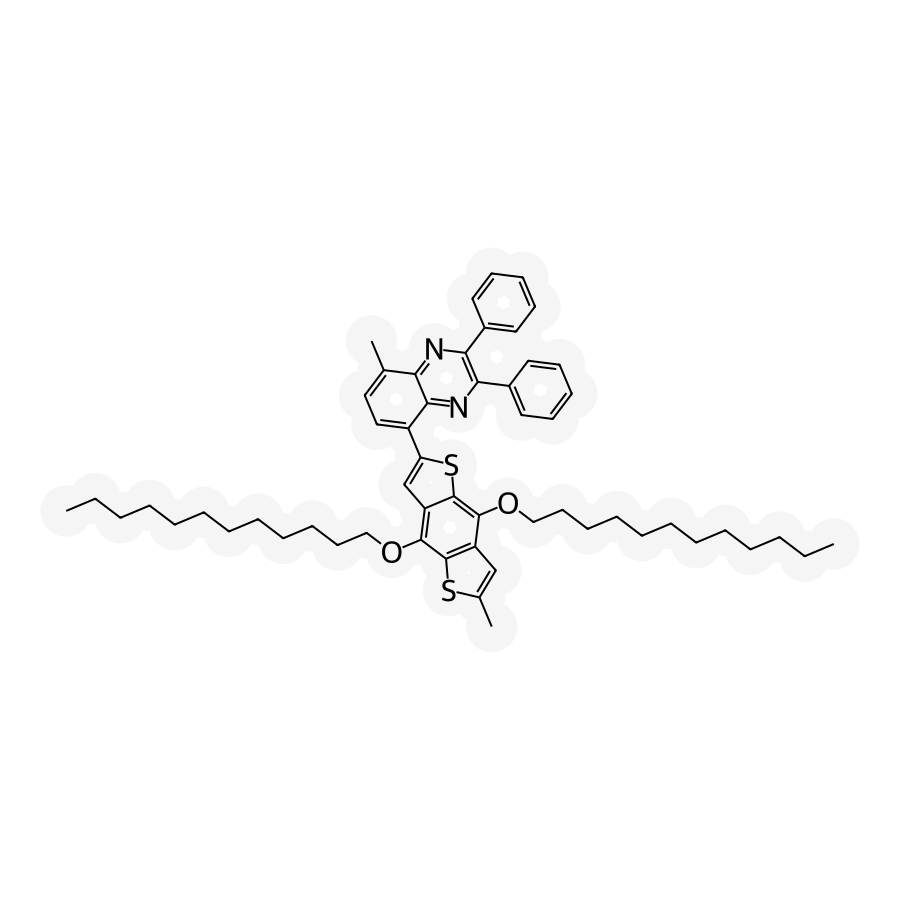

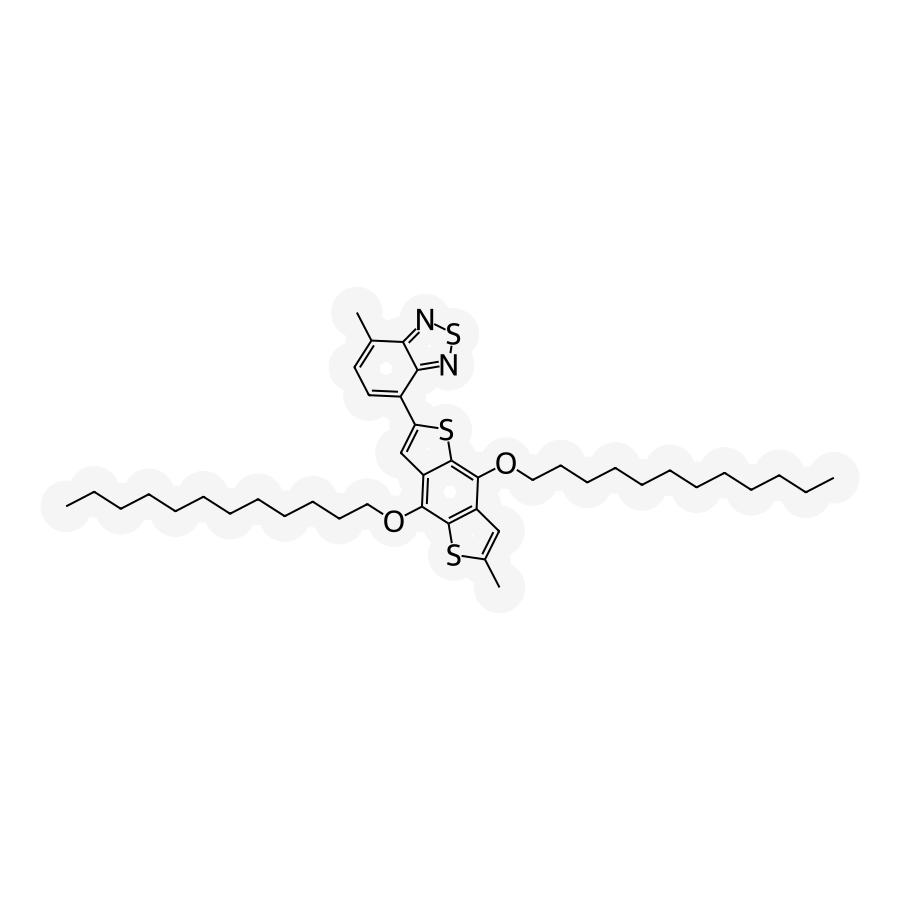

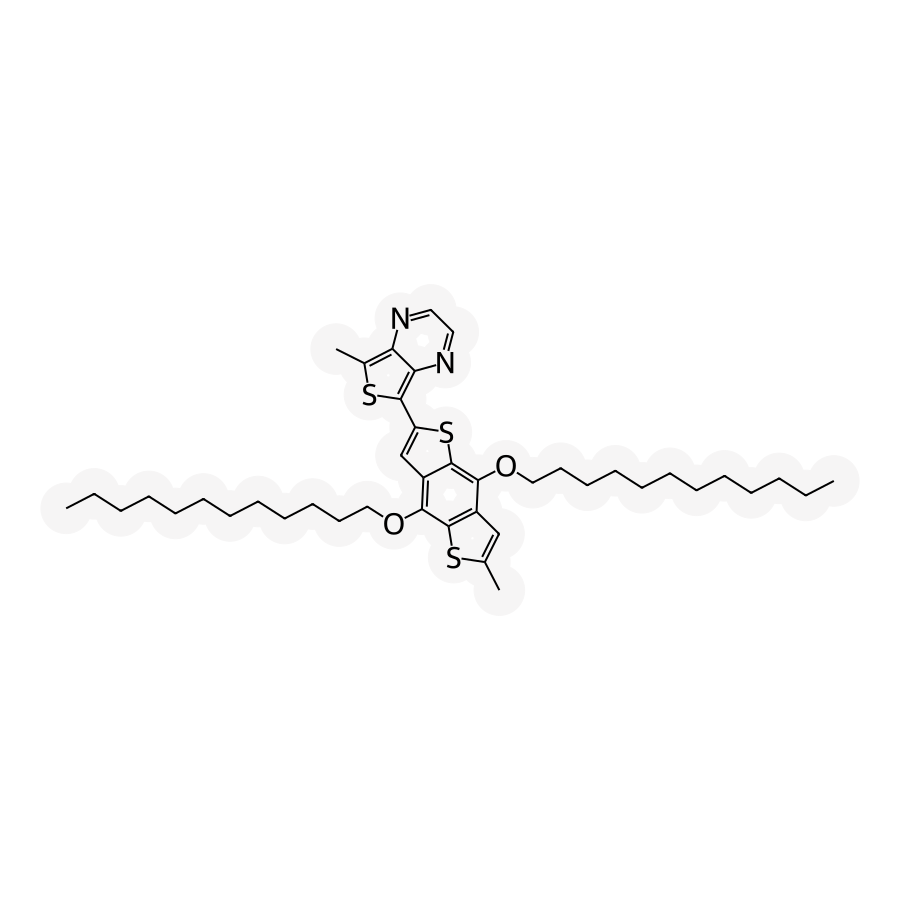

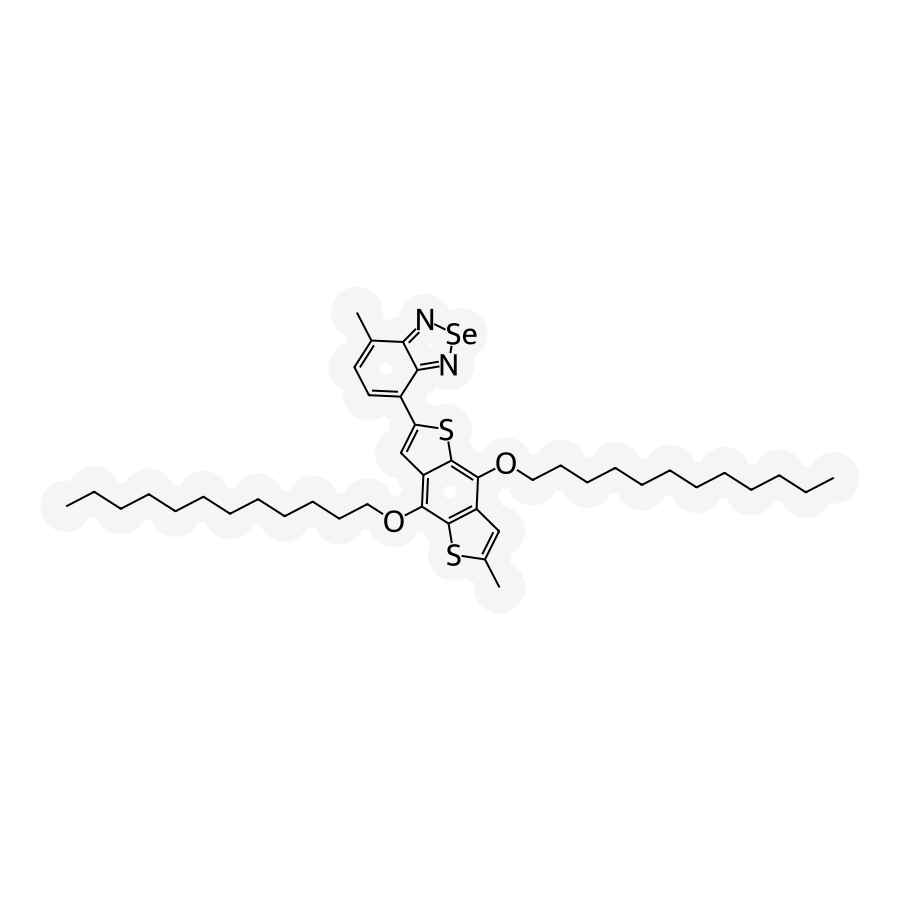

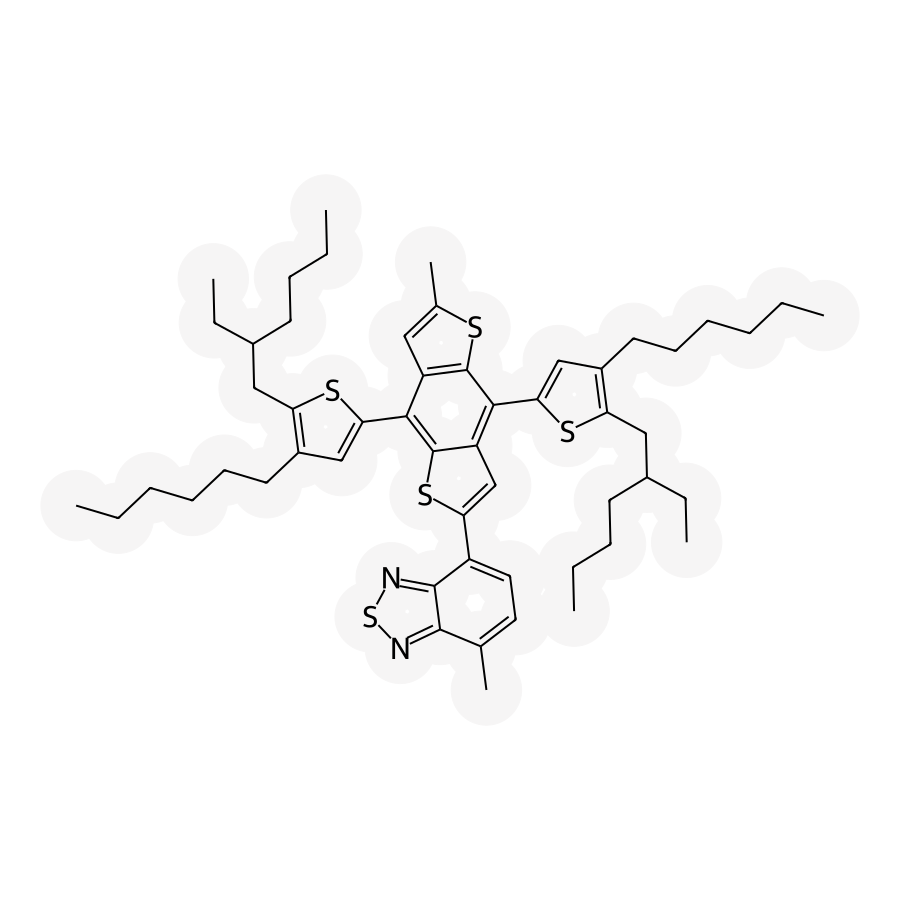

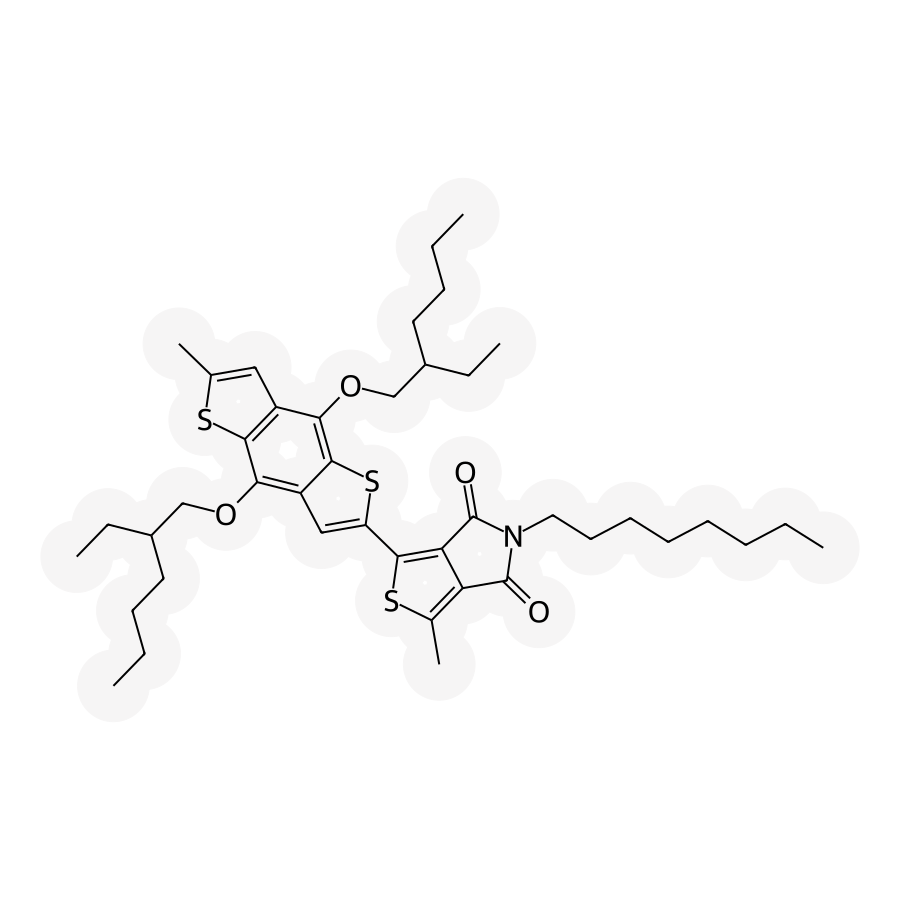

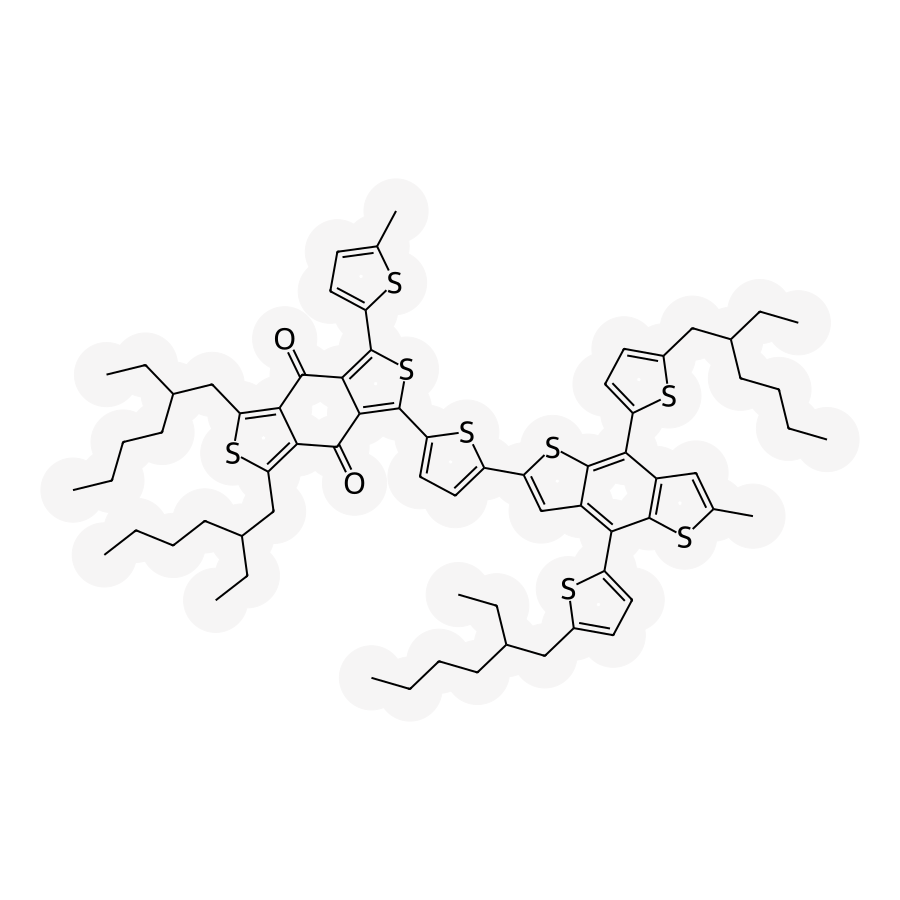

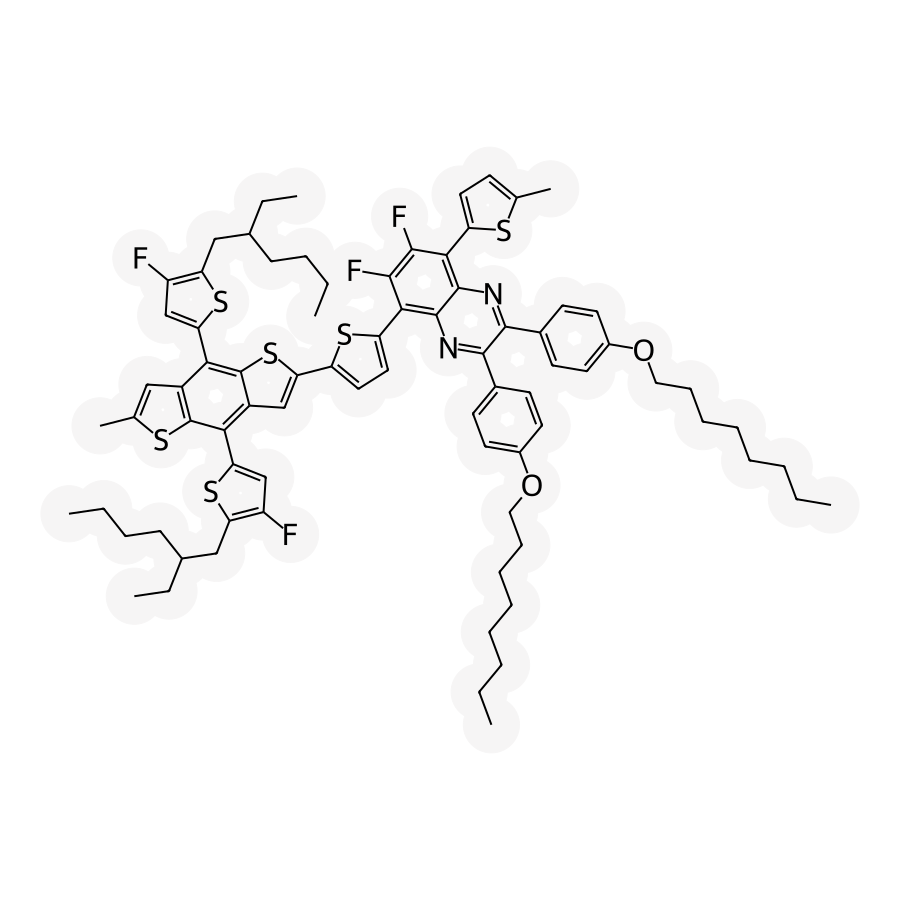

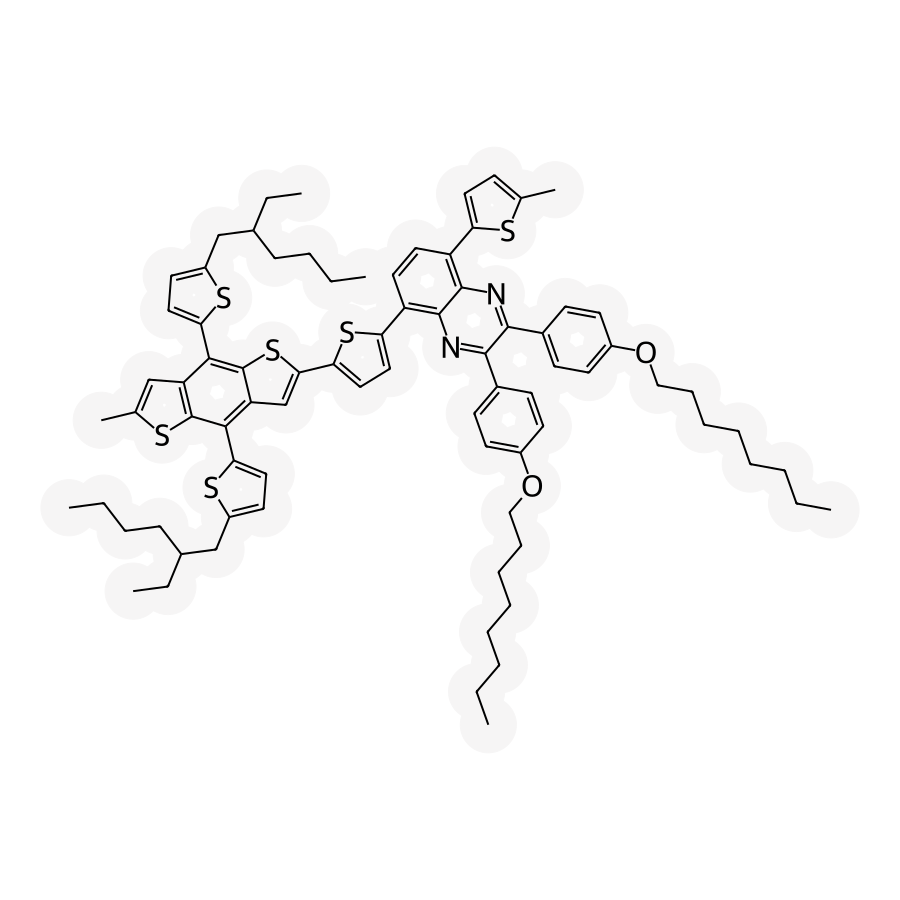

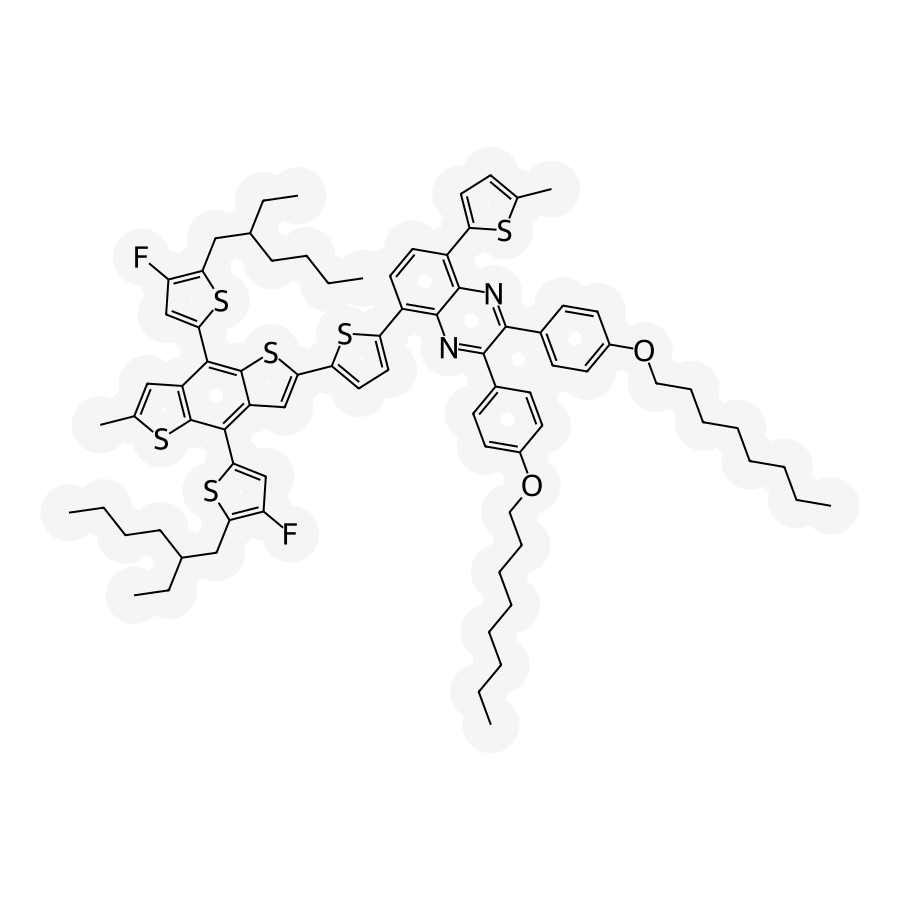

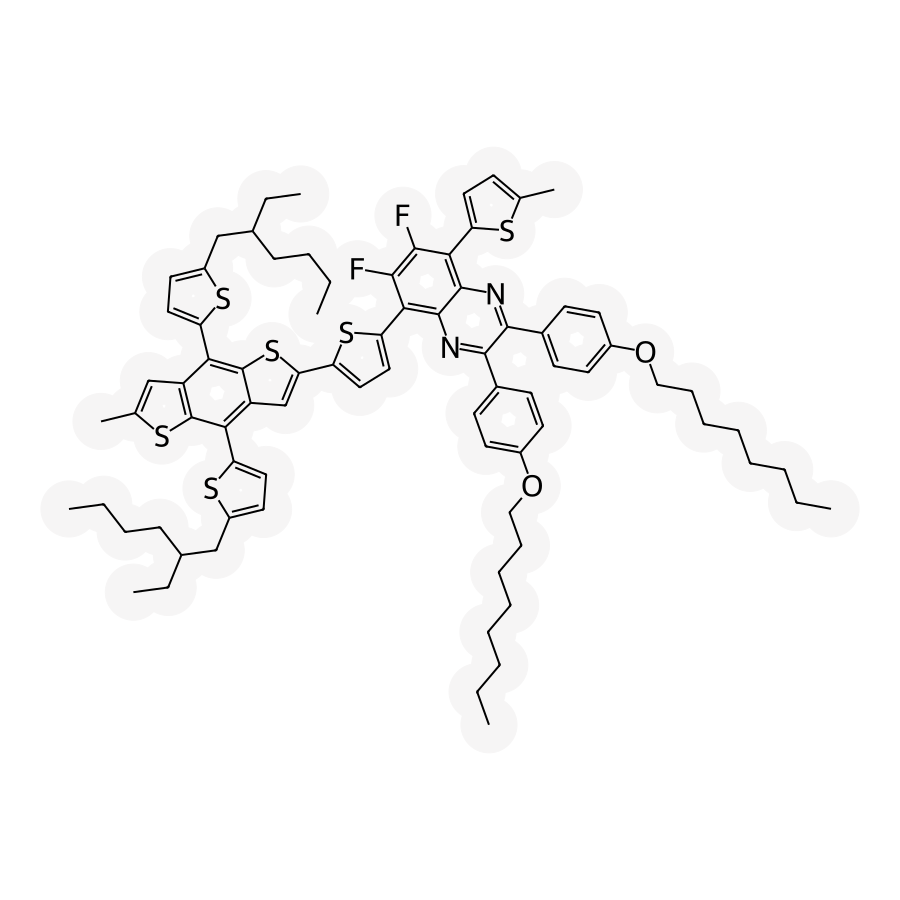

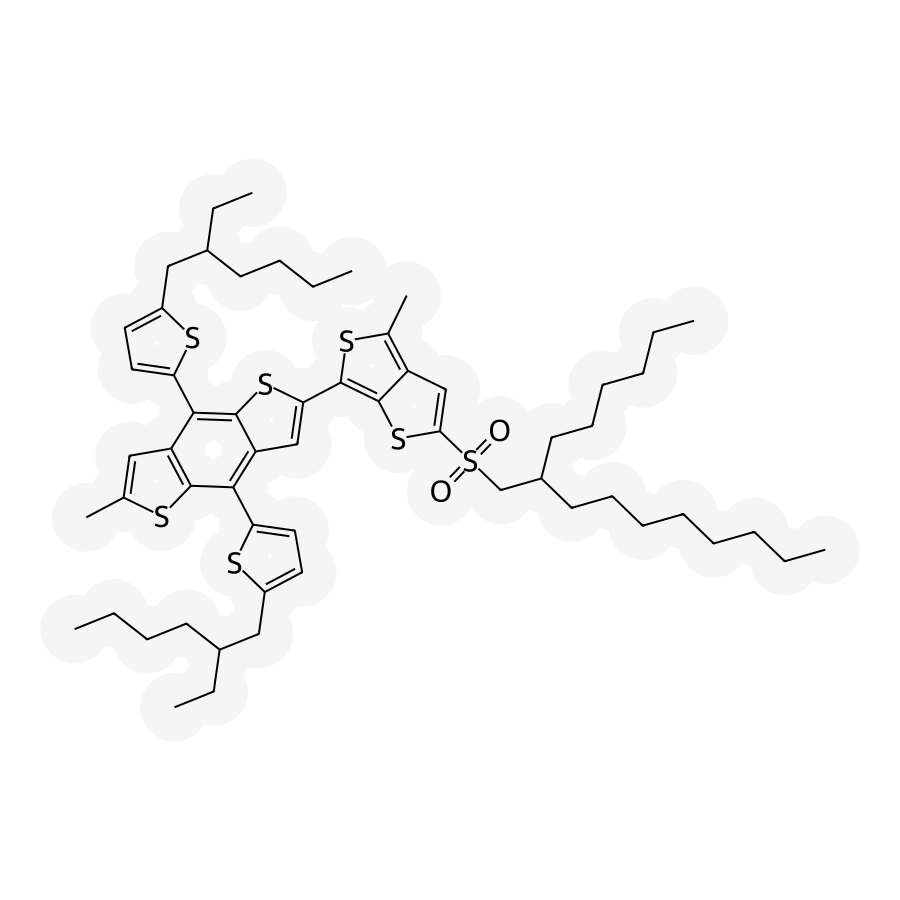

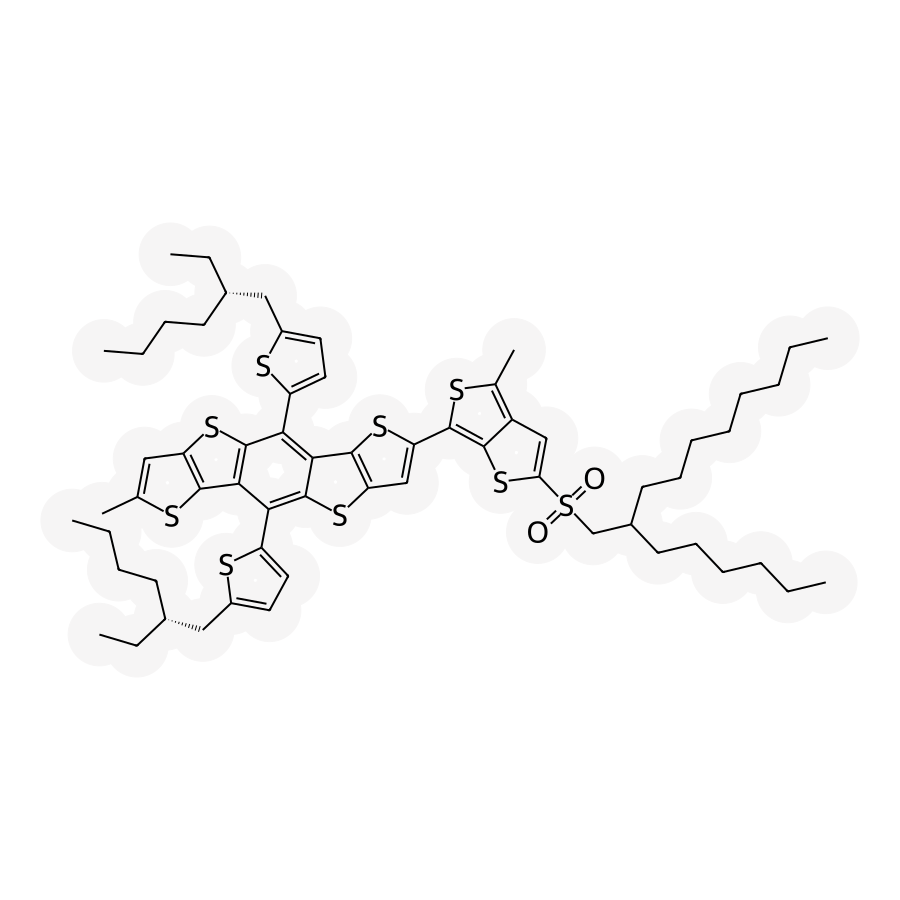

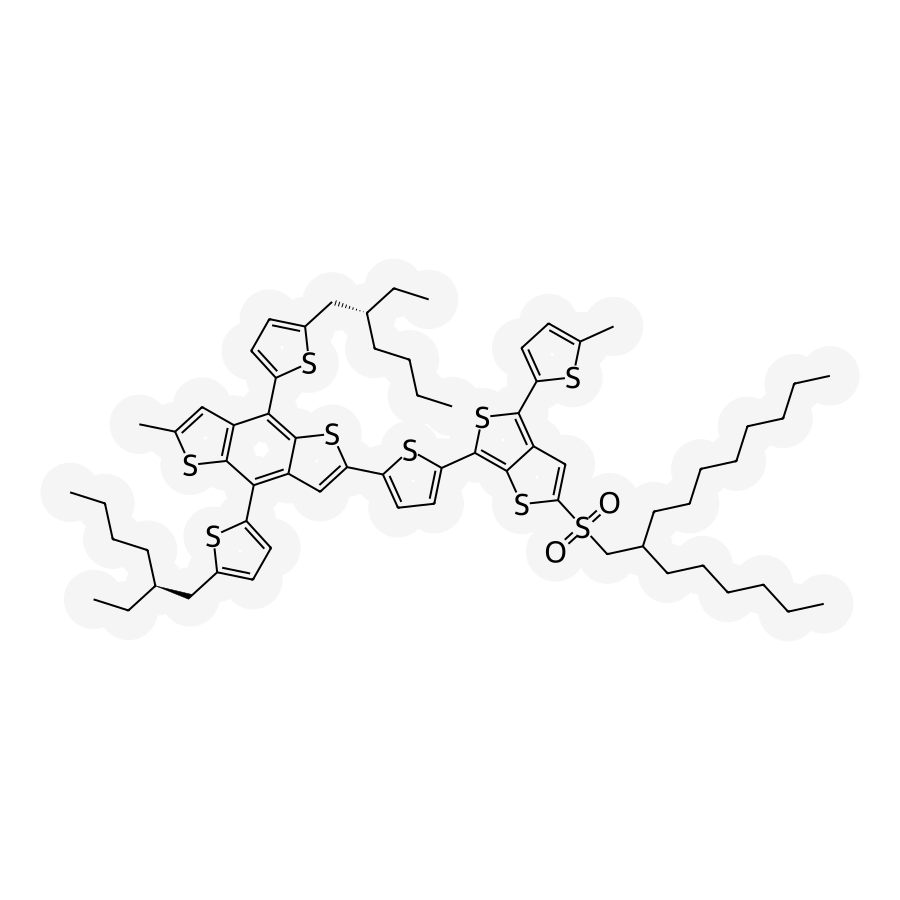

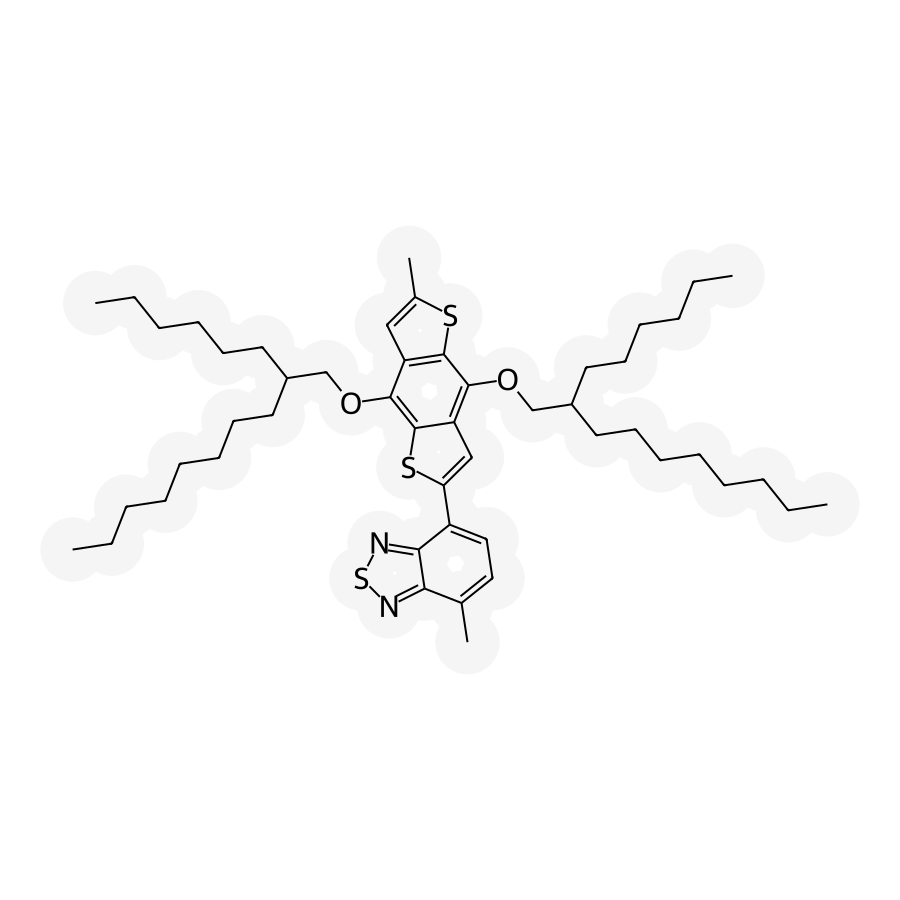

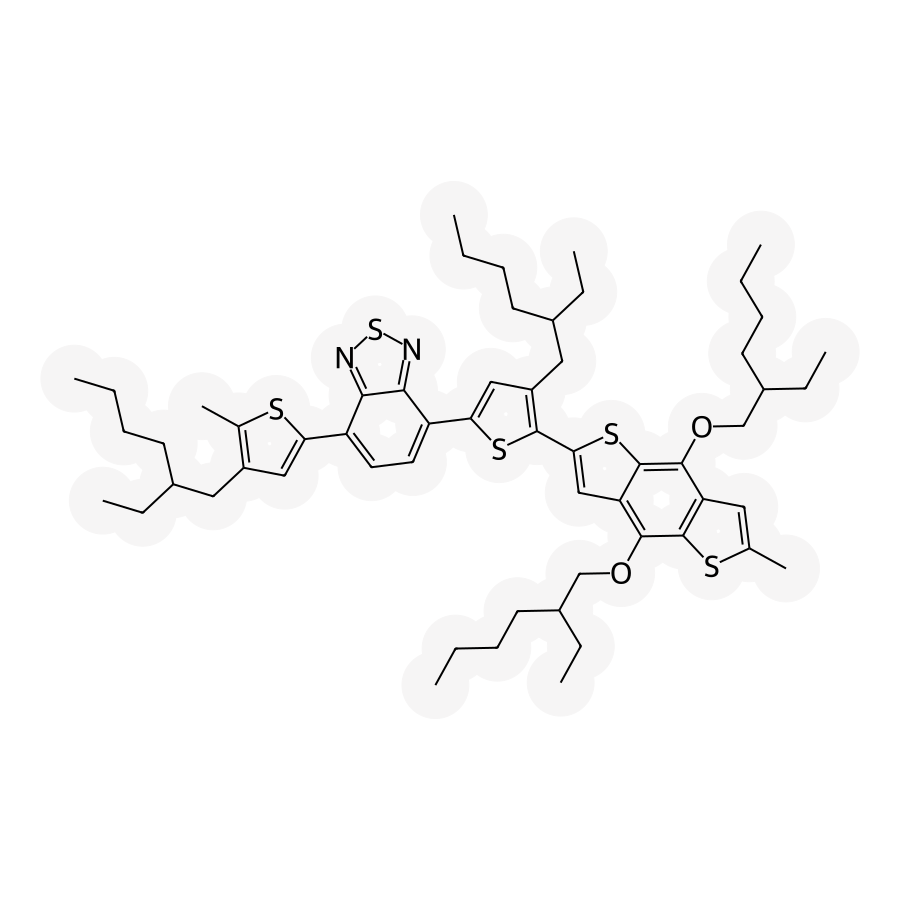

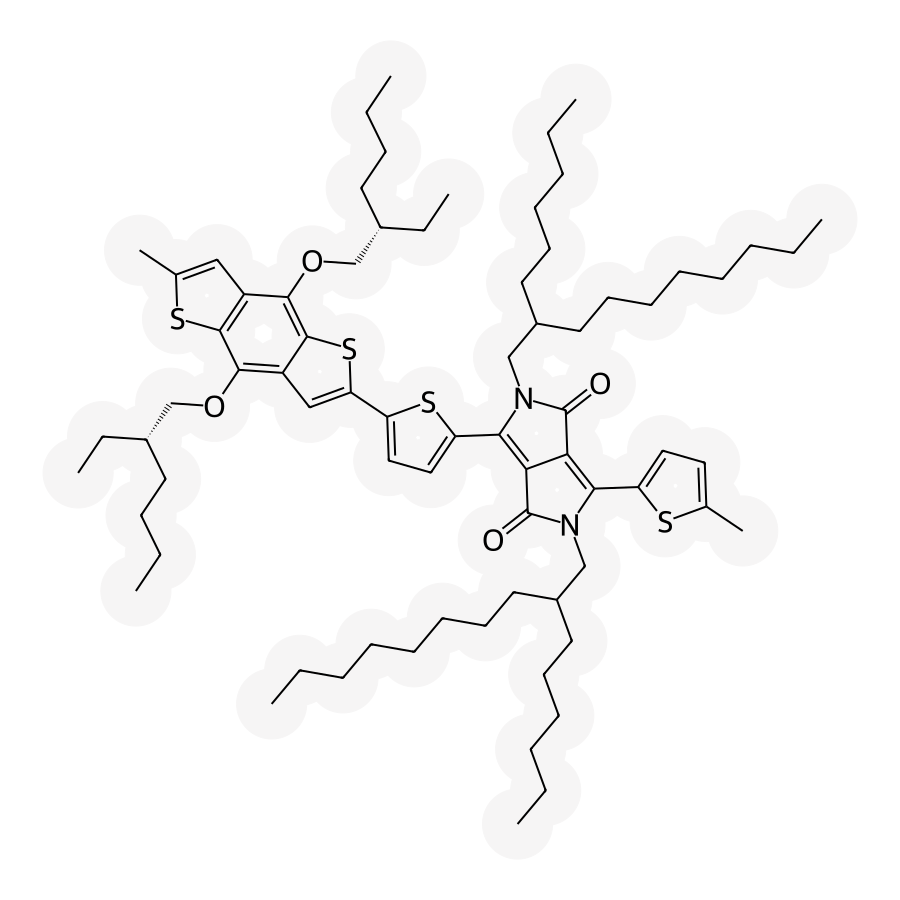

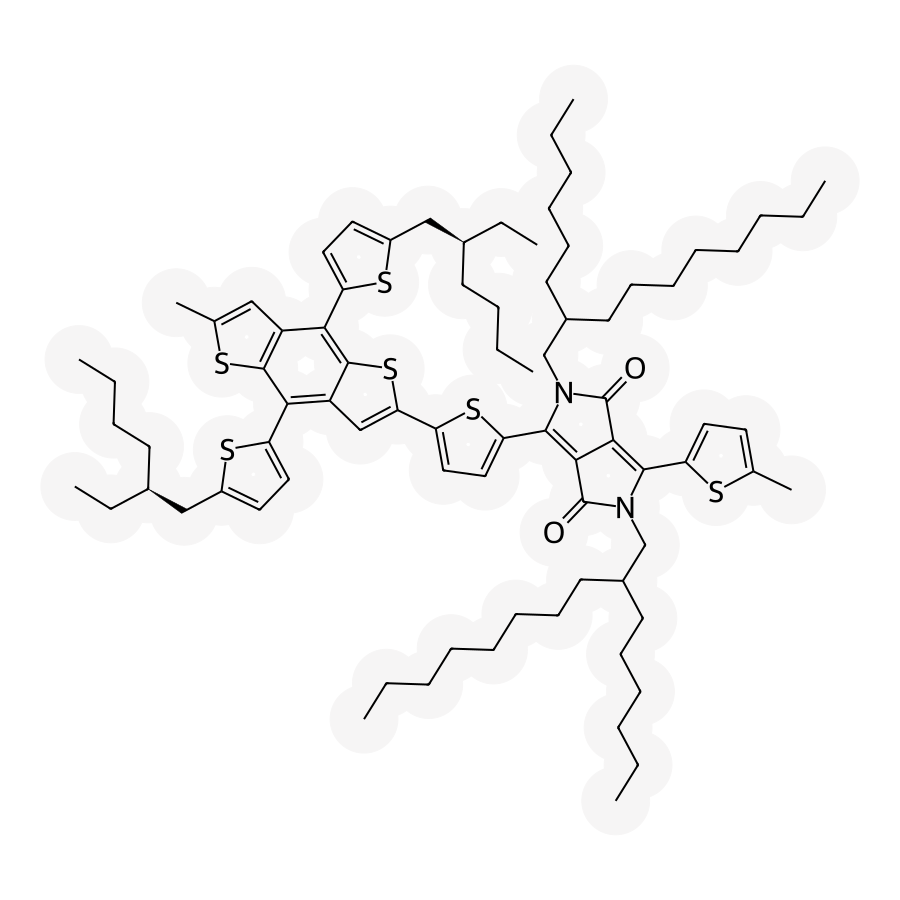

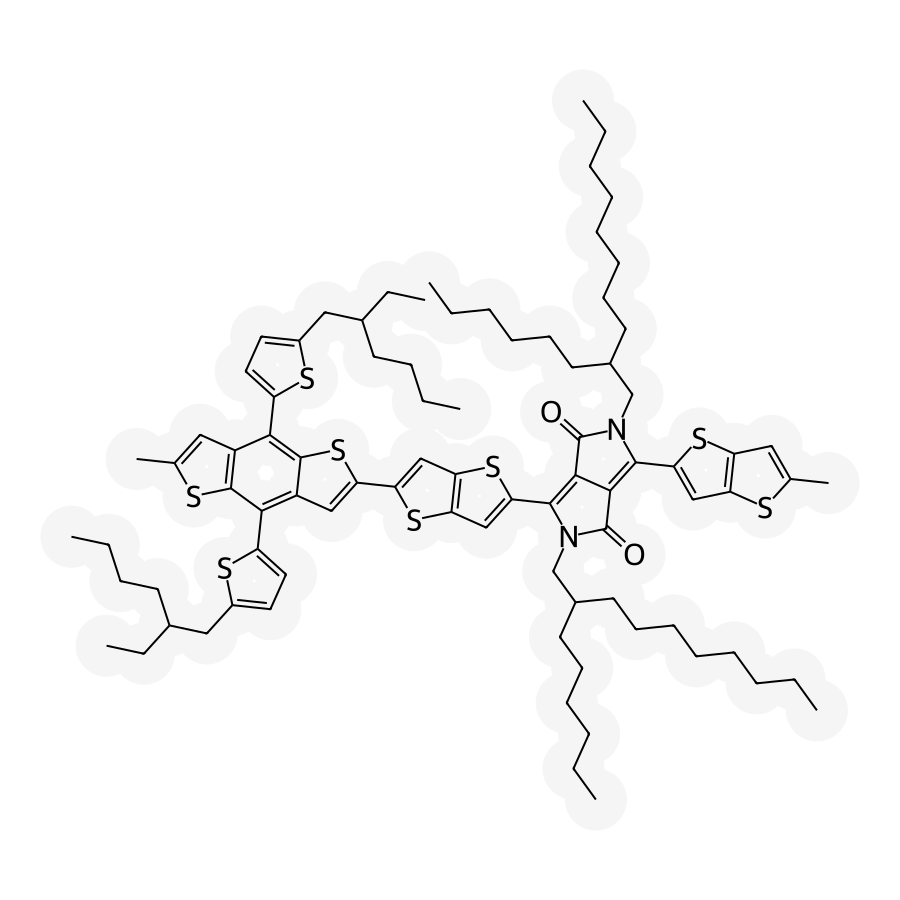

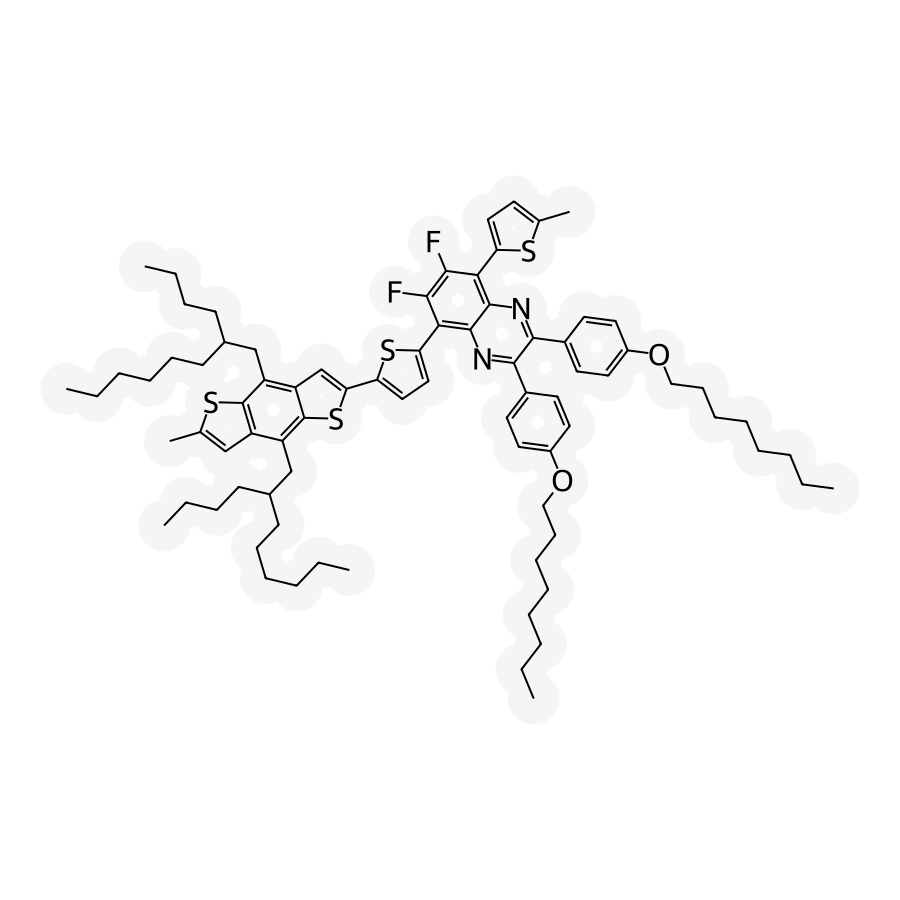

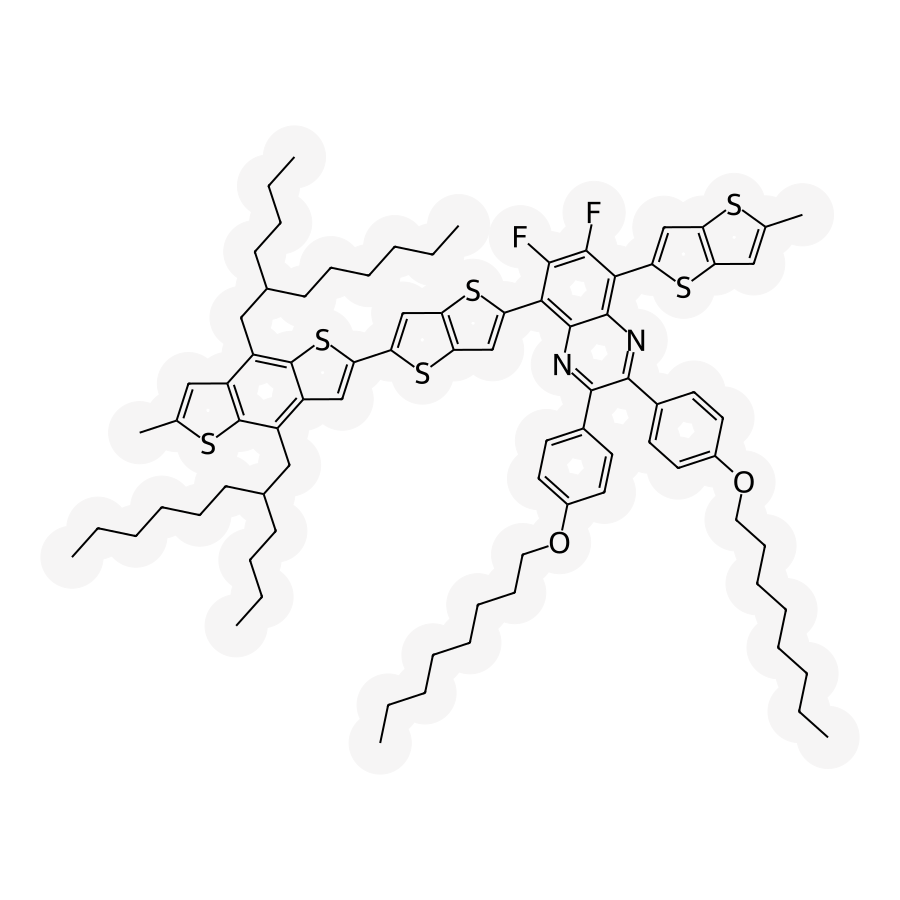

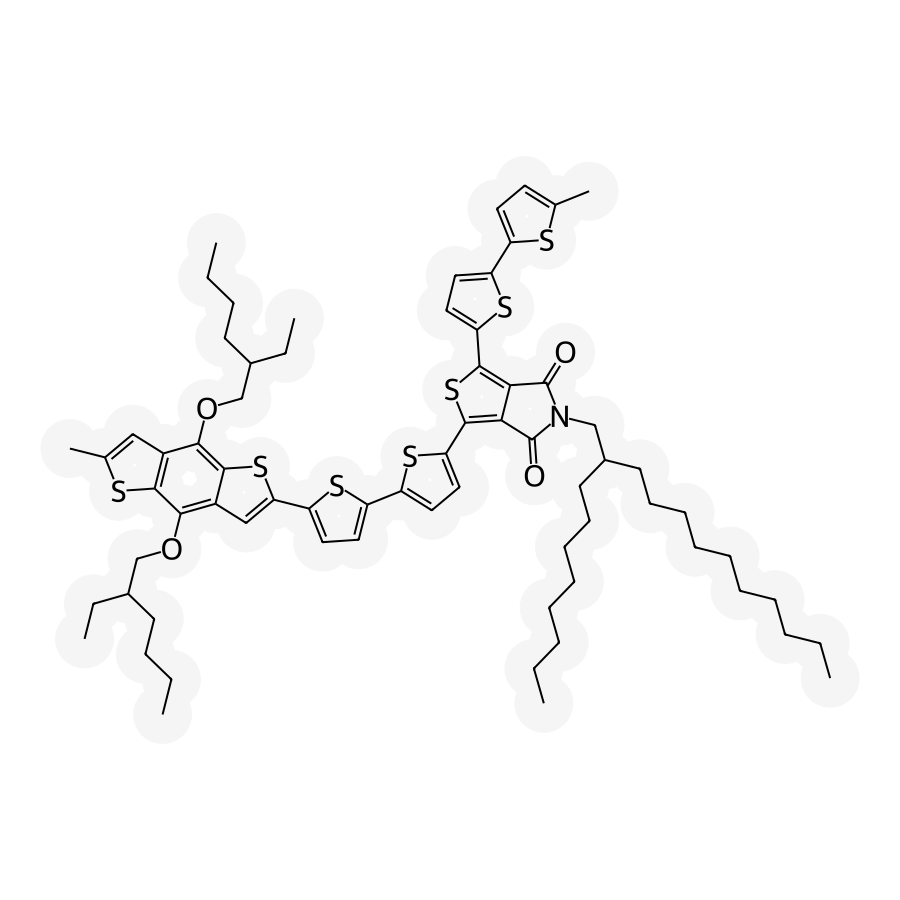

In [23]:
path = picture_path
for root,dirs,files in os.walk(path):#遍历路径中的路径，子目录，文件
    for name in files:#对于路径中的文件名
        if name.endswith('.csv'):#如果文件名以gjf结尾
            filename=path+name#定义路径+文件名
            ser = name.split('.')[0]
            path_ = path+ser+'/'
            os.makedirs(path_)
            get_analysis_picture(path_,filename,ser)

In [29]:
def get_statistics_pu(filename):
    #统计每种PU的相关性得分
    smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2= process_smiles(filename)
    name_list2 = []
    for idx,i in enumerate(name_list):
        uh = label_list1[idx]
        ue = label_list2[idx]
        name = 'name_'+ str(i)+'_'+'uh_'+str(uh)+'_'+'ue_'+str(ue)
        name_list2.append(name)
    total_bratch_dist = pu.get_bratch_dist2(smi_list,name_list)
    ring_total_list0,total_neighbor_data0,total_inner_dist0,_=pu.get_pu(smi_list,name_list)
    total_neighbor_data,total_inner_dist,ring_total_list = pu.update_bratch(name_list,smi_list,total_neighbor_data0,total_inner_dist0,total_bratch_dist)
    statistics_pu = []#记录每个pu的类型
    statistics_rel = []#记录每个pu的rel
    
    inner_dist={}
    for key,values in total_inner_dist.items():
        inner_list = []
        for k,v in values.items():
            inner_list.append(v)
        inner_dist[key]=inner_list
    pu_dist = get_pu_dist(filename)
    
    pu_dict = get_pu_dict(total_neighbor_data,ring_total_list)
    for idx,sm in enumerate(smi_list):    

        name = name_list[idx]
        solubility_target = np.nan
        mol = Chem.MolFromSmiles(sm)
        graph_in = smiles_to_graph(pu_dist,name)
        batch = tg.GraphBatch.from_graphs([graph_in]).requires_grad_().zero_grad_()
        out = net_rel(batch).global_features
        #display(Markdown(f'### {name}'))
        #display(Markdown(f'{np.round(solubility_target, 2)}\t{round(out.item(), 2)}'))
        out.backward(out)
        node_rel = batch.node_features.grad.sum(dim=1)
        pu_index = list(pu_dict[name].values())
        statistics_pu = statistics_pu + pu_index
        statistics_rel = statistics_rel + node_rel.tolist()

    return statistics_pu,statistics_rel,ring_total_list
        

In [30]:
statistics_pu,statistics_rel,ring_total_list = get_statistics_pu(data_path)

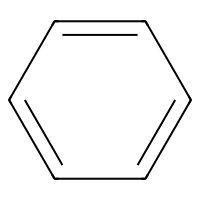

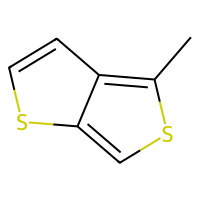

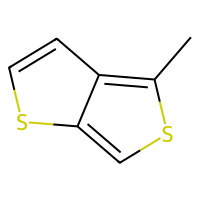

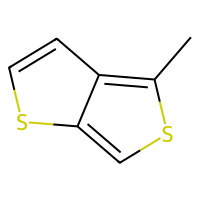

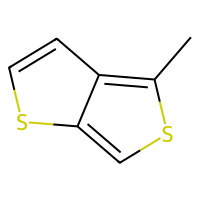

In [31]:
#显示平均相关性最高的5个结构
pu_rel = [0 for i in range(len(ring_total_list))]
pu_num = [0 for i in range(len(ring_total_list))]
for idx,i in enumerate(statistics_pu):
    pu_rel[i] = pu_rel[i]+statistics_rel[idx]
    pu_num[i] = pu_num[i] + 1
    
pu_rel_mean = (np.array(pu_rel)/np.array(pu_num)).tolist()
index = pu_rel_mean.copy()
pu_rel_mean.sort()
top = pu_rel_mean[-5:][::-1]
last = pu_rel_mean[:5]
top_index=[]
last_index=[]
top_smiles=[]
last_smiles=[]
for i in top:
    num = index.index(i)
    top_index.append(num)
    top_smiles.append(ring_total_list[num])
for i in last:
    num = index.index(i)
    last_index.append(num)
    last_smiles.append(ring_total_list[num])
#显示结构图像    
for i in top_smiles:
    mol = Chem.MolFromSmiles(i)
    fig = Draw.MolToImage(mol, size=(200,200), kekulize=True)
    display(fig)

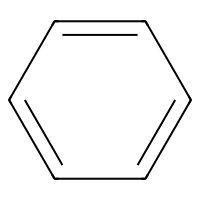

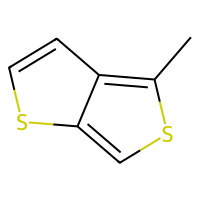

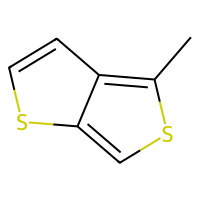

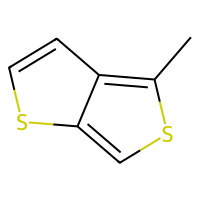

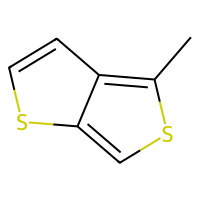

In [32]:
#显示统计相关性最高的五个结构
pu_rel = [0 for i in range(len(ring_total_list))]
pu_num = [0 for i in range(len(ring_total_list))]
for idx,i in enumerate(statistics_pu):
    pu_rel[i] = pu_rel[i]+statistics_rel[idx]
    pu_num[i] = pu_num[i] + 1
    
index = pu_rel.copy()
pu_rel.sort()
top = pu_rel[-5:][::-1]
last = pu_rel[:5]
top_index=[]
last_index=[]
top_smiles=[]
last_smiles=[]
for i in top:
    num = index.index(i)
    top_index.append(num)
    top_smiles.append(ring_total_list[num])
for i in last:
    num = index.index(i)
    last_index.append(num)
    last_smiles.append(ring_total_list[num])
    
#收集统计相关性前五名所代表的基元
statistics_point =  [[] for i in range(len(top_index))]
for idx,i in enumerate(statistics_point):
    index = top_index[idx]
    for jdx,j in enumerate(statistics_pu):
        if j == index:
            statistics_point[idx].append(statistics_rel[jdx])

#显示结构图像    
for i in top_smiles:
    mol = Chem.MolFromSmiles(i)
    fig = Draw.MolToImage(mol, size=(200,200), kekulize=True)
    display(fig)